In [1]:
import argparse
import logging
import os
import random
import sys
from sklearn.model_selection import train_test_split
from dataset import BrainMRIDATASET
import nibabel
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import numpy as np
# from evaluate_copy import evaluate
from unet_data_unc import UNet
# from utils.data_loading import BasicDataset, CarvanaDataset
# from loss import dice_loss

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# !source .venv/bin/activate
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# from torchmetrics.functional import dice_score
from torchmetrics import Dice,JaccardIndex, Precision, Recall , Specificity, F1Score
precision = Precision(task="multiclass", average='macro', num_classes=2).to(device)
recall = Recall(task="multiclass", average='macro', num_classes=2).to(device)
specificity = Specificity(task="multiclass", average='macro', num_classes=2).to(device)
# sens = Sensitivity(task="multiclass", average='macro', num_classes=2).to(device)
f1_sc = F1Score(task="multiclass", average='macro', num_classes=2).to(device)
Iou = JaccardIndex(task="multiclass", num_classes=2).to(device)
dice = Dice(task="multiclass", num_classes=2).to(device)
# dice = dice_score()

In [3]:
iou_csv = []

In [4]:
import pandas as pd
import numpy as np
# val_dice = pd.read_csv("results/val_dice_model_unc_samp20.csv", header=None)
val_iou = pd.read_csv("results/val_iou_model_unc_samp18.csv", header=None)

In [5]:
## samp15
print(max(val_iou[0]))
print(val_dice[0][val_iou.idxmax()])

0.73671


NameError: name 'val_dice' is not defined

In [6]:
## samp18
print(max(val_iou[0]))
print(val_iou.idxmax())

0.73671
0    56
dtype: int64


In [7]:
## samp20
print(max(val_iou[0]))
print(val_iou.idxmax())

0.73671
0    56
dtype: int64


In [8]:
iou_csv.append(max(val_iou[0]))

In [9]:
iou_csv

[0.73671]

In [10]:
key = [15,18,20]

In [11]:
# pip install torchmetrics.functional

In [3]:
data_ob = BrainMRIDATASET()
data_path = '/DATA/shraddha/brain-tumor-segmentation-unet/brain_tumor_dataset/'
dataset_tr, dataset_val, dataset_test  = data_ob.get_BrainMRIDataset(root=data_path)

Number of patients in train set: 143, validation_set: 45 and test set: 45
torch.Size([2335, 512, 512])
torch.Size([2335, 512, 512])
torch.Size([2335, 1, 512, 512])
torch.Size([2335, 1, 512, 512])
torch.Size([2335, 1, 128, 128])
torch.Size([2335, 1, 128, 128])


/DATA/shraddha/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([2335, 1, 128, 128]), torch.Size([2335, 1, 128, 128]))
torch.Size([488, 512, 512])
torch.Size([488, 512, 512])
torch.Size([488, 1, 512, 512])
torch.Size([488, 1, 512, 512])
torch.Size([488, 1, 128, 128])
torch.Size([488, 1, 128, 128])
(torch.Size([488, 1, 128, 128]), torch.Size([488, 1, 128, 128]))
torch.Size([241, 512, 512])
torch.Size([241, 512, 512])
torch.Size([241, 1, 512, 512])
torch.Size([241, 1, 512, 512])
torch.Size([241, 1, 128, 128])
torch.Size([241, 1, 128, 128])
(torch.Size([241, 1, 128, 128]), torch.Size([241, 1, 128, 128]))
torch.Size([4670, 1, 128, 128]) torch.Size([4670, 1, 128, 128])


In [8]:
model = torch.load("/DATA/shraddha/BS_Thesis/paper_experiments/results/unet_model_unc_samp20.pt")

In [9]:

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img = torch.empty(488,1,128,128)
pred = torch.empty(488,2,128,128)
true = torch.empty(488,1,128,128)
prec = 0
rec = 0
spec = 0
f1 = 0
dice_sc = 0
iou_sc = 0
counts = 0
with torch.autocast(device.type if device.type != 'cuda' else 'cpu'):
    for batch in tqdm(dataset_test, total=len(dataset_test)):
        # print(batch)
        image, mask_true = batch[0], batch[1]
        image = torch.unsqueeze(image, dim=0)
        mask_true = torch.unsqueeze(mask_true, dim=0)
            # move images and labels to correct device and type
        image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
        img[counts] = image
        mask_true = mask_true.to(device=device, dtype=torch.long)
        true[counts] = mask_true
        with torch.no_grad():
            mask_pred = model(image)
            # mask_pred2 = model(image)

            pred[counts] = mask_pred
          #  var_pred = torch.add(torch.add(torch.add(torch.add(torch.add(torch.add(torch.add(torch.add(torch.square(torch.sub(mask_pred1,mask_pred)), torch.square(torch.sub(mask_pred2,mask_pred))), torch.square(torch.sub(mask_pred3,mask_pred))),torch.square(torch.sub(mask_pred4,mask_pred))),torch.square(torch.sub(mask_pred5,mask_pred))),torch.square(torch.sub(mask_pred6,mask_pred))), torch.square(torch.sub(mask_pred7,mask_pred))),torch.square(torch.sub(mask_pred8,mask_pred))),torch.square(torch.sub(mask_pred9,mask_pred)))/5
         #   var_m, var_ind = torch.max(var_pred, axis = 1)
            # print(mask_var.shape)
           # var[counts] = mask_var + var_m
            # var[counts] = torch.var(pred[counts])
            prec += precision(mask_pred, mask_true.squeeze(1).long())
            rec += recall(mask_pred, mask_true.squeeze(1).long())
            spec += specificity(mask_pred, mask_true.squeeze(1).long())
            f1 += f1_sc(mask_pred, mask_true.squeeze(1).long())
            dice_sc += dice(mask_pred, mask_true.squeeze(1).long())
            # dice_sc.append(dice(mask_pred, mask_true.squeeze(1).long()))
            iou_sc += Iou(mask_pred, mask_true.squeeze(1).long())
            counts +=1

prec_score = prec/counts
rec_score = rec/counts
spec_score = spec/counts
dice_score = dice_sc/counts
iou_score = iou_sc/counts
f1_score = f1/counts

100%|██████████| 241/241 [00:02<00:00, 93.88it/s]


In [6]:
## UNet Test set samp15
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_score)
print(dice_score)
print(iou_score)

tensor(0.8066, device='cuda:0')
tensor(0.8933, device='cuda:0')
tensor(0.8933, device='cuda:0')
tensor(0.8269, device='cuda:0')
tensor(0.9937, device='cuda:0')
tensor(0.7761, device='cuda:0')


In [48]:
## UNet Test set samp18
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_score)
print(dice_score)
print(iou_score)

tensor(0.8278, device='cuda:0')
tensor(0.8679, device='cuda:0')
tensor(0.8679, device='cuda:0')
tensor(0.8313, device='cuda:0')
tensor(0.9944, device='cuda:0')
tensor(0.7852, device='cuda:0')


In [10]:
## UNet Test set samp20
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_score)
print(dice_score)
print(iou_score)

tensor(0.8287, device='cuda:0')
tensor(0.8560, device='cuda:0')
tensor(0.8560, device='cuda:0')
tensor(0.8272, device='cuda:0')
tensor(0.9946, device='cuda:0')
tensor(0.7830, device='cuda:0')


In [11]:
## UNet Test set samp1
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_score)
print(dice_score)
print(iou_score)

tensor(0.8437, device='cuda:0')
tensor(0.8118, device='cuda:0')
tensor(0.8118, device='cuda:0')
tensor(0.8084, device='cuda:0')
tensor(0.9951, device='cuda:0')
tensor(0.7660, device='cuda:0')


In [50]:
iou = []

In [57]:

iou.append(np.mean(np.array(iou_score.cpu().detach().numpy())))

In [58]:
iou

[0.7761421, 0.7851974, 0.75641316]

In [59]:
key = [15,18,20]

In [55]:
dic = {}
for i in range(len(key)):
    dic[key[i]] = iou_csv[i]

In [56]:
dic

{15: 0.742457, 18: 0.73671, 20: 0.752879}

In [4]:
import ast
  
# reading the data from the file
with open('IOU_csv_model.txt') as f:
    data = f.read()
  
print("Data type before reconstruction : ", type(data))
      
# reconstructing the data as a dictionary
d = ast.literal_eval(data)
  
print("Data type after reconstruction : ", type(d))
print(d)

Data type before reconstruction :  <class 'str'>
Data type after reconstruction :  <class 'dict'>
{1: 0.716891, 2: 0.728579, 4: 0.730903, 5: 0.736565, 7: 0.733455, 9: 0.740759, 12: 0.742283}


In [2]:
import ast
  
# reading the data from the file
with open('IOU_test_model.txt') as f:
    data = f.read()
  
print("Data type before reconstruction : ", type(data))
      
# reconstructing the data as a dictionary
test = ast.literal_eval(data)
  
print("Data type after reconstruction : ", type(d))
print(test)

Data type before reconstruction :  <class 'str'>
Data type after reconstruction :  <class 'dict'>
{1: 0.7659994, 2: 0.7741371, 4: 0.7783267, 5: 0.77335215, 7: 0.77041423, 9: 0.7815355, 12: 0.7749165}


In [3]:
d.update(dic)

NameError: name 'dic' is not defined

In [66]:
d.popitem()

(-2, 0.74571)

In [67]:
d

{1: 0.716891,
 2: 0.728579,
 4: 0.730903,
 5: 0.736565,
 7: 0.733455,
 9: 0.740759,
 12: 0.742283,
 15: 0.742457,
 18: 0.73671,
 20: 0.752879}

In [68]:
model = d
model

{1: 0.716891,
 2: 0.728579,
 4: 0.730903,
 5: 0.736565,
 7: 0.733455,
 9: 0.740759,
 12: 0.742283,
 15: 0.742457,
 18: 0.73671,
 20: 0.752879}

In [62]:
model_dic = test.update(dic)
model_dic

In [64]:
test.update(dic)

In [65]:
test

{1: 0.7659994,
 2: 0.7741371,
 4: 0.7783267,
 5: 0.77335215,
 7: 0.77041423,
 9: 0.7815355,
 12: 0.7749165,
 15: 0.7761421,
 18: 0.7851974,
 20: 0.75641316}

## DATA unc

In [21]:
iou_data = []

In [49]:
import pandas as pd
# import numpy as np
# val_dice = pd.read_csv("data_unc_results/val_dice_data_unc_1.csv", header=None)
val_iou = pd.read_csv("data_unc_results/val_iou_data_unc_1.csv", header=None)

In [50]:
print(max(val_iou[0]))
print(val_iou.idxmax())

0.604873
0    169
dtype: int64


In [51]:
iou_data.append(max(val_iou[0]))

In [54]:
iou_data

[0.638407, 0.620188, 0.611193, 0.607898, 0.608792, 0.604873]

In [55]:
key_data = [0.01, 0.02, 0.05, 0.1, 0.5, 1]

In [58]:
data = {}
for i in range(len(key_data)):
    data[key_data[i]] = iou_data[i]

In [75]:
data[0] = 0.716891

In [76]:
data

{0.01: 0.638407,
 0.02: 0.620188,
 0.05: 0.611193,
 0.1: 0.607898,
 0.5: 0.608792,
 1: 0.604873,
 0: 0.716891}

In [77]:
sorted(data.items())

[(0, 0.716891),
 (0.01, 0.638407),
 (0.02, 0.620188),
 (0.05, 0.611193),
 (0.1, 0.607898),
 (0.5, 0.608792),
 (1, 0.604873)]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,10))
temp = torch.ones_like(true[0] )

plt.subplot(1,2,1)
plt.imshow(torch.squeeze(img[0],axis=0), cmap='gray' )
plt.imshow(torch.squeeze(temp - true[0],axis=0), alpha=0.2, cmap='Set1' )
plt.title("Original Mask");plt.axis('off')

plt.subplot(1,2,2)
plt.imshow( torch.squeeze(img[0],axis=0), cmap='gray' )
plt.imshow( temp.squeeze(0) - pred[0].argmax(0),  alpha=0.2, cmap='Set1' )
plt.title("Predicted Mask");plt.axis('off')

In [1]:
## test
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))

# plt.subplot(1,2,1)
lists = sorted(model.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.xticks([2,4,6,8,10,12,14,16,18,20])
plt.xlabel("Number of stochastic passes, T")
plt.ylabel("IoU Scores")
plt.show()

NameError: name 'model' is not defined

<Figure size 360x216 with 0 Axes>

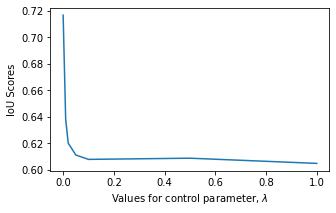

In [78]:
plt.figure(figsize=(5,3))
data_lists = sorted(data.items()) # sorted by key, return a list of tuples
a, b = zip(*data_lists) # unpack a list of pairs into two tuples
plt.plot(a, b)
# plt.xticks()
plt.xlabel(r"Values for control parameter, $\lambda$")
plt.ylabel("IoU Scores")
plt.show()

In [70]:
model

{1: 0.716891,
 2: 0.728579,
 4: 0.730903,
 5: 0.736565,
 7: 0.733455,
 9: 0.740759,
 12: 0.742283,
 15: 0.742457,
 18: 0.74571,
 20: 0.752879}

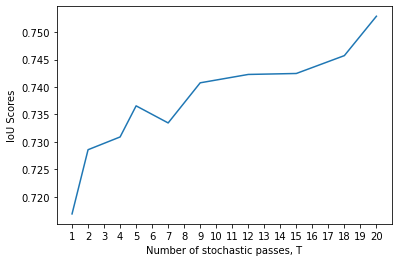

In [71]:
## test
import matplotlib.pyplot as plt

lists = sorted(model.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.xticks(range(1, 21))
plt.xlabel("Number of stochastic passes, T")
plt.ylabel("IoU Scores")
plt.show()

In [19]:
iou_mod = []

In [60]:
import pandas as pd
import numpy as np
val_dice = pd.read_csv("results/val_dice_model_unc_samp20.csv", header=None)
val_iou = pd.read_csv("results/val_iou_model_unc_samp20.csv", header=None)

In [61]:
## samp2

print(max(val_iou[0]))
print(val_dice[0][val_iou.idxmax()])

0.70606
18    0.989112
Name: 0, dtype: float64


In [62]:
iou_mod.append(max(val_iou[0]))

In [63]:
iou_mod

[0.716891,
 0.728579,
 0.730903,
 0.736565,
 0.733455,
 0.740759,
 0.742283,
 0.742457,
 0.732581,
 0.70606]

In [64]:
key = [1,2,4,5,7,9,12,15,18,20]

In [65]:
model = {}
for i in range(len(key)):
    model[key[i]] = iou_mod[i]

In [66]:
model

{1: 0.716891,
 2: 0.728579,
 4: 0.730903,
 5: 0.736565,
 7: 0.733455,
 9: 0.740759,
 12: 0.742283,
 15: 0.742457,
 18: 0.732581,
 20: 0.70606}

In [93]:
data = torch.load("/DATA/shraddha/BS_Thesis/paper_experiments/data_unc_results/unet_data_unc_0.5.pt")

In [20]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img = torch.empty(488,1,128,128)
pred = torch.empty(488,2,128,128)
true = torch.empty(488,1,128,128)
prec = 0
rec = 0
spec = 0
f1 = 0
dice_sc = 0
iou_sc = 0
counts = 0
with torch.autocast(device.type if device.type != 'cuda' else 'cpu'):
    for batch in tqdm(dataset_test, total=len(dataset_test)):
        # print(batch)
        image, mask_true = batch[0], batch[1]
        print(image.shape)
        image = torch.unsqueeze(image, dim=0)
        mask_true = torch.unsqueeze(mask_true, dim=0)
            # move images and labels to correct device and type
        image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
        # img[counts] = image
        mask_true = mask_true.to(device=device, dtype=torch.long)
        # true[counts] = mask_true
        with torch.no_grad():
            mask_pred, mask_var = data(image)
            # mask_pred2 = model(image)

            # pred[counts] = mask_pred
          #  var_pred = torch.add(torch.add(torch.add(torch.add(torch.add(torch.add(torch.add(torch.add(torch.square(torch.sub(mask_pred1,mask_pred)), torch.square(torch.sub(mask_pred2,mask_pred))), torch.square(torch.sub(mask_pred3,mask_pred))),torch.square(torch.sub(mask_pred4,mask_pred))),torch.square(torch.sub(mask_pred5,mask_pred))),torch.square(torch.sub(mask_pred6,mask_pred))), torch.square(torch.sub(mask_pred7,mask_pred))),torch.square(torch.sub(mask_pred8,mask_pred))),torch.square(torch.sub(mask_pred9,mask_pred)))/5
         #   var_m, var_ind = torch.max(var_pred, axis = 1)
            # print(mask_var.shape)
           # var[counts] = mask_var + var_m
            # var[counts] = torch.var(pred[counts])
            prec += precision(mask_pred, mask_true.squeeze(1).long())
            rec += recall(mask_pred, mask_true.squeeze(1).long())
            spec += specificity(mask_pred, mask_true.squeeze(1).long())
            f1 += f1_sc(mask_pred, mask_true.squeeze(1).long())
            dice_sc += dice(mask_pred, mask_true.squeeze(1).long())
            # dice_sc.append(dice(mask_pred, mask_true.squeeze(1).long()))
            iou_sc += Iou(mask_pred, mask_true.squeeze(1).long())
            counts +=1

prec_score = prec/counts
rec_score = rec/counts
spec_score = spec/counts
dice_score = dice_sc/counts
iou_score = iou_sc/counts
f1_score = f1/counts

  0%|          | 0/241 [00:00<?, ?it/s]

torch.Size([1, 128, 128])


NameError: name 'data' is not defined

In [73]:
## UNet Test set 0.01
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_score)
print(dice_score)
print(iou_score)

tensor(0.6992, device='cuda:0')
tensor(0.8120, device='cuda:0')
tensor(0.8120, device='cuda:0')
tensor(0.7194, device='cuda:0')
tensor(0.9869, device='cuda:0')
tensor(0.6624, device='cuda:0')


In [79]:
## UNet Test set 0.02
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_score)
print(dice_score)
print(iou_score)

tensor(0.7017, device='cuda:0')
tensor(0.7959, device='cuda:0')
tensor(0.7959, device='cuda:0')
tensor(0.7178, device='cuda:0')
tensor(0.9874, device='cuda:0')
tensor(0.6648, device='cuda:0')


In [84]:
## UNet Test set 0.05
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_score)
print(dice_score)
print(iou_score)

tensor(0.6968, device='cuda:0')
tensor(0.8344, device='cuda:0')
tensor(0.8344, device='cuda:0')
tensor(0.7219, device='cuda:0')
tensor(0.9855, device='cuda:0')
tensor(0.6635, device='cuda:0')


In [90]:
## UNet Test set 0.1
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_score)
print(dice_score)
print(iou_score)

tensor(0.6851, device='cuda:0')
tensor(0.8469, device='cuda:0')
tensor(0.8469, device='cuda:0')
tensor(0.7138, device='cuda:0')
tensor(0.9836, device='cuda:0')
tensor(0.6546, device='cuda:0')


In [95]:
## UNet Test set 0.5
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_score)
print(dice_score)
print(iou_score)

tensor(0.7478, device='cuda:0')
tensor(0.7755, device='cuda:0')
tensor(0.7755, device='cuda:0')
tensor(0.7411, device='cuda:0')
tensor(0.9913, device='cuda:0')
tensor(0.6858, device='cuda:0')


In [4]:
key_val = [0, 0.01, 0.02, 0.05, 0.1, 0.5, 1]

In [5]:
iou_data = []

In [10]:
val_iou = pd.read_csv("results/val_iou_model_unc_samp1.csv", header=None)
print(max(val_iou[0]))
print([val_iou.idxmax()])

0.716891
[0    325
dtype: int64]


In [35]:
import pandas as pd
import numpy as np
# val_dice = pd.read_csv("results/val_dice_model_unc_samp20.csv", header=None)
val_iou = pd.read_csv("data_unc_results/val_iou_data_unc_0.01.csv", header=None)
print(max(val_iou[0]))
print([val_iou.idxmax()])

0.612119
[0    209
dtype: int64]


In [36]:
import pandas as pd
import numpy as np
# val_dice = pd.read_csv("results/val_dice_model_unc_samp20.csv", header=None)
val_iou = pd.read_csv("data_unc_results/val_iou_data_unc_0.02.csv", header=None)
print(max(val_iou[0]))
print([val_iou.idxmax()])

0.620188
[0    191
dtype: int64]


In [29]:
iou_data.append(max(val_iou[0]))

In [30]:
iou_data

[0.716891, 0.612119, 0.620188, 0.611193, 0.609777, 0.608792, 0.605797]

In [31]:
data = {}
for i in range(len(key_val)):
    data[key_val[i]] = iou_data[i]

In [32]:
data

{0: 0.716891,
 0.01: 0.612119,
 0.02: 0.620188,
 0.05: 0.611193,
 0.1: 0.609777,
 0.5: 0.608792,
 1: 0.605797}

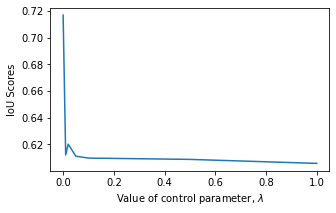

In [34]:
## test
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))

# plt.subplot(1,2,1)
lists = sorted(data.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
# plt.xticks([2,4,6,8,10,12,14,16,18,20])
plt.xlabel("Value of control parameter, $\lambda$")
plt.ylabel("IoU Scores")
plt.show()

In [87]:
iou_data[0] = 0.6653688

In [40]:
## with argmax
f1

[tensor(0.9429, device='cuda:0'),
 tensor(0.9324, device='cuda:0'),
 tensor(0.9091, device='cuda:0'),
 tensor(0.7952, device='cuda:0'),
 tensor(0.9557, device='cuda:0'),
 tensor(0.8706, device='cuda:0'),
 tensor(0.8085, device='cuda:0'),
 tensor(0.8743, device='cuda:0'),
 tensor(0.9072, device='cuda:0'),
 tensor(0.9282, device='cuda:0'),
 tensor(0.8000, device='cuda:0'),
 tensor(0.8545, device='cuda:0'),
 tensor(0.7917, device='cuda:0'),
 tensor(0.8725, device='cuda:0'),
 tensor(0.9434, device='cuda:0'),
 tensor(0.9518, device='cuda:0'),
 tensor(0.9273, device='cuda:0'),
 tensor(0.9761, device='cuda:0'),
 tensor(0.8393, device='cuda:0'),
 tensor(0.5996, device='cuda:0'),
 tensor(0.9564, device='cuda:0'),
 tensor(0.8625, device='cuda:0'),
 tensor(0.9588, device='cuda:0'),
 tensor(0.9585, device='cuda:0'),
 tensor(0.8804, device='cuda:0'),
 tensor(0.9663, device='cuda:0'),
 tensor(0.5273, device='cuda:0'),
 tensor(0.9644, device='cuda:0'),
 tensor(0.8675, device='cuda:0'),
 tensor(0.5200

In [10]:
## classes=2
f1

[tensor(0.9711, device='cuda:0'),
 tensor(0.9658, device='cuda:0'),
 tensor(0.9538, device='cuda:0'),
 tensor(0.8973, device='cuda:0'),
 tensor(0.9777, device='cuda:0'),
 tensor(0.9351, device='cuda:0'),
 tensor(0.9040, device='cuda:0'),
 tensor(0.9368, device='cuda:0'),
 tensor(0.9535, device='cuda:0'),
 tensor(0.9639, device='cuda:0'),
 tensor(0.8998, device='cuda:0'),
 tensor(0.9270, device='cuda:0'),
 tensor(0.8952, device='cuda:0'),
 tensor(0.9359, device='cuda:0'),
 tensor(0.9710, device='cuda:0'),
 tensor(0.9754, device='cuda:0'),
 tensor(0.9632, device='cuda:0'),
 tensor(0.9878, device='cuda:0'),
 tensor(0.9185, device='cuda:0'),
 tensor(0.7967, device='cuda:0'),
 tensor(0.9778, device='cuda:0'),
 tensor(0.9303, device='cuda:0'),
 tensor(0.9790, device='cuda:0'),
 tensor(0.9788, device='cuda:0'),
 tensor(0.9391, device='cuda:0'),
 tensor(0.9828, device='cuda:0'),
 tensor(0.7583, device='cuda:0'),
 tensor(0.9820, device='cuda:0'),
 tensor(0.9324, device='cuda:0'),
 tensor(0.7528

In [11]:
dice_sc

[tensor(0.9988, device='cuda:0'),
 tensor(0.9982, device='cuda:0'),
 tensor(0.9973, device='cuda:0'),
 tensor(0.9990, device='cuda:0'),
 tensor(0.9995, device='cuda:0'),
 tensor(0.9993, device='cuda:0'),
 tensor(0.9989, device='cuda:0'),
 tensor(0.9987, device='cuda:0'),
 tensor(0.9995, device='cuda:0'),
 tensor(0.9992, device='cuda:0'),
 tensor(0.9992, device='cuda:0'),
 tensor(0.9990, device='cuda:0'),
 tensor(0.9976, device='cuda:0'),
 tensor(0.9984, device='cuda:0'),
 tensor(0.9974, device='cuda:0'),
 tensor(0.9980, device='cuda:0'),
 tensor(0.9982, device='cuda:0'),
 tensor(0.9991, device='cuda:0'),
 tensor(0.9956, device='cuda:0'),
 tensor(0.9876, device='cuda:0'),
 tensor(0.9984, device='cuda:0'),
 tensor(0.9964, device='cuda:0'),
 tensor(0.9984, device='cuda:0'),
 tensor(0.9984, device='cuda:0'),
 tensor(0.9956, device='cuda:0'),
 tensor(0.9987, device='cuda:0'),
 tensor(0.9789, device='cuda:0'),
 tensor(0.9991, device='cuda:0'),
 tensor(0.9949, device='cuda:0'),
 tensor(0.9722

In [12]:
imgs = np.clip((np.load(os.path.join('/DATA/shraddha/brain-tumor-segmentation-unet/brain_tumor_dataset/images.npy'))/12728),0,1)
mask = np.load(os.path.join('/DATA/shraddha/brain-tumor-segmentation-unet/brain_tumor_dataset/masks.npy'))
        # pid = np.load(os.path.join(root, 'pids.npy'))

In [15]:
data_var

tensor([[[[ 4.7987e+30,  4.8183e-02,  6.1206e+31,  ...,  6.7422e+22,
            1.9810e+34,  5.3603e-02],
          [ 1.4245e+13,  1.8179e+31,  7.3463e+28,  ...,  1.8169e+31,
            4.4726e+21,  4.4633e+30],
          [ 1.1259e+24,  4.7921e-02,  7.5570e+31,  ...,  4.9079e-02,
            7.8981e+34,  5.0695e-02],
          ...,
          [-6.4495e+19,  4.8248e-02, -3.1023e+32,  ...,  4.6405e-02,
           -3.1023e+32,  4.9212e-02],
          [-6.4502e+19,  4.6178e-02, -3.1023e+32,  ...,  4.9774e-02,
           -3.1023e+32,  4.9114e-02],
          [-6.4565e+19,  5.0511e-02, -3.5384e+32,  ...,  4.7905e-02,
           -3.1023e+32,  5.1025e-02]]],


        [[[-8.8727e+32,  4.9959e-02, -8.8727e+32,  ...,  6.7422e+22,
            1.9810e+34,  4.7407e-02],
          [ 1.4245e+13,  1.8179e+31,  7.3463e+28,  ...,  1.8169e+31,
            4.4726e+21,  4.4633e+30],
          [ 1.1259e+24,  4.5336e-02,  7.5570e+31,  ...,  4.6357e-02,
            7.8981e+34,  4.7063e-02],
          ...,
   

In [18]:
img.shape

torch.Size([488, 1, 128, 128])

In [8]:
var_d.min()

tensor(3.8283e-27, device='cuda:0')

In [9]:
var_d.max()

tensor(0.1780, device='cuda:0')

In [17]:
# model = torch.load("/DATA/shraddha/BS_Thesis/paper_experiments/results/unet_model_unc_samp20.pt")
model = torch.load("/DATA/shraddha/BS_Thesis/paper_experiments/data_model_results/unet_data_model_unc_0.01_20_upd.pt")
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img = torch.empty(241,1,128,128)
pred = torch.empty(241,2,128,128)
true = torch.empty(241,1,128,128)
model_var = torch.empty(241,1,128,128)
data_var = torch.empty(241,1,128,128)
prec = 0
rec = 0
spec = 0
f1 = 0
dice_sc = 0
iou_sc = 0
counts = 0
samples=20
with torch.autocast(device.type if device.type != 'cuda' else 'cpu'):
    for batch in tqdm(dataset_test, total=len(dataset_test)):

        # print(batch)
        image, mask_true = batch[0], batch[1]
        # print(mask_true.shape)
        # pred = torch.empty(241,2,128,128).to(device=device)
        # var = torch.empty(241,1,128,128).to(device=device)
        image = torch.unsqueeze(image, dim=0)
        mask_true = torch.unsqueeze(mask_true, dim=0)
            # move images and labels to correct device and type
        image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
        img[counts] = image
        mask_true = mask_true.to(device=device, dtype=torch.long)
        true[counts] = mask_true
        mask_pred = torch.empty(mask_true.shape[0],2,128,128).to(device=device)
        var_pred_data = torch.empty(mask_true.shape[0],1,128,128).to(device=device)
        pred_model = torch.empty(20,mask_true.shape[0],2,128,128).to(device=device)
        var_data = torch.empty(20,mask_true.shape[0],1,128,128).to(device=device)
            # var_p = torch.empty(mask_true.shape[0],1,128,128).to(device=device)
        with torch.no_grad():
            for s in range(samples):
                mask_p, var_d = model(image)
                pred_model[s] = mask_p
                var_data[s] = var_d
                # print(var_d.min())
                # print(var_d.max())
                mask_pred += mask_p
                var_pred_data += var_d/samples
            # mask_pred2 = model(image)
            
            pred[counts] = mask_pred/samples
            data_var[counts] = var_pred_data
            var_pred = torch.var(pred_model, dim=0)
            var_model, var_ind = torch.max(var_pred, axis = 1)
            model_var[counts] = var_model
           #  var_pred = torch.add(torch.add(torch.add(torch.add(torch.add(torch.add(torch.add(torch.add(torch.square(torch.sub(mask_pred1,mask_pred)), torch.square(torch.sub(mask_pred2,mask_pred))), torch.square(torch.sub(mask_pred3,mask_pred))),torch.square(torch.sub(mask_pred4,mask_pred))),torch.square(torch.sub(mask_pred5,mask_pred))),torch.square(torch.sub(mask_pred6,mask_pred))), torch.square(torch.sub(mask_pred7,mask_pred))),torch.square(torch.sub(mask_pred8,mask_pred))),torch.square(torch.sub(mask_pred9,mask_pred)))/5
         #   var_m, var_ind = torch.max(var_pred, axis = 1)
            # print(mask_var.shape)
           # var[counts] = mask_var + var_m
            # var[counts] = torch.var(pred[counts])
            prec += precision(mask_pred, mask_true.squeeze(1).long())
            rec += recall(mask_pred, mask_true.squeeze(1).long())
            spec += specificity(mask_pred, mask_true.squeeze(1).long())
            f1 += f1_sc(mask_pred, mask_true.squeeze(1).long())
            dice_sc += dice(mask_pred, mask_true.squeeze(1).long())
            # dice_sc.append(dice(mask_pred, mask_true.squeeze(1).long()))
            iou_sc += Iou(mask_pred, mask_true.squeeze(1).long())
            counts +=1

prec_score = prec/counts
rec_score = rec/counts
spec_score = spec/counts
dice_score = dice_sc/counts
iou_score = iou_sc/counts
f1_score = f1/counts

  0%|          | 1/241 [00:00<00:27,  8.78it/s]

tensor(8.0539e-11, device='cuda:0')
tensor(0.1758, device='cuda:0')
tensor(5.4774e-11, device='cuda:0')
tensor(0.2080, device='cuda:0')
tensor(2.1423e-10, device='cuda:0')
tensor(0.1770, device='cuda:0')
tensor(3.2052e-10, device='cuda:0')
tensor(0.1803, device='cuda:0')
tensor(5.3966e-11, device='cuda:0')
tensor(0.1906, device='cuda:0')
tensor(8.9921e-11, device='cuda:0')
tensor(0.1881, device='cuda:0')
tensor(8.1885e-11, device='cuda:0')
tensor(0.2303, device='cuda:0')
tensor(6.4569e-11, device='cuda:0')
tensor(0.1781, device='cuda:0')
tensor(8.7390e-11, device='cuda:0')
tensor(0.1876, device='cuda:0')
tensor(1.2250e-10, device='cuda:0')
tensor(0.1919, device='cuda:0')
tensor(9.2139e-11, device='cuda:0')
tensor(0.2032, device='cuda:0')
tensor(2.4864e-11, device='cuda:0')
tensor(0.1656, device='cuda:0')
tensor(2.2326e-10, device='cuda:0')
tensor(0.1705, device='cuda:0')
tensor(2.9399e-10, device='cuda:0')
tensor(0.1739, device='cuda:0')
tensor(6.3099e-11, device='cuda:0')
tensor(0.224

  1%|          | 3/241 [00:00<00:26,  9.13it/s]

tensor(4.3277e-12, device='cuda:0')
tensor(0.2344, device='cuda:0')
tensor(3.1288e-12, device='cuda:0')
tensor(0.1695, device='cuda:0')
tensor(9.2720e-10, device='cuda:0')
tensor(0.1645, device='cuda:0')
tensor(9.1323e-10, device='cuda:0')
tensor(0.1916, device='cuda:0')
tensor(7.2137e-10, device='cuda:0')
tensor(0.1683, device='cuda:0')
tensor(5.3340e-10, device='cuda:0')
tensor(0.1670, device='cuda:0')
tensor(1.3165e-10, device='cuda:0')
tensor(0.1823, device='cuda:0')
tensor(2.6376e-10, device='cuda:0')
tensor(0.1722, device='cuda:0')
tensor(1.0362e-09, device='cuda:0')
tensor(0.1984, device='cuda:0')
tensor(1.3551e-09, device='cuda:0')
tensor(0.2377, device='cuda:0')
tensor(2.3055e-09, device='cuda:0')
tensor(0.1959, device='cuda:0')
tensor(2.3146e-09, device='cuda:0')
tensor(0.2234, device='cuda:0')
tensor(1.0636e-09, device='cuda:0')
tensor(0.1793, device='cuda:0')
tensor(8.1324e-10, device='cuda:0')
tensor(0.1974, device='cuda:0')
tensor(2.5259e-09, device='cuda:0')
tensor(0.180

  2%|▏         | 5/241 [00:00<00:24,  9.45it/s]

tensor(5.5348e-13, device='cuda:0')
tensor(0.2091, device='cuda:0')
tensor(3.0599e-13, device='cuda:0')
tensor(0.1797, device='cuda:0')
tensor(1.3993e-12, device='cuda:0')
tensor(0.2935, device='cuda:0')
tensor(6.5863e-13, device='cuda:0')
tensor(0.1699, device='cuda:0')
tensor(5.1501e-21, device='cuda:0')
tensor(0.2223, device='cuda:0')
tensor(7.7010e-17, device='cuda:0')
tensor(0.2065, device='cuda:0')
tensor(1.4245e-20, device='cuda:0')
tensor(0.1781, device='cuda:0')
tensor(8.8468e-13, device='cuda:0')
tensor(0.1878, device='cuda:0')
tensor(3.1143e-21, device='cuda:0')
tensor(0.1941, device='cuda:0')
tensor(1.8424e-20, device='cuda:0')
tensor(0.1828, device='cuda:0')
tensor(2.0237e-17, device='cuda:0')
tensor(0.1685, device='cuda:0')
tensor(1.0300e-17, device='cuda:0')
tensor(0.1730, device='cuda:0')
tensor(3.5110e-16, device='cuda:0')
tensor(0.1682, device='cuda:0')
tensor(5.8526e-20, device='cuda:0')
tensor(0.1731, device='cuda:0')
tensor(2.4671e-19, device='cuda:0')
tensor(0.172

  3%|▎         | 7/241 [00:00<00:24,  9.50it/s]

tensor(8.4167e-18, device='cuda:0')
tensor(0.1698, device='cuda:0')
tensor(4.1362e-22, device='cuda:0')
tensor(0.1821, device='cuda:0')
tensor(5.4547e-20, device='cuda:0')
tensor(0.1786, device='cuda:0')
tensor(3.4884e-21, device='cuda:0')
tensor(0.1776, device='cuda:0')
tensor(2.5475e-29, device='cuda:0')
tensor(0.1951, device='cuda:0')
tensor(5.0323e-14, device='cuda:0')
tensor(0.2028, device='cuda:0')
tensor(1.7374e-16, device='cuda:0')
tensor(0.1770, device='cuda:0')
tensor(1.4402e-13, device='cuda:0')
tensor(0.1716, device='cuda:0')
tensor(8.2756e-15, device='cuda:0')
tensor(0.1794, device='cuda:0')
tensor(2.4353e-15, device='cuda:0')
tensor(0.1882, device='cuda:0')
tensor(4.1610e-14, device='cuda:0')
tensor(0.2176, device='cuda:0')
tensor(1.1618e-13, device='cuda:0')
tensor(0.1948, device='cuda:0')
tensor(4.9663e-16, device='cuda:0')
tensor(0.1771, device='cuda:0')
tensor(1.4448e-13, device='cuda:0')
tensor(0.1917, device='cuda:0')
tensor(1.3038e-14, device='cuda:0')
tensor(0.182

  4%|▎         | 9/241 [00:00<00:24,  9.55it/s]

tensor(1.1327e-25, device='cuda:0')
tensor(0.1949, device='cuda:0')
tensor(3.2758e-21, device='cuda:0')
tensor(0.2085, device='cuda:0')
tensor(1.0708e-17, device='cuda:0')
tensor(0.1858, device='cuda:0')
tensor(1.3104e-23, device='cuda:0')
tensor(0.1966, device='cuda:0')
tensor(1.3075e-20, device='cuda:0')
tensor(0.1863, device='cuda:0')
tensor(8.5749e-26, device='cuda:0')
tensor(0.1889, device='cuda:0')
tensor(2.1470e-17, device='cuda:0')
tensor(0.1938, device='cuda:0')
tensor(2.0897e-19, device='cuda:0')
tensor(0.2175, device='cuda:0')
tensor(3.7875e-16, device='cuda:0')
tensor(0.1765, device='cuda:0')
tensor(2.2101e-22, device='cuda:0')
tensor(0.1760, device='cuda:0')
tensor(7.1794e-18, device='cuda:0')
tensor(0.1888, device='cuda:0')
tensor(9.2770e-19, device='cuda:0')
tensor(0.1882, device='cuda:0')
tensor(2.1174e-17, device='cuda:0')
tensor(0.2319, device='cuda:0')
tensor(4.2858e-21, device='cuda:0')
tensor(0.1612, device='cuda:0')
tensor(8.9959e-21, device='cuda:0')
tensor(0.184

  5%|▍         | 11/241 [00:01<00:24,  9.56it/s]

tensor(9.4803e-10, device='cuda:0')
tensor(0.1808, device='cuda:0')
tensor(3.3461e-09, device='cuda:0')
tensor(0.2103, device='cuda:0')
tensor(1.1355e-09, device='cuda:0')
tensor(0.1972, device='cuda:0')
tensor(5.4961e-10, device='cuda:0')
tensor(0.1970, device='cuda:0')
tensor(1.9501e-09, device='cuda:0')
tensor(0.1879, device='cuda:0')
tensor(1.1930e-09, device='cuda:0')
tensor(0.2124, device='cuda:0')
tensor(1.6968e-09, device='cuda:0')
tensor(0.1991, device='cuda:0')
tensor(2.4130e-19, device='cuda:0')
tensor(0.1942, device='cuda:0')
tensor(1.5954e-19, device='cuda:0')
tensor(0.1988, device='cuda:0')
tensor(2.3819e-21, device='cuda:0')
tensor(0.2138, device='cuda:0')
tensor(8.4095e-20, device='cuda:0')
tensor(0.1883, device='cuda:0')
tensor(9.9297e-27, device='cuda:0')
tensor(0.2072, device='cuda:0')
tensor(9.3332e-22, device='cuda:0')
tensor(0.1784, device='cuda:0')
tensor(1.2517e-20, device='cuda:0')
tensor(0.1788, device='cuda:0')
tensor(1.8066e-21, device='cuda:0')
tensor(0.191

  5%|▌         | 13/241 [00:01<00:23,  9.55it/s]

tensor(2.4469e-10, device='cuda:0')
tensor(0.1806, device='cuda:0')
tensor(3.1570e-10, device='cuda:0')
tensor(0.1806, device='cuda:0')
tensor(6.6162e-10, device='cuda:0')
tensor(0.1604, device='cuda:0')
tensor(3.2999e-10, device='cuda:0')
tensor(0.1959, device='cuda:0')
tensor(1.7331e-09, device='cuda:0')
tensor(0.1735, device='cuda:0')
tensor(6.5636e-10, device='cuda:0')
tensor(0.1841, device='cuda:0')
tensor(6.6148e-10, device='cuda:0')
tensor(0.1807, device='cuda:0')
tensor(6.9107e-10, device='cuda:0')
tensor(0.1723, device='cuda:0')
tensor(9.1340e-10, device='cuda:0')
tensor(0.2172, device='cuda:0')
tensor(3.4794e-10, device='cuda:0')
tensor(0.1751, device='cuda:0')
tensor(1.1381e-09, device='cuda:0')
tensor(0.1650, device='cuda:0')
tensor(2.0484e-10, device='cuda:0')
tensor(0.1711, device='cuda:0')
tensor(1.6664e-10, device='cuda:0')
tensor(0.1584, device='cuda:0')
tensor(1.5660e-09, device='cuda:0')
tensor(0.1713, device='cuda:0')
tensor(1.0747e-09, device='cuda:0')
tensor(0.235

  6%|▌         | 15/241 [00:01<00:23,  9.56it/s]

tensor(1.3521e-08, device='cuda:0')
tensor(0.1647, device='cuda:0')
tensor(3.0080e-09, device='cuda:0')
tensor(0.1681, device='cuda:0')
tensor(7.8656e-09, device='cuda:0')
tensor(0.1950, device='cuda:0')
tensor(4.7288e-09, device='cuda:0')
tensor(0.1957, device='cuda:0')
tensor(2.9930e-09, device='cuda:0')
tensor(0.1702, device='cuda:0')
tensor(3.3379e-09, device='cuda:0')
tensor(0.1684, device='cuda:0')
tensor(7.8313e-09, device='cuda:0')
tensor(0.1648, device='cuda:0')
tensor(8.3352e-09, device='cuda:0')
tensor(0.1801, device='cuda:0')
tensor(8.3822e-09, device='cuda:0')
tensor(0.1615, device='cuda:0')
tensor(1.7997e-10, device='cuda:0')
tensor(0.1957, device='cuda:0')
tensor(6.6889e-11, device='cuda:0')
tensor(0.2083, device='cuda:0')
tensor(7.2364e-11, device='cuda:0')
tensor(0.2156, device='cuda:0')
tensor(2.5236e-11, device='cuda:0')
tensor(0.1793, device='cuda:0')
tensor(1.3562e-11, device='cuda:0')
tensor(0.1764, device='cuda:0')
tensor(1.1067e-12, device='cuda:0')
tensor(0.172

  7%|▋         | 17/241 [00:01<00:23,  9.56it/s]

tensor(7.7834e-13, device='cuda:0')
tensor(0.2013, device='cuda:0')
tensor(1.5054e-12, device='cuda:0')
tensor(0.1894, device='cuda:0')
tensor(5.9460e-13, device='cuda:0')
tensor(0.1653, device='cuda:0')
tensor(1.2872e-11, device='cuda:0')
tensor(0.2183, device='cuda:0')
tensor(5.3431e-13, device='cuda:0')
tensor(0.1836, device='cuda:0')
tensor(7.1434e-13, device='cuda:0')
tensor(0.1820, device='cuda:0')
tensor(5.1526e-12, device='cuda:0')
tensor(0.1612, device='cuda:0')
tensor(1.9077e-11, device='cuda:0')
tensor(0.1739, device='cuda:0')
tensor(2.7151e-12, device='cuda:0')
tensor(0.1660, device='cuda:0')
tensor(4.9848e-12, device='cuda:0')
tensor(0.1810, device='cuda:0')
tensor(4.1012e-10, device='cuda:0')
tensor(0.2073, device='cuda:0')
tensor(4.1478e-10, device='cuda:0')
tensor(0.2107, device='cuda:0')
tensor(1.3922e-10, device='cuda:0')
tensor(0.2097, device='cuda:0')
tensor(8.1494e-10, device='cuda:0')
tensor(0.1693, device='cuda:0')
tensor(7.9574e-10, device='cuda:0')
tensor(0.200

  8%|▊         | 19/241 [00:02<00:23,  9.56it/s]

tensor(1.1982e-10, device='cuda:0')
tensor(0.1943, device='cuda:0')
tensor(2.4196e-10, device='cuda:0')
tensor(0.2077, device='cuda:0')
tensor(2.2264e-11, device='cuda:0')
tensor(0.1978, device='cuda:0')
tensor(2.2096e-10, device='cuda:0')
tensor(0.2048, device='cuda:0')
tensor(1.1327e-09, device='cuda:0')
tensor(0.1710, device='cuda:0')
tensor(6.2699e-10, device='cuda:0')
tensor(0.1778, device='cuda:0')
tensor(2.4560e-10, device='cuda:0')
tensor(0.2278, device='cuda:0')
tensor(5.1829e-10, device='cuda:0')
tensor(0.1713, device='cuda:0')
tensor(1.8088e-10, device='cuda:0')
tensor(0.1867, device='cuda:0')
tensor(6.7897e-10, device='cuda:0')
tensor(0.2074, device='cuda:0')
tensor(9.5696e-10, device='cuda:0')
tensor(0.1720, device='cuda:0')
tensor(1.1025e-17, device='cuda:0')
tensor(0.1833, device='cuda:0')
tensor(9.3601e-18, device='cuda:0')
tensor(0.1912, device='cuda:0')
tensor(1.1220e-17, device='cuda:0')
tensor(0.1764, device='cuda:0')
tensor(6.1514e-18, device='cuda:0')
tensor(0.201

  9%|▊         | 21/241 [00:02<00:22,  9.60it/s]

tensor(3.3466e-09, device='cuda:0')
tensor(0.2415, device='cuda:0')
tensor(3.5582e-09, device='cuda:0')
tensor(0.2098, device='cuda:0')
tensor(3.3156e-09, device='cuda:0')
tensor(0.1860, device='cuda:0')
tensor(3.1917e-09, device='cuda:0')
tensor(0.1819, device='cuda:0')
tensor(1.6972e-09, device='cuda:0')
tensor(0.1916, device='cuda:0')
tensor(2.0914e-09, device='cuda:0')
tensor(0.1884, device='cuda:0')
tensor(1.8078e-09, device='cuda:0')
tensor(0.2087, device='cuda:0')
tensor(3.2947e-09, device='cuda:0')
tensor(0.2319, device='cuda:0')
tensor(4.5174e-09, device='cuda:0')
tensor(0.2029, device='cuda:0')
tensor(4.1835e-09, device='cuda:0')
tensor(0.1875, device='cuda:0')
tensor(7.9281e-09, device='cuda:0')
tensor(0.1969, device='cuda:0')
tensor(5.3116e-09, device='cuda:0')
tensor(0.2007, device='cuda:0')
tensor(9.2440e-11, device='cuda:0')
tensor(0.2114, device='cuda:0')
tensor(2.1261e-10, device='cuda:0')
tensor(0.1768, device='cuda:0')
tensor(1.1283e-10, device='cuda:0')
tensor(0.201

 10%|▉         | 23/241 [00:02<00:22,  9.57it/s]

tensor(1.7902e-08, device='cuda:0')
tensor(0.1868, device='cuda:0')
tensor(7.8726e-09, device='cuda:0')
tensor(0.1622, device='cuda:0')
tensor(1.2398e-08, device='cuda:0')
tensor(0.1673, device='cuda:0')
tensor(1.2206e-08, device='cuda:0')
tensor(0.1792, device='cuda:0')
tensor(2.6357e-09, device='cuda:0')
tensor(0.1899, device='cuda:0')
tensor(1.1366e-08, device='cuda:0')
tensor(0.1702, device='cuda:0')
tensor(3.4989e-09, device='cuda:0')
tensor(0.1757, device='cuda:0')
tensor(1.5615e-09, device='cuda:0')
tensor(0.1637, device='cuda:0')
tensor(1.6654e-09, device='cuda:0')
tensor(0.1776, device='cuda:0')
tensor(6.9135e-09, device='cuda:0')
tensor(0.1744, device='cuda:0')
tensor(7.0100e-09, device='cuda:0')
tensor(0.1874, device='cuda:0')
tensor(6.5442e-09, device='cuda:0')
tensor(0.1659, device='cuda:0')
tensor(9.8953e-10, device='cuda:0')
tensor(0.1900, device='cuda:0')
tensor(9.4360e-10, device='cuda:0')
tensor(0.2076, device='cuda:0')
tensor(2.2738e-10, device='cuda:0')
tensor(0.212

 10%|█         | 25/241 [00:02<00:22,  9.58it/s]

tensor(5.8861e-14, device='cuda:0')
tensor(0.1937, device='cuda:0')
tensor(7.2337e-13, device='cuda:0')
tensor(0.2323, device='cuda:0')
tensor(4.1528e-14, device='cuda:0')
tensor(0.2036, device='cuda:0')
tensor(8.7266e-14, device='cuda:0')
tensor(0.2028, device='cuda:0')
tensor(6.2334e-14, device='cuda:0')
tensor(0.2158, device='cuda:0')
tensor(8.8563e-14, device='cuda:0')
tensor(0.2043, device='cuda:0')
tensor(4.0999e-14, device='cuda:0')
tensor(0.2159, device='cuda:0')
tensor(1.1344e-12, device='cuda:0')
tensor(0.1614, device='cuda:0')
tensor(1.6981e-13, device='cuda:0')
tensor(0.1862, device='cuda:0')
tensor(5.1644e-14, device='cuda:0')
tensor(0.1745, device='cuda:0')
tensor(6.5739e-14, device='cuda:0')
tensor(0.1963, device='cuda:0')
tensor(1.5855e-13, device='cuda:0')
tensor(0.1842, device='cuda:0')
tensor(5.6561e-14, device='cuda:0')
tensor(0.1964, device='cuda:0')
tensor(1.0385e-12, device='cuda:0')
tensor(0.1711, device='cuda:0')
tensor(6.2194e-23, device='cuda:0')
tensor(0.190

 11%|█         | 27/241 [00:02<00:22,  9.56it/s]

tensor(7.0672e-17, device='cuda:0')
tensor(0.1759, device='cuda:0')
tensor(2.6215e-16, device='cuda:0')
tensor(0.1715, device='cuda:0')
tensor(2.1697e-18, device='cuda:0')
tensor(0.2596, device='cuda:0')
tensor(1.8113e-18, device='cuda:0')
tensor(0.1693, device='cuda:0')
tensor(1.5960e-17, device='cuda:0')
tensor(0.1796, device='cuda:0')
tensor(3.5421e-17, device='cuda:0')
tensor(0.1849, device='cuda:0')
tensor(2.6027e-17, device='cuda:0')
tensor(0.2025, device='cuda:0')
tensor(2.0668e-17, device='cuda:0')
tensor(0.2090, device='cuda:0')
tensor(1.3747e-16, device='cuda:0')
tensor(0.1732, device='cuda:0')
tensor(2.6844e-17, device='cuda:0')
tensor(0.1685, device='cuda:0')
tensor(9.2033e-18, device='cuda:0')
tensor(0.1719, device='cuda:0')
tensor(3.7817e-17, device='cuda:0')
tensor(0.1652, device='cuda:0')
tensor(4.6332e-16, device='cuda:0')
tensor(0.1747, device='cuda:0')
tensor(1.2536e-17, device='cuda:0')
tensor(0.1683, device='cuda:0')
tensor(1.2065e-16, device='cuda:0')
tensor(0.252

 12%|█▏        | 29/241 [00:03<00:22,  9.59it/s]

tensor(2.3244e-23, device='cuda:0')
tensor(0.1720, device='cuda:0')
tensor(7.6192e-25, device='cuda:0')
tensor(0.2079, device='cuda:0')
tensor(2.7619e-23, device='cuda:0')
tensor(0.1769, device='cuda:0')
tensor(9.7425e-25, device='cuda:0')
tensor(0.2171, device='cuda:0')
tensor(1.0274e-22, device='cuda:0')
tensor(0.1868, device='cuda:0')
tensor(1.2984e-26, device='cuda:0')
tensor(0.2046, device='cuda:0')
tensor(1.5885e-22, device='cuda:0')
tensor(0.1880, device='cuda:0')
tensor(8.9769e-27, device='cuda:0')
tensor(0.1741, device='cuda:0')
tensor(2.6671e-27, device='cuda:0')
tensor(0.1755, device='cuda:0')
tensor(2.8270e-25, device='cuda:0')
tensor(0.1845, device='cuda:0')
tensor(2.0351e-25, device='cuda:0')
tensor(0.1745, device='cuda:0')
tensor(1.5633e-22, device='cuda:0')
tensor(0.1889, device='cuda:0')
tensor(7.0659e-24, device='cuda:0')
tensor(0.2005, device='cuda:0')
tensor(1.1893e-24, device='cuda:0')
tensor(0.2014, device='cuda:0')
tensor(1.0166e-23, device='cuda:0')
tensor(0.182

 13%|█▎        | 31/241 [00:03<00:21,  9.59it/s]

tensor(2.0952e-11, device='cuda:0')
tensor(0.1863, device='cuda:0')
tensor(3.7070e-19, device='cuda:0')
tensor(0.1647, device='cuda:0')
tensor(2.7873e-14, device='cuda:0')
tensor(0.1682, device='cuda:0')
tensor(2.7611e-18, device='cuda:0')
tensor(0.1770, device='cuda:0')
tensor(2.0981e-16, device='cuda:0')
tensor(0.1813, device='cuda:0')
tensor(2.3136e-15, device='cuda:0')
tensor(0.1705, device='cuda:0')
tensor(7.1487e-10, device='cuda:0')
tensor(0.1680, device='cuda:0')
tensor(1.1305e-14, device='cuda:0')
tensor(0.1980, device='cuda:0')
tensor(2.0776e-23, device='cuda:0')
tensor(0.2163, device='cuda:0')
tensor(4.8856e-20, device='cuda:0')
tensor(0.1630, device='cuda:0')
tensor(9.5699e-16, device='cuda:0')
tensor(0.1642, device='cuda:0')
tensor(1.1837e-17, device='cuda:0')
tensor(0.1894, device='cuda:0')
tensor(4.9493e-20, device='cuda:0')
tensor(0.2175, device='cuda:0')
tensor(1.8898e-13, device='cuda:0')
tensor(0.1644, device='cuda:0')
tensor(4.5175e-15, device='cuda:0')
tensor(0.171

 14%|█▎        | 33/241 [00:03<00:21,  9.61it/s]

tensor(3.7600e-18, device='cuda:0')
tensor(0.1929, device='cuda:0')
tensor(1.9235e-16, device='cuda:0')
tensor(0.1876, device='cuda:0')
tensor(2.0633e-10, device='cuda:0')
tensor(0.1869, device='cuda:0')
tensor(8.1977e-13, device='cuda:0')
tensor(0.2143, device='cuda:0')
tensor(1.3389e-23, device='cuda:0')
tensor(0.2043, device='cuda:0')
tensor(3.1942e-11, device='cuda:0')
tensor(0.1623, device='cuda:0')
tensor(4.1396e-19, device='cuda:0')
tensor(0.1789, device='cuda:0')
tensor(4.2408e-21, device='cuda:0')
tensor(0.1764, device='cuda:0')
tensor(3.9882e-11, device='cuda:0')
tensor(0.1763, device='cuda:0')
tensor(1.6218e-13, device='cuda:0')
tensor(0.1774, device='cuda:0')
tensor(1.2412e-19, device='cuda:0')
tensor(0.1812, device='cuda:0')
tensor(3.6445e-13, device='cuda:0')
tensor(0.1796, device='cuda:0')
tensor(2.1464e-25, device='cuda:0')
tensor(0.2130, device='cuda:0')
tensor(1.0065e-18, device='cuda:0')
tensor(0.1652, device='cuda:0')
tensor(8.4479e-24, device='cuda:0')
tensor(0.180

 15%|█▍        | 35/241 [00:03<00:21,  9.56it/s]

tensor(8.3762e-28, device='cuda:0')
tensor(0.2136, device='cuda:0')
tensor(5.9762e-20, device='cuda:0')
tensor(0.1877, device='cuda:0')
tensor(2.4317e-22, device='cuda:0')
tensor(0.1862, device='cuda:0')
tensor(3.1053e-22, device='cuda:0')
tensor(0.1907, device='cuda:0')
tensor(1.7200e-26, device='cuda:0')
tensor(0.1941, device='cuda:0')
tensor(6.2658e-23, device='cuda:0')
tensor(0.1867, device='cuda:0')
tensor(2.0765e-17, device='cuda:0')
tensor(0.1963, device='cuda:0')
tensor(3.1626e-25, device='cuda:0')
tensor(0.1919, device='cuda:0')
tensor(3.7457e-27, device='cuda:0')
tensor(0.2005, device='cuda:0')
tensor(2.6809e-22, device='cuda:0')
tensor(0.1974, device='cuda:0')
tensor(1.8852e-24, device='cuda:0')
tensor(0.1871, device='cuda:0')
tensor(1.4771e-25, device='cuda:0')
tensor(0.2186, device='cuda:0')
tensor(3.8350e-26, device='cuda:0')
tensor(0.1905, device='cuda:0')
tensor(4.4103e-25, device='cuda:0')
tensor(0.2090, device='cuda:0')
tensor(3.5843e-22, device='cuda:0')
tensor(0.201

 15%|█▍        | 36/241 [00:03<00:21,  9.58it/s]

tensor(2.0564e-23, device='cuda:0')
tensor(0.1943, device='cuda:0')
tensor(2.7155e-18, device='cuda:0')
tensor(0.1864, device='cuda:0')
tensor(1.7175e-10, device='cuda:0')
tensor(0.1856, device='cuda:0')
tensor(8.5214e-17, device='cuda:0')
tensor(0.1916, device='cuda:0')
tensor(5.6791e-21, device='cuda:0')
tensor(0.2201, device='cuda:0')
tensor(2.5623e-21, device='cuda:0')
tensor(0.2264, device='cuda:0')
tensor(1.0434e-15, device='cuda:0')
tensor(0.1829, device='cuda:0')
tensor(4.1782e-22, device='cuda:0')
tensor(0.2104, device='cuda:0')
tensor(3.5694e-20, device='cuda:0')
tensor(0.1731, device='cuda:0')
tensor(8.6017e-19, device='cuda:0')
tensor(0.1843, device='cuda:0')
tensor(2.0097e-19, device='cuda:0')
tensor(0.1982, device='cuda:0')
tensor(3.1938e-25, device='cuda:0')
tensor(0.1683, device='cuda:0')
tensor(9.6808e-19, device='cuda:0')
tensor(0.1871, device='cuda:0')
tensor(1.4802e-19, device='cuda:0')
tensor(0.1946, device='cuda:0')
tensor(4.5242e-19, device='cuda:0')
tensor(0.226

 16%|█▌        | 38/241 [00:03<00:21,  9.57it/s]

tensor(1.4131e-16, device='cuda:0')
tensor(0.1841, device='cuda:0')
tensor(4.6459e-16, device='cuda:0')
tensor(0.1975, device='cuda:0')
tensor(5.5073e-15, device='cuda:0')
tensor(0.1806, device='cuda:0')
tensor(2.4459e-14, device='cuda:0')
tensor(0.1924, device='cuda:0')
tensor(1.8273e-15, device='cuda:0')
tensor(0.1847, device='cuda:0')
tensor(8.0743e-16, device='cuda:0')
tensor(0.1943, device='cuda:0')
tensor(1.8037e-14, device='cuda:0')
tensor(0.2388, device='cuda:0')
tensor(1.8645e-15, device='cuda:0')
tensor(0.1955, device='cuda:0')
tensor(2.8433e-17, device='cuda:0')
tensor(0.1975, device='cuda:0')
tensor(3.4819e-14, device='cuda:0')
tensor(0.1918, device='cuda:0')
tensor(1.8865e-15, device='cuda:0')
tensor(0.2015, device='cuda:0')
tensor(8.0374e-15, device='cuda:0')
tensor(0.2120, device='cuda:0')
tensor(1.1126e-15, device='cuda:0')
tensor(0.1770, device='cuda:0')
tensor(2.5895e-16, device='cuda:0')
tensor(0.2107, device='cuda:0')
tensor(2.7914e-15, device='cuda:0')
tensor(0.208

 17%|█▋        | 40/241 [00:04<00:20,  9.57it/s]

tensor(5.5362e-20, device='cuda:0')
tensor(0.2097, device='cuda:0')
tensor(1.3268e-20, device='cuda:0')
tensor(0.1907, device='cuda:0')
tensor(8.5371e-22, device='cuda:0')
tensor(0.1777, device='cuda:0')
tensor(2.8395e-20, device='cuda:0')
tensor(0.1872, device='cuda:0')
tensor(1.6555e-20, device='cuda:0')
tensor(0.1770, device='cuda:0')
tensor(1.4579e-23, device='cuda:0')
tensor(0.1748, device='cuda:0')
tensor(1.8727e-20, device='cuda:0')
tensor(0.1912, device='cuda:0')
tensor(4.5958e-20, device='cuda:0')
tensor(0.1876, device='cuda:0')
tensor(9.1373e-21, device='cuda:0')
tensor(0.2175, device='cuda:0')
tensor(1.7644e-19, device='cuda:0')
tensor(0.2108, device='cuda:0')
tensor(4.4487e-19, device='cuda:0')
tensor(0.2171, device='cuda:0')
tensor(1.7886e-22, device='cuda:0')
tensor(0.1800, device='cuda:0')
tensor(1.8981e-21, device='cuda:0')
tensor(0.1857, device='cuda:0')
tensor(6.7250e-21, device='cuda:0')
tensor(0.1786, device='cuda:0')
tensor(1.6470e-21, device='cuda:0')
tensor(0.230

 17%|█▋        | 42/241 [00:04<00:21,  9.35it/s]

tensor(1.4856e-22, device='cuda:0')
tensor(0.1873, device='cuda:0')
tensor(1.1914e-18, device='cuda:0')
tensor(0.2278, device='cuda:0')
tensor(2.2418e-22, device='cuda:0')
tensor(0.1987, device='cuda:0')
tensor(6.4383e-24, device='cuda:0')
tensor(0.1867, device='cuda:0')
tensor(6.7544e-23, device='cuda:0')
tensor(0.2247, device='cuda:0')
tensor(4.3207e-22, device='cuda:0')
tensor(0.1791, device='cuda:0')
tensor(4.6086e-21, device='cuda:0')
tensor(0.1854, device='cuda:0')
tensor(2.4081e-18, device='cuda:0')
tensor(0.2137, device='cuda:0')
tensor(2.0077e-21, device='cuda:0')
tensor(0.2375, device='cuda:0')
tensor(8.2248e-23, device='cuda:0')
tensor(0.1835, device='cuda:0')
tensor(3.6303e-21, device='cuda:0')
tensor(0.1836, device='cuda:0')
tensor(5.3242e-18, device='cuda:0')
tensor(0.1934, device='cuda:0')
tensor(1.0821e-20, device='cuda:0')
tensor(0.1897, device='cuda:0')
tensor(2.7409e-23, device='cuda:0')
tensor(0.2213, device='cuda:0')
tensor(8.3219e-19, device='cuda:0')
tensor(0.191

 18%|█▊        | 44/241 [00:04<00:21,  9.06it/s]

tensor(3.4561e-22, device='cuda:0')
tensor(0.2188, device='cuda:0')
tensor(1.0407e-20, device='cuda:0')
tensor(0.2052, device='cuda:0')
tensor(1.9046e-19, device='cuda:0')
tensor(0.1958, device='cuda:0')
tensor(1.7743e-22, device='cuda:0')
tensor(0.1822, device='cuda:0')
tensor(6.4539e-19, device='cuda:0')
tensor(0.2312, device='cuda:0')
tensor(6.0350e-16, device='cuda:0')
tensor(0.2061, device='cuda:0')
tensor(4.0766e-16, device='cuda:0')
tensor(0.1931, device='cuda:0')
tensor(8.9594e-19, device='cuda:0')
tensor(0.2227, device='cuda:0')
tensor(1.2689e-19, device='cuda:0')
tensor(0.1972, device='cuda:0')
tensor(1.5088e-18, device='cuda:0')
tensor(0.1982, device='cuda:0')
tensor(1.1198e-20, device='cuda:0')
tensor(0.1975, device='cuda:0')
tensor(8.6999e-18, device='cuda:0')
tensor(0.2052, device='cuda:0')
tensor(4.4833e-16, device='cuda:0')
tensor(0.2023, device='cuda:0')
tensor(1.4441e-17, device='cuda:0')
tensor(0.2231, device='cuda:0')
tensor(8.8527e-19, device='cuda:0')
tensor(0.199

 19%|█▉        | 46/241 [00:04<00:20,  9.37it/s]

tensor(2.0679e-21, device='cuda:0')
tensor(0.1736, device='cuda:0')
tensor(9.0013e-21, device='cuda:0')
tensor(0.1788, device='cuda:0')
tensor(2.4545e-21, device='cuda:0')
tensor(0.2871, device='cuda:0')
tensor(2.1224e-15, device='cuda:0')
tensor(0.2071, device='cuda:0')
tensor(8.0031e-21, device='cuda:0')
tensor(0.1891, device='cuda:0')
tensor(1.0383e-20, device='cuda:0')
tensor(0.1943, device='cuda:0')
tensor(8.1458e-19, device='cuda:0')
tensor(0.2047, device='cuda:0')
tensor(2.8961e-18, device='cuda:0')
tensor(0.2304, device='cuda:0')
tensor(4.9511e-17, device='cuda:0')
tensor(0.1784, device='cuda:0')
tensor(1.1875e-20, device='cuda:0')
tensor(0.1768, device='cuda:0')
tensor(7.0256e-18, device='cuda:0')
tensor(0.2367, device='cuda:0')
tensor(1.1206e-18, device='cuda:0')
tensor(0.2043, device='cuda:0')
tensor(4.4046e-19, device='cuda:0')
tensor(0.1969, device='cuda:0')
tensor(9.1985e-19, device='cuda:0')
tensor(0.1949, device='cuda:0')
tensor(2.1953e-20, device='cuda:0')
tensor(0.183

 20%|█▉        | 48/241 [00:05<00:20,  9.41it/s]

tensor(5.9292e-21, device='cuda:0')
tensor(0.2089, device='cuda:0')
tensor(1.3888e-20, device='cuda:0')
tensor(0.2441, device='cuda:0')
tensor(2.9091e-18, device='cuda:0')
tensor(0.2116, device='cuda:0')
tensor(2.0243e-18, device='cuda:0')
tensor(0.2256, device='cuda:0')
tensor(6.1907e-21, device='cuda:0')
tensor(0.1765, device='cuda:0')
tensor(3.1449e-19, device='cuda:0')
tensor(0.1810, device='cuda:0')
tensor(1.2008e-21, device='cuda:0')
tensor(0.2037, device='cuda:0')
tensor(2.7392e-18, device='cuda:0')
tensor(0.2039, device='cuda:0')
tensor(9.6084e-20, device='cuda:0')
tensor(0.1937, device='cuda:0')
tensor(1.6064e-20, device='cuda:0')
tensor(0.2204, device='cuda:0')
tensor(4.6475e-22, device='cuda:0')
tensor(0.2060, device='cuda:0')
tensor(2.5696e-19, device='cuda:0')
tensor(0.1909, device='cuda:0')
tensor(9.4356e-18, device='cuda:0')
tensor(0.2110, device='cuda:0')
tensor(7.2517e-19, device='cuda:0')
tensor(0.1890, device='cuda:0')
tensor(2.9648e-21, device='cuda:0')
tensor(0.196

 21%|██        | 50/241 [00:05<00:20,  9.45it/s]

tensor(8.1205e-25, device='cuda:0')
tensor(0.1901, device='cuda:0')
tensor(1.6708e-24, device='cuda:0')
tensor(0.1823, device='cuda:0')
tensor(1.3169e-24, device='cuda:0')
tensor(0.2019, device='cuda:0')
tensor(1.6162e-22, device='cuda:0')
tensor(0.1806, device='cuda:0')
tensor(8.9127e-22, device='cuda:0')
tensor(0.1950, device='cuda:0')
tensor(1.4987e-25, device='cuda:0')
tensor(0.2384, device='cuda:0')
tensor(4.2042e-25, device='cuda:0')
tensor(0.2027, device='cuda:0')
tensor(5.9396e-25, device='cuda:0')
tensor(0.1896, device='cuda:0')
tensor(1.2917e-22, device='cuda:0')
tensor(0.1919, device='cuda:0')
tensor(4.1034e-23, device='cuda:0')
tensor(0.1946, device='cuda:0')
tensor(7.6850e-18, device='cuda:0')
tensor(0.1990, device='cuda:0')
tensor(5.9346e-15, device='cuda:0')
tensor(0.2025, device='cuda:0')
tensor(2.7520e-17, device='cuda:0')
tensor(0.2027, device='cuda:0')
tensor(5.1910e-19, device='cuda:0')
tensor(0.1897, device='cuda:0')
tensor(1.7714e-17, device='cuda:0')
tensor(0.189

 22%|██▏       | 52/241 [00:05<00:19,  9.52it/s]

tensor(0.1888, device='cuda:0')
tensor(1.6255e-20, device='cuda:0')
tensor(0.1909, device='cuda:0')
tensor(3.6403e-19, device='cuda:0')
tensor(0.1773, device='cuda:0')
tensor(1.4114e-18, device='cuda:0')
tensor(0.1911, device='cuda:0')
tensor(5.2921e-20, device='cuda:0')
tensor(0.2015, device='cuda:0')
tensor(3.3351e-17, device='cuda:0')
tensor(0.2063, device='cuda:0')
tensor(3.9220e-20, device='cuda:0')
tensor(0.1880, device='cuda:0')
tensor(2.5905e-18, device='cuda:0')
tensor(0.2250, device='cuda:0')
tensor(5.9451e-19, device='cuda:0')
tensor(0.1745, device='cuda:0')
tensor(4.3228e-18, device='cuda:0')
tensor(0.2153, device='cuda:0')
tensor(3.7286e-18, device='cuda:0')
tensor(0.2018, device='cuda:0')
tensor(2.9339e-18, device='cuda:0')
tensor(0.2188, device='cuda:0')
tensor(4.3215e-23, device='cuda:0')
tensor(0.2313, device='cuda:0')
tensor(7.2010e-17, device='cuda:0')
tensor(0.1710, device='cuda:0')
tensor(9.9174e-21, device='cuda:0')
tensor(0.2331, device='cuda:0')
tensor(3.1791e-2

 22%|██▏       | 54/241 [00:05<00:19,  9.56it/s]

tensor(1.9479e-15, device='cuda:0')
tensor(0.1847, device='cuda:0')
tensor(1.0504e-15, device='cuda:0')
tensor(0.1708, device='cuda:0')
tensor(1.9333e-15, device='cuda:0')
tensor(0.1887, device='cuda:0')
tensor(3.3478e-15, device='cuda:0')
tensor(0.1686, device='cuda:0')
tensor(3.9184e-15, device='cuda:0')
tensor(0.1779, device='cuda:0')
tensor(4.2316e-14, device='cuda:0')
tensor(0.1841, device='cuda:0')
tensor(5.8052e-15, device='cuda:0')
tensor(0.1997, device='cuda:0')
tensor(1.5459e-14, device='cuda:0')
tensor(0.1643, device='cuda:0')
tensor(1.0201e-15, device='cuda:0')
tensor(0.1727, device='cuda:0')
tensor(1.9643e-14, device='cuda:0')
tensor(0.1869, device='cuda:0')
tensor(3.2407e-15, device='cuda:0')
tensor(0.1823, device='cuda:0')
tensor(3.3383e-16, device='cuda:0')
tensor(0.1767, device='cuda:0')
tensor(8.9493e-15, device='cuda:0')
tensor(0.2221, device='cuda:0')
tensor(6.5261e-20, device='cuda:0')
tensor(0.1670, device='cuda:0')
tensor(7.0933e-19, device='cuda:0')
tensor(0.188

 23%|██▎       | 56/241 [00:05<00:19,  9.61it/s]

tensor(6.1430e-14, device='cuda:0')
tensor(0.2086, device='cuda:0')
tensor(5.4162e-14, device='cuda:0')
tensor(0.1980, device='cuda:0')
tensor(8.4206e-14, device='cuda:0')
tensor(0.2178, device='cuda:0')
tensor(2.5465e-14, device='cuda:0')
tensor(0.1699, device='cuda:0')
tensor(1.8788e-13, device='cuda:0')
tensor(0.2470, device='cuda:0')
tensor(2.3165e-14, device='cuda:0')
tensor(0.2008, device='cuda:0')
tensor(5.6489e-14, device='cuda:0')
tensor(0.1861, device='cuda:0')
tensor(4.0382e-15, device='cuda:0')
tensor(0.1789, device='cuda:0')
tensor(5.7502e-15, device='cuda:0')
tensor(0.1816, device='cuda:0')
tensor(2.4282e-13, device='cuda:0')
tensor(0.1844, device='cuda:0')
tensor(3.9518e-13, device='cuda:0')
tensor(0.1843, device='cuda:0')
tensor(1.4005e-13, device='cuda:0')
tensor(0.2176, device='cuda:0')
tensor(1.3595e-13, device='cuda:0')
tensor(0.2367, device='cuda:0')
tensor(7.1753e-14, device='cuda:0')
tensor(0.1743, device='cuda:0')
tensor(1.1274e-14, device='cuda:0')
tensor(0.202

 24%|██▍       | 58/241 [00:06<00:19,  9.55it/s]

tensor(2.3376e-21, device='cuda:0')
tensor(0.1755, device='cuda:0')
tensor(7.4276e-21, device='cuda:0')
tensor(0.1750, device='cuda:0')
tensor(5.6863e-22, device='cuda:0')
tensor(0.1745, device='cuda:0')
tensor(5.3158e-22, device='cuda:0')
tensor(0.1883, device='cuda:0')
tensor(1.2466e-22, device='cuda:0')
tensor(0.1903, device='cuda:0')
tensor(4.3940e-24, device='cuda:0')
tensor(0.1876, device='cuda:0')
tensor(1.5328e-22, device='cuda:0')
tensor(0.1709, device='cuda:0')
tensor(1.7487e-18, device='cuda:0')
tensor(0.1782, device='cuda:0')
tensor(1.5061e-24, device='cuda:0')
tensor(0.1837, device='cuda:0')
tensor(4.8426e-20, device='cuda:0')
tensor(0.1779, device='cuda:0')
tensor(2.3134e-21, device='cuda:0')
tensor(0.1984, device='cuda:0')
tensor(6.9146e-20, device='cuda:0')
tensor(0.1954, device='cuda:0')
tensor(1.7078e-23, device='cuda:0')
tensor(0.1869, device='cuda:0')
tensor(3.1709e-24, device='cuda:0')
tensor(0.1799, device='cuda:0')
tensor(2.3185e-22, device='cuda:0')
tensor(0.186

 25%|██▍       | 60/241 [00:06<00:18,  9.57it/s]

tensor(0.1745, device='cuda:0')
tensor(9.6437e-20, device='cuda:0')
tensor(0.1968, device='cuda:0')
tensor(7.7168e-17, device='cuda:0')
tensor(0.2002, device='cuda:0')
tensor(5.1195e-19, device='cuda:0')
tensor(0.2210, device='cuda:0')
tensor(1.4328e-16, device='cuda:0')
tensor(0.1637, device='cuda:0')
tensor(6.4028e-18, device='cuda:0')
tensor(0.1912, device='cuda:0')
tensor(1.9169e-18, device='cuda:0')
tensor(0.1844, device='cuda:0')
tensor(6.5758e-18, device='cuda:0')
tensor(0.1902, device='cuda:0')
tensor(4.4392e-17, device='cuda:0')
tensor(0.1611, device='cuda:0')
tensor(1.2176e-17, device='cuda:0')
tensor(0.1695, device='cuda:0')
tensor(2.9763e-18, device='cuda:0')
tensor(0.1878, device='cuda:0')
tensor(3.4149e-18, device='cuda:0')
tensor(0.1675, device='cuda:0')
tensor(2.9765e-17, device='cuda:0')
tensor(0.1559, device='cuda:0')
tensor(3.5747e-16, device='cuda:0')
tensor(0.1739, device='cuda:0')
tensor(1.0897e-17, device='cuda:0')
tensor(0.1599, device='cuda:0')
tensor(6.2693e-1

 26%|██▌       | 62/241 [00:06<00:18,  9.58it/s]

tensor(4.2472e-20, device='cuda:0')
tensor(0.1947, device='cuda:0')
tensor(3.1494e-22, device='cuda:0')
tensor(0.2126, device='cuda:0')
tensor(3.9391e-23, device='cuda:0')
tensor(0.1889, device='cuda:0')
tensor(1.5900e-21, device='cuda:0')
tensor(0.1941, device='cuda:0')
tensor(7.6578e-25, device='cuda:0')
tensor(0.1710, device='cuda:0')
tensor(1.5295e-22, device='cuda:0')
tensor(0.1685, device='cuda:0')
tensor(5.9363e-25, device='cuda:0')
tensor(0.1810, device='cuda:0')
tensor(7.4258e-25, device='cuda:0')
tensor(0.1763, device='cuda:0')
tensor(8.3764e-22, device='cuda:0')
tensor(0.1854, device='cuda:0')
tensor(6.9362e-24, device='cuda:0')
tensor(0.1991, device='cuda:0')
tensor(1.5147e-21, device='cuda:0')
tensor(0.1657, device='cuda:0')
tensor(2.8116e-22, device='cuda:0')
tensor(0.1940, device='cuda:0')
tensor(1.0689e-23, device='cuda:0')
tensor(0.1955, device='cuda:0')
tensor(1.2132e-24, device='cuda:0')
tensor(0.1736, device='cuda:0')
tensor(1.9265e-22, device='cuda:0')
tensor(0.185

 27%|██▋       | 64/241 [00:06<00:18,  9.58it/s]

tensor(1.0162e-14, device='cuda:0')
tensor(0.2205, device='cuda:0')
tensor(6.8903e-14, device='cuda:0')
tensor(0.2152, device='cuda:0')
tensor(1.5966e-13, device='cuda:0')
tensor(0.2356, device='cuda:0')
tensor(6.7058e-13, device='cuda:0')
tensor(0.1837, device='cuda:0')
tensor(2.5961e-13, device='cuda:0')
tensor(0.1988, device='cuda:0')
tensor(2.4296e-13, device='cuda:0')
tensor(0.2034, device='cuda:0')
tensor(7.1989e-14, device='cuda:0')
tensor(0.1747, device='cuda:0')
tensor(3.8915e-14, device='cuda:0')
tensor(0.1997, device='cuda:0')
tensor(2.5918e-13, device='cuda:0')
tensor(0.2206, device='cuda:0')
tensor(1.1212e-14, device='cuda:0')
tensor(0.2056, device='cuda:0')
tensor(9.3935e-13, device='cuda:0')
tensor(0.2706, device='cuda:0')
tensor(1.2275e-13, device='cuda:0')
tensor(0.2386, device='cuda:0')
tensor(6.8252e-13, device='cuda:0')
tensor(0.1805, device='cuda:0')
tensor(2.5748e-13, device='cuda:0')
tensor(0.2153, device='cuda:0')
tensor(5.1422e-13, device='cuda:0')
tensor(0.208

 27%|██▋       | 65/241 [00:06<00:18,  9.59it/s]

tensor(1.5097e-14, device='cuda:0')
tensor(0.1650, device='cuda:0')
tensor(1.9301e-16, device='cuda:0')
tensor(0.1803, device='cuda:0')
tensor(7.5987e-15, device='cuda:0')
tensor(0.2025, device='cuda:0')
tensor(2.5204e-14, device='cuda:0')
tensor(0.1774, device='cuda:0')
tensor(1.3567e-13, device='cuda:0')
tensor(0.1667, device='cuda:0')
tensor(2.5391e-14, device='cuda:0')
tensor(0.1708, device='cuda:0')
tensor(1.2680e-17, device='cuda:0')
tensor(0.1934, device='cuda:0')
tensor(3.4717e-14, device='cuda:0')
tensor(0.1646, device='cuda:0')
tensor(1.7220e-13, device='cuda:0')
tensor(0.1826, device='cuda:0')
tensor(1.0799e-13, device='cuda:0')
tensor(0.1544, device='cuda:0')
tensor(1.8326e-14, device='cuda:0')
tensor(0.1780, device='cuda:0')
tensor(3.7723e-15, device='cuda:0')
tensor(0.2236, device='cuda:0')
tensor(1.4505e-16, device='cuda:0')
tensor(0.2127, device='cuda:0')
tensor(2.8697e-20, device='cuda:0')
tensor(0.1702, device='cuda:0')
tensor(7.2983e-15, device='cuda:0')
tensor(0.156

 28%|██▊       | 68/241 [00:07<00:17,  9.63it/s]

tensor(8.8054e-20, device='cuda:0')
tensor(0.1845, device='cuda:0')
tensor(8.1578e-25, device='cuda:0')
tensor(0.2034, device='cuda:0')
tensor(3.2184e-26, device='cuda:0')
tensor(0.1624, device='cuda:0')
tensor(2.6987e-28, device='cuda:0')
tensor(0.1744, device='cuda:0')
tensor(4.5172e-14, device='cuda:0')
tensor(0.1892, device='cuda:0')
tensor(2.9791e-10, device='cuda:0')
tensor(0.1963, device='cuda:0')
tensor(1.6931e-15, device='cuda:0')
tensor(0.1839, device='cuda:0')
tensor(5.2192e-28, device='cuda:0')
tensor(0.1892, device='cuda:0')
tensor(3.4640e-24, device='cuda:0')
tensor(0.1904, device='cuda:0')
tensor(1.0308e-19, device='cuda:0')
tensor(0.1864, device='cuda:0')
tensor(4.9138e-24, device='cuda:0')
tensor(0.2084, device='cuda:0')
tensor(1.4970e-19, device='cuda:0')
tensor(0.1960, device='cuda:0')
tensor(5.2779e-10, device='cuda:0')
tensor(0.1833, device='cuda:0')
tensor(1.2480e-27, device='cuda:0')
tensor(0.2489, device='cuda:0')
tensor(1.1027e-16, device='cuda:0')
tensor(0.174

 29%|██▊       | 69/241 [00:07<00:17,  9.61it/s]

tensor(1.3119e-14, device='cuda:0')
tensor(0.1701, device='cuda:0')
tensor(2.4432e-15, device='cuda:0')
tensor(0.1864, device='cuda:0')
tensor(7.2510e-15, device='cuda:0')
tensor(0.1843, device='cuda:0')
tensor(4.4982e-14, device='cuda:0')
tensor(0.1654, device='cuda:0')
tensor(1.6162e-13, device='cuda:0')
tensor(0.1813, device='cuda:0')
tensor(1.3153e-15, device='cuda:0')
tensor(0.2188, device='cuda:0')
tensor(8.5860e-14, device='cuda:0')
tensor(0.1754, device='cuda:0')
tensor(2.6057e-14, device='cuda:0')
tensor(0.1751, device='cuda:0')
tensor(2.4434e-14, device='cuda:0')
tensor(0.1730, device='cuda:0')
tensor(1.1996e-15, device='cuda:0')
tensor(0.1697, device='cuda:0')
tensor(1.2131e-13, device='cuda:0')
tensor(0.2050, device='cuda:0')
tensor(9.9310e-15, device='cuda:0')
tensor(0.1839, device='cuda:0')
tensor(5.0122e-14, device='cuda:0')
tensor(0.1798, device='cuda:0')
tensor(7.8575e-14, device='cuda:0')
tensor(0.1646, device='cuda:0')
tensor(1.4471e-15, device='cuda:0')
tensor(0.230

 29%|██▉       | 71/241 [00:07<00:17,  9.61it/s]

tensor(6.8366e-22, device='cuda:0')
tensor(0.2242, device='cuda:0')
tensor(1.2425e-20, device='cuda:0')
tensor(0.1850, device='cuda:0')
tensor(1.1718e-19, device='cuda:0')
tensor(0.2049, device='cuda:0')
tensor(4.2719e-17, device='cuda:0')
tensor(0.1734, device='cuda:0')
tensor(6.3179e-18, device='cuda:0')
tensor(0.1743, device='cuda:0')
tensor(7.2261e-24, device='cuda:0')
tensor(0.2156, device='cuda:0')
tensor(1.9654e-19, device='cuda:0')
tensor(0.1861, device='cuda:0')
tensor(1.8093e-18, device='cuda:0')
tensor(0.2273, device='cuda:0')
tensor(2.7393e-23, device='cuda:0')
tensor(0.2056, device='cuda:0')
tensor(2.5380e-20, device='cuda:0')
tensor(0.1775, device='cuda:0')
tensor(6.3725e-21, device='cuda:0')
tensor(0.2126, device='cuda:0')
tensor(1.6646e-22, device='cuda:0')
tensor(0.2131, device='cuda:0')
tensor(1.9723e-20, device='cuda:0')
tensor(0.2023, device='cuda:0')
tensor(1.2677e-16, device='cuda:0')
tensor(0.2152, device='cuda:0')
tensor(1.3242e-14, device='cuda:0')
tensor(0.205

 30%|███       | 73/241 [00:07<00:17,  9.56it/s]

tensor(2.4503e-16, device='cuda:0')
tensor(0.1727, device='cuda:0')
tensor(1.9077e-17, device='cuda:0')
tensor(0.1824, device='cuda:0')
tensor(4.2498e-18, device='cuda:0')
tensor(0.1706, device='cuda:0')
tensor(8.6319e-18, device='cuda:0')
tensor(0.1928, device='cuda:0')
tensor(1.5668e-16, device='cuda:0')
tensor(0.1852, device='cuda:0')
tensor(1.1466e-17, device='cuda:0')
tensor(0.1649, device='cuda:0')
tensor(1.6992e-16, device='cuda:0')
tensor(0.1668, device='cuda:0')
tensor(2.8381e-18, device='cuda:0')
tensor(0.1976, device='cuda:0')
tensor(1.2700e-20, device='cuda:0')
tensor(0.1723, device='cuda:0')
tensor(4.3382e-23, device='cuda:0')
tensor(0.1625, device='cuda:0')
tensor(2.2379e-16, device='cuda:0')
tensor(0.2048, device='cuda:0')
tensor(1.2182e-17, device='cuda:0')
tensor(0.1761, device='cuda:0')
tensor(3.5530e-18, device='cuda:0')
tensor(0.1748, device='cuda:0')
tensor(1.3556e-14, device='cuda:0')
tensor(0.1774, device='cuda:0')
tensor(6.3630e-21, device='cuda:0')
tensor(0.192

 31%|███       | 75/241 [00:07<00:17,  9.55it/s]

tensor(2.3995e-20, device='cuda:0')
tensor(0.1784, device='cuda:0')
tensor(5.4672e-17, device='cuda:0')
tensor(0.1964, device='cuda:0')
tensor(1.1512e-17, device='cuda:0')
tensor(0.1745, device='cuda:0')
tensor(1.8104e-19, device='cuda:0')
tensor(0.2044, device='cuda:0')
tensor(2.5066e-19, device='cuda:0')
tensor(0.1904, device='cuda:0')
tensor(6.0257e-21, device='cuda:0')
tensor(0.1932, device='cuda:0')
tensor(2.8266e-19, device='cuda:0')
tensor(0.1834, device='cuda:0')
tensor(5.9134e-18, device='cuda:0')
tensor(0.1715, device='cuda:0')
tensor(5.8148e-20, device='cuda:0')
tensor(0.1718, device='cuda:0')
tensor(2.1241e-20, device='cuda:0')
tensor(0.1806, device='cuda:0')
tensor(8.6910e-20, device='cuda:0')
tensor(0.1841, device='cuda:0')
tensor(1.8606e-20, device='cuda:0')
tensor(0.1829, device='cuda:0')
tensor(4.7557e-21, device='cuda:0')
tensor(0.2112, device='cuda:0')
tensor(2.5892e-19, device='cuda:0')
tensor(0.2048, device='cuda:0')
tensor(6.3476e-19, device='cuda:0')
tensor(0.176

 32%|███▏      | 77/241 [00:08<00:17,  9.58it/s]

tensor(5.0740e-16, device='cuda:0')
tensor(0.1831, device='cuda:0')
tensor(1.0725e-15, device='cuda:0')
tensor(0.1955, device='cuda:0')
tensor(2.4123e-16, device='cuda:0')
tensor(0.1867, device='cuda:0')
tensor(3.0666e-15, device='cuda:0')
tensor(0.2149, device='cuda:0')
tensor(9.0379e-16, device='cuda:0')
tensor(0.2160, device='cuda:0')
tensor(1.0113e-15, device='cuda:0')
tensor(0.2005, device='cuda:0')
tensor(7.6028e-17, device='cuda:0')
tensor(0.2048, device='cuda:0')
tensor(2.0798e-14, device='cuda:0')
tensor(0.1934, device='cuda:0')
tensor(7.7442e-16, device='cuda:0')
tensor(0.2395, device='cuda:0')
tensor(4.7313e-16, device='cuda:0')
tensor(0.1855, device='cuda:0')
tensor(4.4788e-15, device='cuda:0')
tensor(0.1842, device='cuda:0')
tensor(8.9390e-17, device='cuda:0')
tensor(0.2072, device='cuda:0')
tensor(1.4069e-16, device='cuda:0')
tensor(0.1944, device='cuda:0')
tensor(2.0709e-15, device='cuda:0')
tensor(0.2327, device='cuda:0')
tensor(4.6216e-15, device='cuda:0')
tensor(0.197

 33%|███▎      | 79/241 [00:08<00:16,  9.56it/s]

tensor(1.0153e-20, device='cuda:0')
tensor(0.1972, device='cuda:0')
tensor(5.6273e-23, device='cuda:0')
tensor(0.1850, device='cuda:0')
tensor(5.1467e-18, device='cuda:0')
tensor(0.1708, device='cuda:0')
tensor(1.5117e-16, device='cuda:0')
tensor(0.2015, device='cuda:0')
tensor(1.3969e-19, device='cuda:0')
tensor(0.2373, device='cuda:0')
tensor(2.0589e-14, device='cuda:0')
tensor(0.1984, device='cuda:0')
tensor(1.5830e-18, device='cuda:0')
tensor(0.1929, device='cuda:0')
tensor(2.2026e-12, device='cuda:0')
tensor(0.1800, device='cuda:0')
tensor(3.9324e-18, device='cuda:0')
tensor(0.1737, device='cuda:0')
tensor(7.6617e-18, device='cuda:0')
tensor(0.1698, device='cuda:0')
tensor(6.9446e-16, device='cuda:0')
tensor(0.1770, device='cuda:0')
tensor(7.3050e-17, device='cuda:0')
tensor(0.1821, device='cuda:0')
tensor(9.4240e-17, device='cuda:0')
tensor(0.1813, device='cuda:0')
tensor(1.7819e-18, device='cuda:0')
tensor(0.2317, device='cuda:0')
tensor(1.4982e-18, device='cuda:0')
tensor(0.214

 34%|███▎      | 81/241 [00:08<00:16,  9.59it/s]

tensor(3.4343e-15, device='cuda:0')
tensor(0.2168, device='cuda:0')
tensor(1.9465e-14, device='cuda:0')
tensor(0.1945, device='cuda:0')
tensor(2.1485e-20, device='cuda:0')
tensor(0.2396, device='cuda:0')
tensor(3.5104e-16, device='cuda:0')
tensor(0.1713, device='cuda:0')
tensor(7.3205e-17, device='cuda:0')
tensor(0.2162, device='cuda:0')
tensor(2.8495e-16, device='cuda:0')
tensor(0.1813, device='cuda:0')
tensor(1.0234e-15, device='cuda:0')
tensor(0.2417, device='cuda:0')
tensor(7.0964e-14, device='cuda:0')
tensor(0.2121, device='cuda:0')
tensor(4.8945e-17, device='cuda:0')
tensor(0.2001, device='cuda:0')
tensor(6.9214e-16, device='cuda:0')
tensor(0.2004, device='cuda:0')
tensor(1.0838e-17, device='cuda:0')
tensor(0.2283, device='cuda:0')
tensor(5.8927e-16, device='cuda:0')
tensor(0.2132, device='cuda:0')
tensor(7.6960e-18, device='cuda:0')
tensor(0.2003, device='cuda:0')
tensor(3.2973e-16, device='cuda:0')
tensor(0.1873, device='cuda:0')
tensor(1.9262e-14, device='cuda:0')
tensor(0.228

 34%|███▍      | 83/241 [00:08<00:16,  9.60it/s]

tensor(3.0517e-24, device='cuda:0')
tensor(0.2155, device='cuda:0')
tensor(4.6968e-22, device='cuda:0')
tensor(0.2067, device='cuda:0')
tensor(2.9216e-25, device='cuda:0')
tensor(0.2074, device='cuda:0')
tensor(2.8872e-21, device='cuda:0')
tensor(0.2225, device='cuda:0')
tensor(1.6030e-24, device='cuda:0')
tensor(0.2114, device='cuda:0')
tensor(3.2043e-24, device='cuda:0')
tensor(0.2102, device='cuda:0')
tensor(6.6738e-25, device='cuda:0')
tensor(0.2104, device='cuda:0')
tensor(7.8586e-25, device='cuda:0')
tensor(0.1755, device='cuda:0')
tensor(1.8672e-24, device='cuda:0')
tensor(0.1885, device='cuda:0')
tensor(9.6115e-25, device='cuda:0')
tensor(0.2254, device='cuda:0')
tensor(2.7328e-23, device='cuda:0')
tensor(0.1752, device='cuda:0')
tensor(4.7657e-23, device='cuda:0')
tensor(0.1928, device='cuda:0')
tensor(1.0967e-23, device='cuda:0')
tensor(0.2188, device='cuda:0')
tensor(3.0425e-24, device='cuda:0')
tensor(0.2218, device='cuda:0')
tensor(3.8194e-24, device='cuda:0')
tensor(0.235

 35%|███▌      | 85/241 [00:08<00:16,  9.60it/s]

tensor(7.3030e-27, device='cuda:0')
tensor(0.1955, device='cuda:0')
tensor(3.0041e-28, device='cuda:0')
tensor(0.1879, device='cuda:0')
tensor(3.3847e-26, device='cuda:0')
tensor(0.2273, device='cuda:0')
tensor(2.8465e-27, device='cuda:0')
tensor(0.2312, device='cuda:0')
tensor(3.9069e-25, device='cuda:0')
tensor(0.1962, device='cuda:0')
tensor(1.6850e-24, device='cuda:0')
tensor(0.1881, device='cuda:0')
tensor(2.5708e-26, device='cuda:0')
tensor(0.1909, device='cuda:0')
tensor(6.4919e-26, device='cuda:0')
tensor(0.2136, device='cuda:0')
tensor(2.2284e-28, device='cuda:0')
tensor(0.1803, device='cuda:0')
tensor(1.3179e-26, device='cuda:0')
tensor(0.1831, device='cuda:0')
tensor(3.2683e-27, device='cuda:0')
tensor(0.2218, device='cuda:0')
tensor(1.6173e-27, device='cuda:0')
tensor(0.2105, device='cuda:0')
tensor(7.4179e-27, device='cuda:0')
tensor(0.2006, device='cuda:0')
tensor(4.4748e-24, device='cuda:0')
tensor(0.1917, device='cuda:0')
tensor(6.0960e-25, device='cuda:0')
tensor(0.196

 36%|███▌      | 87/241 [00:09<00:16,  9.57it/s]

tensor(3.0756e-24, device='cuda:0')
tensor(0.1918, device='cuda:0')
tensor(8.0007e-24, device='cuda:0')
tensor(0.1974, device='cuda:0')
tensor(3.2215e-21, device='cuda:0')
tensor(0.1811, device='cuda:0')
tensor(5.1690e-23, device='cuda:0')
tensor(0.1788, device='cuda:0')
tensor(1.0033e-24, device='cuda:0')
tensor(0.1819, device='cuda:0')
tensor(1.5044e-23, device='cuda:0')
tensor(0.1817, device='cuda:0')
tensor(3.6910e-24, device='cuda:0')
tensor(0.1825, device='cuda:0')
tensor(1.8518e-24, device='cuda:0')
tensor(0.2148, device='cuda:0')
tensor(3.2001e-24, device='cuda:0')
tensor(0.1778, device='cuda:0')
tensor(3.1032e-21, device='cuda:0')
tensor(0.2144, device='cuda:0')
tensor(4.7530e-21, device='cuda:0')
tensor(0.1834, device='cuda:0')
tensor(2.1160e-20, device='cuda:0')
tensor(0.1876, device='cuda:0')
tensor(1.4460e-25, device='cuda:0')
tensor(0.1776, device='cuda:0')
tensor(9.0348e-21, device='cuda:0')
tensor(0.1894, device='cuda:0')
tensor(5.7575e-23, device='cuda:0')
tensor(0.202

 37%|███▋      | 89/241 [00:09<00:15,  9.51it/s]

tensor(1.2197e-21, device='cuda:0')
tensor(0.2505, device='cuda:0')
tensor(2.9792e-22, device='cuda:0')
tensor(0.2792, device='cuda:0')
tensor(4.9863e-21, device='cuda:0')
tensor(0.2379, device='cuda:0')
tensor(1.1103e-21, device='cuda:0')
tensor(0.2566, device='cuda:0')
tensor(9.2663e-21, device='cuda:0')
tensor(0.2511, device='cuda:0')
tensor(9.1455e-23, device='cuda:0')
tensor(0.2137, device='cuda:0')
tensor(1.7713e-21, device='cuda:0')
tensor(0.2803, device='cuda:0')
tensor(1.2051e-22, device='cuda:0')
tensor(0.2319, device='cuda:0')
tensor(4.3578e-21, device='cuda:0')
tensor(0.2267, device='cuda:0')
tensor(1.1970e-20, device='cuda:0')
tensor(0.2381, device='cuda:0')
tensor(4.6413e-22, device='cuda:0')
tensor(0.2407, device='cuda:0')
tensor(8.5080e-23, device='cuda:0')
tensor(0.2264, device='cuda:0')
tensor(7.9775e-22, device='cuda:0')
tensor(0.2189, device='cuda:0')
tensor(9.8369e-23, device='cuda:0')
tensor(0.2711, device='cuda:0')
tensor(2.2274e-22, device='cuda:0')
tensor(0.217

 38%|███▊      | 91/241 [00:09<00:15,  9.57it/s]

tensor(3.5000e-18, device='cuda:0')
tensor(0.2040, device='cuda:0')
tensor(3.3451e-18, device='cuda:0')
tensor(0.1727, device='cuda:0')
tensor(1.4403e-19, device='cuda:0')
tensor(0.1739, device='cuda:0')
tensor(1.2349e-20, device='cuda:0')
tensor(0.1873, device='cuda:0')
tensor(1.2076e-19, device='cuda:0')
tensor(0.2190, device='cuda:0')
tensor(7.5679e-21, device='cuda:0')
tensor(0.2009, device='cuda:0')
tensor(3.2914e-19, device='cuda:0')
tensor(0.1683, device='cuda:0')
tensor(1.4116e-22, device='cuda:0')
tensor(0.1994, device='cuda:0')
tensor(8.9708e-21, device='cuda:0')
tensor(0.2034, device='cuda:0')
tensor(7.2259e-18, device='cuda:0')
tensor(0.1671, device='cuda:0')
tensor(5.4436e-20, device='cuda:0')
tensor(0.1923, device='cuda:0')
tensor(3.1341e-20, device='cuda:0')
tensor(0.1817, device='cuda:0')
tensor(1.9565e-21, device='cuda:0')
tensor(0.2051, device='cuda:0')
tensor(3.2415e-21, device='cuda:0')
tensor(0.1917, device='cuda:0')
tensor(1.0178e-16, device='cuda:0')
tensor(0.175

 39%|███▊      | 93/241 [00:09<00:15,  9.59it/s]

tensor(3.9392e-16, device='cuda:0')
tensor(0.1842, device='cuda:0')
tensor(1.5318e-13, device='cuda:0')
tensor(0.1888, device='cuda:0')
tensor(3.3579e-15, device='cuda:0')
tensor(0.2060, device='cuda:0')
tensor(2.8600e-15, device='cuda:0')
tensor(0.2003, device='cuda:0')
tensor(4.0944e-15, device='cuda:0')
tensor(0.1903, device='cuda:0')
tensor(9.6138e-14, device='cuda:0')
tensor(0.1849, device='cuda:0')
tensor(8.5886e-15, device='cuda:0')
tensor(0.1955, device='cuda:0')
tensor(1.4937e-14, device='cuda:0')
tensor(0.1892, device='cuda:0')
tensor(6.7058e-14, device='cuda:0')
tensor(0.1823, device='cuda:0')
tensor(5.6521e-14, device='cuda:0')
tensor(0.1977, device='cuda:0')
tensor(1.1378e-14, device='cuda:0')
tensor(0.1970, device='cuda:0')
tensor(3.2247e-13, device='cuda:0')
tensor(0.2228, device='cuda:0')
tensor(5.8003e-15, device='cuda:0')
tensor(0.2032, device='cuda:0')
tensor(3.8820e-15, device='cuda:0')
tensor(0.1815, device='cuda:0')
tensor(1.5399e-14, device='cuda:0')
tensor(0.186

 39%|███▉      | 95/241 [00:09<00:15,  9.63it/s]

tensor(2.6678e-12, device='cuda:0')
tensor(0.2163, device='cuda:0')
tensor(2.7186e-12, device='cuda:0')
tensor(0.2030, device='cuda:0')
tensor(8.3670e-12, device='cuda:0')
tensor(0.1790, device='cuda:0')
tensor(6.2391e-12, device='cuda:0')
tensor(0.1888, device='cuda:0')
tensor(8.0101e-12, device='cuda:0')
tensor(0.1943, device='cuda:0')
tensor(1.2426e-12, device='cuda:0')
tensor(0.2154, device='cuda:0')
tensor(3.2710e-12, device='cuda:0')
tensor(0.1848, device='cuda:0')
tensor(2.3238e-12, device='cuda:0')
tensor(0.1959, device='cuda:0')
tensor(3.1514e-12, device='cuda:0')
tensor(0.1755, device='cuda:0')
tensor(2.0180e-12, device='cuda:0')
tensor(0.1945, device='cuda:0')
tensor(1.5033e-12, device='cuda:0')
tensor(0.2119, device='cuda:0')
tensor(9.0381e-12, device='cuda:0')
tensor(0.1805, device='cuda:0')
tensor(2.0951e-12, device='cuda:0')
tensor(0.1742, device='cuda:0')
tensor(1.2244e-11, device='cuda:0')
tensor(0.1951, device='cuda:0')
tensor(4.5824e-13, device='cuda:0')
tensor(0.177

 40%|████      | 97/241 [00:10<00:15,  9.04it/s]

tensor(1.2627e-17, device='cuda:0')
tensor(0.1838, device='cuda:0')
tensor(1.3002e-17, device='cuda:0')
tensor(0.1937, device='cuda:0')
tensor(1.8307e-17, device='cuda:0')
tensor(0.1742, device='cuda:0')
tensor(1.9386e-17, device='cuda:0')
tensor(0.2086, device='cuda:0')
tensor(2.1243e-17, device='cuda:0')
tensor(0.1957, device='cuda:0')
tensor(1.0236e-15, device='cuda:0')
tensor(0.1853, device='cuda:0')
tensor(9.8018e-17, device='cuda:0')
tensor(0.1848, device='cuda:0')
tensor(2.3784e-17, device='cuda:0')
tensor(0.2141, device='cuda:0')
tensor(6.6208e-18, device='cuda:0')
tensor(0.1827, device='cuda:0')
tensor(1.9853e-18, device='cuda:0')
tensor(0.1655, device='cuda:0')
tensor(1.0302e-17, device='cuda:0')
tensor(0.2046, device='cuda:0')
tensor(1.2248e-17, device='cuda:0')
tensor(0.1891, device='cuda:0')
tensor(6.0741e-18, device='cuda:0')
tensor(0.2262, device='cuda:0')
tensor(3.7377e-16, device='cuda:0')
tensor(0.2095, device='cuda:0')
tensor(6.5788e-17, device='cuda:0')
tensor(0.175

 41%|████      | 99/241 [00:10<00:15,  9.17it/s]

tensor(0.1808, device='cuda:0')
tensor(2.3509e-13, device='cuda:0')
tensor(0.1834, device='cuda:0')
tensor(6.5966e-14, device='cuda:0')
tensor(0.2084, device='cuda:0')
tensor(6.7198e-13, device='cuda:0')
tensor(0.2289, device='cuda:0')
tensor(7.8460e-14, device='cuda:0')
tensor(0.1772, device='cuda:0')
tensor(1.8788e-13, device='cuda:0')
tensor(0.2003, device='cuda:0')
tensor(3.2278e-13, device='cuda:0')
tensor(0.1905, device='cuda:0')
tensor(5.1854e-13, device='cuda:0')
tensor(0.2011, device='cuda:0')
tensor(8.7208e-14, device='cuda:0')
tensor(0.2023, device='cuda:0')
tensor(1.4046e-12, device='cuda:0')
tensor(0.2219, device='cuda:0')
tensor(1.5803e-12, device='cuda:0')
tensor(0.2150, device='cuda:0')
tensor(7.0200e-13, device='cuda:0')
tensor(0.1878, device='cuda:0')
tensor(1.1432e-12, device='cuda:0')
tensor(0.2174, device='cuda:0')
tensor(6.7495e-13, device='cuda:0')
tensor(0.2413, device='cuda:0')
tensor(8.6280e-13, device='cuda:0')
tensor(0.2266, device='cuda:0')
tensor(7.0156e-1

 42%|████▏     | 101/241 [00:10<00:14,  9.39it/s]

tensor(1.4952e-16, device='cuda:0')
tensor(0.1966, device='cuda:0')
tensor(9.6422e-15, device='cuda:0')
tensor(0.1866, device='cuda:0')
tensor(2.2457e-15, device='cuda:0')
tensor(0.2056, device='cuda:0')
tensor(3.9068e-16, device='cuda:0')
tensor(0.2337, device='cuda:0')
tensor(3.6684e-16, device='cuda:0')
tensor(0.1978, device='cuda:0')
tensor(6.3383e-16, device='cuda:0')
tensor(0.1959, device='cuda:0')
tensor(3.3688e-16, device='cuda:0')
tensor(0.1976, device='cuda:0')
tensor(5.2105e-16, device='cuda:0')
tensor(0.1757, device='cuda:0')
tensor(7.5659e-15, device='cuda:0')
tensor(0.1982, device='cuda:0')
tensor(6.2114e-14, device='cuda:0')
tensor(0.1881, device='cuda:0')
tensor(9.0828e-16, device='cuda:0')
tensor(0.1842, device='cuda:0')
tensor(2.1110e-14, device='cuda:0')
tensor(0.1745, device='cuda:0')
tensor(3.6530e-14, device='cuda:0')
tensor(0.2177, device='cuda:0')
tensor(2.4122e-15, device='cuda:0')
tensor(0.1883, device='cuda:0')
tensor(1.1865e-14, device='cuda:0')
tensor(0.243

 43%|████▎     | 103/241 [00:10<00:14,  9.51it/s]

tensor(1.7230e-24, device='cuda:0')
tensor(0.1833, device='cuda:0')
tensor(6.0104e-27, device='cuda:0')
tensor(0.2128, device='cuda:0')
tensor(2.0266e-26, device='cuda:0')
tensor(0.1995, device='cuda:0')
tensor(5.4159e-27, device='cuda:0')
tensor(0.1789, device='cuda:0')
tensor(1.1598e-25, device='cuda:0')
tensor(0.1844, device='cuda:0')
tensor(2.5234e-20, device='cuda:0')
tensor(0.2370, device='cuda:0')
tensor(1.0142e-23, device='cuda:0')
tensor(0.1822, device='cuda:0')
tensor(3.3903e-22, device='cuda:0')
tensor(0.2135, device='cuda:0')
tensor(4.7043e-19, device='cuda:0')
tensor(0.1602, device='cuda:0')
tensor(7.7019e-23, device='cuda:0')
tensor(0.1702, device='cuda:0')
tensor(2.2699e-18, device='cuda:0')
tensor(0.2123, device='cuda:0')
tensor(1.4768e-17, device='cuda:0')
tensor(0.2037, device='cuda:0')
tensor(9.5677e-16, device='cuda:0')
tensor(0.1661, device='cuda:0')
tensor(3.0634e-23, device='cuda:0')
tensor(0.1796, device='cuda:0')
tensor(6.3598e-20, device='cuda:0')
tensor(0.176

 44%|████▎     | 105/241 [00:11<00:14,  9.53it/s]

tensor(3.2678e-25, device='cuda:0')
tensor(0.1889, device='cuda:0')
tensor(6.5297e-25, device='cuda:0')
tensor(0.2082, device='cuda:0')
tensor(8.1012e-27, device='cuda:0')
tensor(0.1757, device='cuda:0')
tensor(7.5005e-28, device='cuda:0')
tensor(0.1969, device='cuda:0')
tensor(3.1036e-25, device='cuda:0')
tensor(0.1783, device='cuda:0')
tensor(1.0299e-26, device='cuda:0')
tensor(0.1757, device='cuda:0')
tensor(4.0647e-29, device='cuda:0')
tensor(0.1970, device='cuda:0')
tensor(6.1289e-26, device='cuda:0')
tensor(0.1711, device='cuda:0')
tensor(2.7404e-25, device='cuda:0')
tensor(0.2062, device='cuda:0')
tensor(7.6006e-29, device='cuda:0')
tensor(0.1874, device='cuda:0')
tensor(4.4936e-24, device='cuda:0')
tensor(0.1906, device='cuda:0')
tensor(4.0958e-24, device='cuda:0')
tensor(0.2077, device='cuda:0')
tensor(2.7209e-28, device='cuda:0')
tensor(0.1992, device='cuda:0')
tensor(7.6582e-28, device='cuda:0')
tensor(0.2112, device='cuda:0')
tensor(3.3030e-26, device='cuda:0')
tensor(0.212

 44%|████▍     | 107/241 [00:11<00:14,  9.33it/s]

tensor(1.2033e-18, device='cuda:0')
tensor(0.1956, device='cuda:0')
tensor(8.9451e-18, device='cuda:0')
tensor(0.1998, device='cuda:0')
tensor(4.9778e-19, device='cuda:0')
tensor(0.2105, device='cuda:0')
tensor(2.0366e-16, device='cuda:0')
tensor(0.1769, device='cuda:0')
tensor(3.3430e-18, device='cuda:0')
tensor(0.1744, device='cuda:0')
tensor(8.8956e-15, device='cuda:0')
tensor(0.1743, device='cuda:0')
tensor(1.1086e-17, device='cuda:0')
tensor(0.2037, device='cuda:0')
tensor(2.2706e-16, device='cuda:0')
tensor(0.1707, device='cuda:0')
tensor(8.4251e-18, device='cuda:0')
tensor(0.1699, device='cuda:0')
tensor(8.3581e-15, device='cuda:0')
tensor(0.1670, device='cuda:0')
tensor(2.2823e-18, device='cuda:0')
tensor(0.1838, device='cuda:0')
tensor(1.1626e-25, device='cuda:0')
tensor(0.1838, device='cuda:0')
tensor(1.6190e-22, device='cuda:0')
tensor(0.1909, device='cuda:0')
tensor(5.9224e-22, device='cuda:0')
tensor(0.2088, device='cuda:0')
tensor(2.8138e-19, device='cuda:0')
tensor(0.204

 45%|████▌     | 109/241 [00:11<00:13,  9.45it/s]

tensor(3.4353e-17, device='cuda:0')
tensor(0.2198, device='cuda:0')
tensor(1.5069e-18, device='cuda:0')
tensor(0.2071, device='cuda:0')
tensor(2.3217e-20, device='cuda:0')
tensor(0.2064, device='cuda:0')
tensor(2.3997e-21, device='cuda:0')
tensor(0.2068, device='cuda:0')
tensor(6.0682e-20, device='cuda:0')
tensor(0.1916, device='cuda:0')
tensor(5.2287e-16, device='cuda:0')
tensor(0.2296, device='cuda:0')
tensor(1.3344e-14, device='cuda:0')
tensor(0.2516, device='cuda:0')
tensor(7.5260e-20, device='cuda:0')
tensor(0.2261, device='cuda:0')
tensor(6.7511e-22, device='cuda:0')
tensor(0.1931, device='cuda:0')
tensor(5.2117e-21, device='cuda:0')
tensor(0.1921, device='cuda:0')
tensor(1.8166e-20, device='cuda:0')
tensor(0.2117, device='cuda:0')
tensor(1.9243e-16, device='cuda:0')
tensor(0.2031, device='cuda:0')
tensor(1.1073e-18, device='cuda:0')
tensor(0.2157, device='cuda:0')
tensor(6.0785e-26, device='cuda:0')
tensor(0.1782, device='cuda:0')
tensor(8.8011e-26, device='cuda:0')
tensor(0.170

 46%|████▌     | 111/241 [00:11<00:13,  9.51it/s]

tensor(3.1631e-22, device='cuda:0')
tensor(0.1816, device='cuda:0')
tensor(2.7942e-25, device='cuda:0')
tensor(0.1968, device='cuda:0')
tensor(8.0010e-24, device='cuda:0')
tensor(0.1832, device='cuda:0')
tensor(1.2279e-23, device='cuda:0')
tensor(0.1687, device='cuda:0')
tensor(2.0632e-25, device='cuda:0')
tensor(0.1966, device='cuda:0')
tensor(2.9752e-24, device='cuda:0')
tensor(0.1690, device='cuda:0')
tensor(1.6805e-24, device='cuda:0')
tensor(0.2083, device='cuda:0')
tensor(1.9914e-24, device='cuda:0')
tensor(0.1710, device='cuda:0')
tensor(7.3468e-22, device='cuda:0')
tensor(0.1666, device='cuda:0')
tensor(1.3529e-24, device='cuda:0')
tensor(0.2025, device='cuda:0')
tensor(4.9484e-24, device='cuda:0')
tensor(0.1753, device='cuda:0')
tensor(7.9970e-23, device='cuda:0')
tensor(0.2017, device='cuda:0')
tensor(2.6324e-23, device='cuda:0')
tensor(0.1869, device='cuda:0')
tensor(1.4725e-25, device='cuda:0')
tensor(0.1867, device='cuda:0')
tensor(1.9181e-21, device='cuda:0')
tensor(0.199

 47%|████▋     | 113/241 [00:11<00:13,  9.54it/s]

tensor(6.1784e-24, device='cuda:0')
tensor(0.2028, device='cuda:0')
tensor(1.2720e-24, device='cuda:0')
tensor(0.1797, device='cuda:0')
tensor(2.3342e-23, device='cuda:0')
tensor(0.2088, device='cuda:0')
tensor(6.4470e-22, device='cuda:0')
tensor(0.1848, device='cuda:0')
tensor(3.1425e-23, device='cuda:0')
tensor(0.2006, device='cuda:0')
tensor(9.3129e-21, device='cuda:0')
tensor(0.1825, device='cuda:0')
tensor(4.8434e-24, device='cuda:0')
tensor(0.1914, device='cuda:0')
tensor(1.1892e-19, device='cuda:0')
tensor(0.1800, device='cuda:0')
tensor(1.9400e-20, device='cuda:0')
tensor(0.1806, device='cuda:0')
tensor(2.8645e-23, device='cuda:0')
tensor(0.2093, device='cuda:0')
tensor(5.1983e-20, device='cuda:0')
tensor(0.1768, device='cuda:0')
tensor(1.1573e-22, device='cuda:0')
tensor(0.1656, device='cuda:0')
tensor(3.8093e-19, device='cuda:0')
tensor(0.2157, device='cuda:0')
tensor(1.0504e-21, device='cuda:0')
tensor(0.1753, device='cuda:0')
tensor(6.1178e-22, device='cuda:0')
tensor(0.176

 48%|████▊     | 115/241 [00:12<00:13,  9.52it/s]

tensor(6.7954e-28, device='cuda:0')
tensor(0.2220, device='cuda:0')
tensor(1.2544e-30, device='cuda:0')
tensor(0.1835, device='cuda:0')
tensor(1.1451e-21, device='cuda:0')
tensor(0.1743, device='cuda:0')
tensor(9.4536e-17, device='cuda:0')
tensor(0.1684, device='cuda:0')
tensor(1.0746e-22, device='cuda:0')
tensor(0.1792, device='cuda:0')
tensor(2.3327e-32, device='cuda:0')
tensor(0.1875, device='cuda:0')
tensor(7.4727e-18, device='cuda:0')
tensor(0.1946, device='cuda:0')
tensor(1.0749e-24, device='cuda:0')
tensor(0.2448, device='cuda:0')
tensor(2.6473e-24, device='cuda:0')
tensor(0.2072, device='cuda:0')
tensor(1.4706e-24, device='cuda:0')
tensor(0.2267, device='cuda:0')
tensor(5.3605e-29, device='cuda:0')
tensor(0.1974, device='cuda:0')
tensor(1.6395e-26, device='cuda:0')
tensor(0.2112, device='cuda:0')
tensor(8.8862e-28, device='cuda:0')
tensor(0.1888, device='cuda:0')
tensor(1.9350e-26, device='cuda:0')
tensor(0.1917, device='cuda:0')
tensor(7.9527e-29, device='cuda:0')
tensor(0.200

 49%|████▊     | 117/241 [00:12<00:13,  9.44it/s]

tensor(0.2104, device='cuda:0')
tensor(2.0299e-17, device='cuda:0')
tensor(0.2106, device='cuda:0')
tensor(9.8512e-18, device='cuda:0')
tensor(0.2148, device='cuda:0')
tensor(2.0198e-16, device='cuda:0')
tensor(0.2432, device='cuda:0')
tensor(3.2028e-16, device='cuda:0')
tensor(0.2567, device='cuda:0')
tensor(3.8355e-17, device='cuda:0')
tensor(0.2135, device='cuda:0')
tensor(2.2356e-18, device='cuda:0')
tensor(0.2225, device='cuda:0')
tensor(4.2286e-17, device='cuda:0')
tensor(0.2160, device='cuda:0')
tensor(5.7607e-17, device='cuda:0')
tensor(0.2097, device='cuda:0')
tensor(4.0618e-17, device='cuda:0')
tensor(0.2062, device='cuda:0')
tensor(7.3688e-18, device='cuda:0')
tensor(0.1986, device='cuda:0')
tensor(8.0323e-18, device='cuda:0')
tensor(0.2003, device='cuda:0')
tensor(5.2667e-17, device='cuda:0')
tensor(0.2177, device='cuda:0')
tensor(1.0966e-17, device='cuda:0')
tensor(0.2069, device='cuda:0')
tensor(8.9451e-19, device='cuda:0')
tensor(0.2153, device='cuda:0')
tensor(1.1654e-1

 49%|████▉     | 118/241 [00:12<00:13,  9.44it/s]

tensor(6.2963e-27, device='cuda:0')
tensor(0.2174, device='cuda:0')
tensor(3.8901e-10, device='cuda:0')
tensor(0.1968, device='cuda:0')
tensor(8.6642e-21, device='cuda:0')
tensor(0.1686, device='cuda:0')
tensor(6.1121e-27, device='cuda:0')
tensor(0.1718, device='cuda:0')
tensor(1.7975e-18, device='cuda:0')
tensor(0.2211, device='cuda:0')
tensor(3.0709e-25, device='cuda:0')
tensor(0.2450, device='cuda:0')
tensor(2.8397e-28, device='cuda:0')
tensor(0.2051, device='cuda:0')
tensor(2.1255e-24, device='cuda:0')
tensor(0.1773, device='cuda:0')
tensor(3.4173e-28, device='cuda:0')
tensor(0.1831, device='cuda:0')
tensor(7.7057e-29, device='cuda:0')
tensor(0.1856, device='cuda:0')
tensor(5.7111e-21, device='cuda:0')
tensor(0.1828, device='cuda:0')
tensor(3.0695e-19, device='cuda:0')
tensor(0.2028, device='cuda:0')
tensor(1.3239e-19, device='cuda:0')
tensor(0.1918, device='cuda:0')
tensor(3.2325e-19, device='cuda:0')
tensor(0.1912, device='cuda:0')
tensor(2.6527e-24, device='cuda:0')
tensor(0.185

 50%|████▉     | 120/241 [00:12<00:12,  9.54it/s]

tensor(2.4106e-27, device='cuda:0')
tensor(0.1839, device='cuda:0')
tensor(1.4133e-21, device='cuda:0')
tensor(0.1840, device='cuda:0')
tensor(2.7368e-10, device='cuda:0')
tensor(0.2113, device='cuda:0')
tensor(1.9418e-14, device='cuda:0')
tensor(0.1855, device='cuda:0')
tensor(1.4161e-24, device='cuda:0')
tensor(0.2020, device='cuda:0')
tensor(3.1292e-11, device='cuda:0')
tensor(0.2453, device='cuda:0')
tensor(7.4316e-17, device='cuda:0')
tensor(0.1915, device='cuda:0')
tensor(4.0194e-14, device='cuda:0')
tensor(0.1966, device='cuda:0')
tensor(2.0844e-20, device='cuda:0')
tensor(0.1944, device='cuda:0')
tensor(1.3663e-11, device='cuda:0')
tensor(0.2010, device='cuda:0')
tensor(1.0399e-21, device='cuda:0')
tensor(0.1799, device='cuda:0')
tensor(1.5829e-15, device='cuda:0')
tensor(0.2211, device='cuda:0')
tensor(3.5554e-29, device='cuda:0')
tensor(0.1989, device='cuda:0')
tensor(3.4052e-15, device='cuda:0')
tensor(0.1878, device='cuda:0')
tensor(1.4937e-18, device='cuda:0')
tensor(0.202

 51%|█████     | 122/241 [00:12<00:12,  9.55it/s]

tensor(1.1022e-28, device='cuda:0')
tensor(0.1965, device='cuda:0')
tensor(2.3585e-26, device='cuda:0')
tensor(0.2543, device='cuda:0')
tensor(3.0496e-29, device='cuda:0')
tensor(0.1710, device='cuda:0')
tensor(9.0441e-28, device='cuda:0')
tensor(0.1805, device='cuda:0')
tensor(1.1826e-25, device='cuda:0')
tensor(0.1782, device='cuda:0')
tensor(1.1920e-29, device='cuda:0')
tensor(0.2024, device='cuda:0')
tensor(7.8417e-24, device='cuda:0')
tensor(0.1709, device='cuda:0')
tensor(1.9826e-27, device='cuda:0')
tensor(0.2068, device='cuda:0')
tensor(1.9300e-28, device='cuda:0')
tensor(0.2271, device='cuda:0')
tensor(1.5919e-29, device='cuda:0')
tensor(0.1738, device='cuda:0')
tensor(3.9318e-26, device='cuda:0')
tensor(0.1990, device='cuda:0')
tensor(5.3830e-28, device='cuda:0')
tensor(0.1911, device='cuda:0')
tensor(5.9553e-27, device='cuda:0')
tensor(0.2067, device='cuda:0')
tensor(3.2871e-24, device='cuda:0')
tensor(0.2100, device='cuda:0')
tensor(8.0503e-31, device='cuda:0')
tensor(0.179

 51%|█████▏    | 124/241 [00:13<00:12,  9.58it/s]

tensor(2.5262e-21, device='cuda:0')
tensor(0.1980, device='cuda:0')
tensor(2.2041e-19, device='cuda:0')
tensor(0.1814, device='cuda:0')
tensor(1.3101e-22, device='cuda:0')
tensor(0.1964, device='cuda:0')
tensor(2.2841e-21, device='cuda:0')
tensor(0.1769, device='cuda:0')
tensor(1.6061e-22, device='cuda:0')
tensor(0.2025, device='cuda:0')
tensor(3.2743e-24, device='cuda:0')
tensor(0.1841, device='cuda:0')
tensor(1.6889e-10, device='cuda:0')
tensor(0.1973, device='cuda:0')
tensor(1.6950e-20, device='cuda:0')
tensor(0.2011, device='cuda:0')
tensor(4.9469e-22, device='cuda:0')
tensor(0.1950, device='cuda:0')
tensor(2.4225e-21, device='cuda:0')
tensor(0.1679, device='cuda:0')
tensor(3.1445e-25, device='cuda:0')
tensor(0.1811, device='cuda:0')
tensor(2.0433e-21, device='cuda:0')
tensor(0.1885, device='cuda:0')
tensor(2.1246e-18, device='cuda:0')
tensor(0.1979, device='cuda:0')
tensor(2.4652e-13, device='cuda:0')
tensor(0.1769, device='cuda:0')
tensor(2.9917e-24, device='cuda:0')
tensor(0.175

 52%|█████▏    | 126/241 [00:13<00:11,  9.59it/s]

tensor(4.3270e-20, device='cuda:0')
tensor(0.2212, device='cuda:0')
tensor(2.4553e-20, device='cuda:0')
tensor(0.2204, device='cuda:0')
tensor(3.4433e-20, device='cuda:0')
tensor(0.1971, device='cuda:0')
tensor(3.9546e-21, device='cuda:0')
tensor(0.2099, device='cuda:0')
tensor(5.0364e-20, device='cuda:0')
tensor(0.1937, device='cuda:0')
tensor(6.1115e-21, device='cuda:0')
tensor(0.2049, device='cuda:0')
tensor(3.5166e-20, device='cuda:0')
tensor(0.2225, device='cuda:0')
tensor(3.2241e-22, device='cuda:0')
tensor(0.2166, device='cuda:0')
tensor(3.5035e-20, device='cuda:0')
tensor(0.2432, device='cuda:0')
tensor(3.7310e-22, device='cuda:0')
tensor(0.2086, device='cuda:0')
tensor(5.4284e-20, device='cuda:0')
tensor(0.2000, device='cuda:0')
tensor(3.1793e-19, device='cuda:0')
tensor(0.2104, device='cuda:0')
tensor(4.9397e-21, device='cuda:0')
tensor(0.2050, device='cuda:0')
tensor(1.7024e-20, device='cuda:0')
tensor(0.2071, device='cuda:0')
tensor(5.4227e-21, device='cuda:0')
tensor(0.199

 53%|█████▎    | 128/241 [00:13<00:11,  9.57it/s]

tensor(7.5738e-29, device='cuda:0')
tensor(0.1848, device='cuda:0')
tensor(4.8105e-26, device='cuda:0')
tensor(0.2107, device='cuda:0')
tensor(4.0329e-27, device='cuda:0')
tensor(0.1793, device='cuda:0')
tensor(1.8161e-27, device='cuda:0')
tensor(0.2318, device='cuda:0')
tensor(4.5925e-25, device='cuda:0')
tensor(0.1804, device='cuda:0')
tensor(4.4956e-23, device='cuda:0')
tensor(0.1953, device='cuda:0')
tensor(6.4457e-26, device='cuda:0')
tensor(0.1991, device='cuda:0')
tensor(9.6477e-28, device='cuda:0')
tensor(0.1893, device='cuda:0')
tensor(7.9087e-27, device='cuda:0')
tensor(0.1982, device='cuda:0')
tensor(1.4596e-25, device='cuda:0')
tensor(0.1933, device='cuda:0')
tensor(3.5122e-25, device='cuda:0')
tensor(0.1893, device='cuda:0')
tensor(4.9752e-30, device='cuda:0')
tensor(0.2064, device='cuda:0')
tensor(1.5859e-28, device='cuda:0')
tensor(0.1647, device='cuda:0')
tensor(7.1040e-26, device='cuda:0')
tensor(0.1658, device='cuda:0')
tensor(9.5079e-27, device='cuda:0')
tensor(0.179

 54%|█████▍    | 130/241 [00:13<00:11,  9.58it/s]

tensor(6.8115e-18, device='cuda:0')
tensor(0.1920, device='cuda:0')
tensor(1.5098e-24, device='cuda:0')
tensor(0.1794, device='cuda:0')
tensor(8.3401e-19, device='cuda:0')
tensor(0.1780, device='cuda:0')
tensor(9.2647e-20, device='cuda:0')
tensor(0.1875, device='cuda:0')
tensor(2.3599e-26, device='cuda:0')
tensor(0.2087, device='cuda:0')
tensor(2.9166e-16, device='cuda:0')
tensor(0.1888, device='cuda:0')
tensor(2.9971e-21, device='cuda:0')
tensor(0.1687, device='cuda:0')
tensor(1.0229e-22, device='cuda:0')
tensor(0.1956, device='cuda:0')
tensor(1.0321e-25, device='cuda:0')
tensor(0.1826, device='cuda:0')
tensor(3.7187e-18, device='cuda:0')
tensor(0.1947, device='cuda:0')
tensor(2.7004e-22, device='cuda:0')
tensor(0.2108, device='cuda:0')
tensor(1.3348e-23, device='cuda:0')
tensor(0.2119, device='cuda:0')
tensor(4.2509e-21, device='cuda:0')
tensor(0.1783, device='cuda:0')
tensor(1.9672e-22, device='cuda:0')
tensor(0.1865, device='cuda:0')
tensor(9.1958e-23, device='cuda:0')
tensor(0.177

 55%|█████▌    | 133/241 [00:13<00:11,  9.62it/s]

tensor(1.2135e-18, device='cuda:0')
tensor(0.1892, device='cuda:0')
tensor(6.4391e-23, device='cuda:0')
tensor(0.2070, device='cuda:0')
tensor(3.0724e-17, device='cuda:0')
tensor(0.1624, device='cuda:0')
tensor(2.1180e-15, device='cuda:0')
tensor(0.1720, device='cuda:0')
tensor(2.3082e-17, device='cuda:0')
tensor(0.1760, device='cuda:0')
tensor(4.6808e-23, device='cuda:0')
tensor(0.1558, device='cuda:0')
tensor(1.4768e-19, device='cuda:0')
tensor(0.1742, device='cuda:0')
tensor(1.6979e-19, device='cuda:0')
tensor(0.1889, device='cuda:0')
tensor(6.1850e-21, device='cuda:0')
tensor(0.2033, device='cuda:0')
tensor(1.6526e-20, device='cuda:0')
tensor(0.2017, device='cuda:0')
tensor(3.4360e-19, device='cuda:0')
tensor(0.1775, device='cuda:0')
tensor(2.3187e-21, device='cuda:0')
tensor(0.1768, device='cuda:0')
tensor(1.4397e-21, device='cuda:0')
tensor(0.1731, device='cuda:0')
tensor(8.6023e-23, device='cuda:0')
tensor(0.1664, device='cuda:0')
tensor(2.2685e-19, device='cuda:0')
tensor(0.178

 56%|█████▌    | 134/241 [00:14<00:11,  9.59it/s]

tensor(2.1481e-19, device='cuda:0')
tensor(0.1813, device='cuda:0')
tensor(2.5401e-21, device='cuda:0')
tensor(0.1890, device='cuda:0')
tensor(1.0660e-14, device='cuda:0')
tensor(0.2007, device='cuda:0')
tensor(6.9994e-17, device='cuda:0')
tensor(0.2019, device='cuda:0')
tensor(2.4829e-17, device='cuda:0')
tensor(0.1807, device='cuda:0')
tensor(6.6632e-18, device='cuda:0')
tensor(0.1798, device='cuda:0')
tensor(8.0565e-17, device='cuda:0')
tensor(0.2914, device='cuda:0')
tensor(3.8928e-15, device='cuda:0')
tensor(0.1920, device='cuda:0')
tensor(5.3660e-19, device='cuda:0')
tensor(0.1863, device='cuda:0')
tensor(1.3397e-14, device='cuda:0')
tensor(0.1977, device='cuda:0')
tensor(2.3000e-14, device='cuda:0')
tensor(0.1844, device='cuda:0')
tensor(1.3454e-20, device='cuda:0')
tensor(0.2702, device='cuda:0')
tensor(3.6452e-19, device='cuda:0')
tensor(0.1872, device='cuda:0')
tensor(5.2622e-15, device='cuda:0')
tensor(0.1735, device='cuda:0')
tensor(6.8533e-16, device='cuda:0')
tensor(0.209

 56%|█████▋    | 136/241 [00:14<00:11,  9.54it/s]

tensor(1.8756e-18, device='cuda:0')
tensor(0.1779, device='cuda:0')
tensor(1.1427e-19, device='cuda:0')
tensor(0.1827, device='cuda:0')
tensor(4.7116e-18, device='cuda:0')
tensor(0.2216, device='cuda:0')
tensor(5.1649e-18, device='cuda:0')
tensor(0.1958, device='cuda:0')
tensor(7.4097e-18, device='cuda:0')
tensor(0.1928, device='cuda:0')
tensor(8.7636e-21, device='cuda:0')
tensor(0.2022, device='cuda:0')
tensor(3.2761e-20, device='cuda:0')
tensor(0.1981, device='cuda:0')
tensor(3.9528e-19, device='cuda:0')
tensor(0.1943, device='cuda:0')
tensor(1.3380e-18, device='cuda:0')
tensor(0.1991, device='cuda:0')
tensor(2.3050e-21, device='cuda:0')
tensor(0.2210, device='cuda:0')
tensor(1.0670e-19, device='cuda:0')
tensor(0.1936, device='cuda:0')
tensor(7.3727e-21, device='cuda:0')
tensor(0.1817, device='cuda:0')
tensor(3.3941e-20, device='cuda:0')
tensor(0.1939, device='cuda:0')
tensor(6.9735e-16, device='cuda:0')
tensor(0.1830, device='cuda:0')
tensor(5.2517e-20, device='cuda:0')
tensor(0.201

 57%|█████▋    | 138/241 [00:14<00:10,  9.56it/s]

tensor(6.9487e-14, device='cuda:0')
tensor(0.2010, device='cuda:0')
tensor(7.2369e-11, device='cuda:0')
tensor(0.1734, device='cuda:0')
tensor(1.7290e-13, device='cuda:0')
tensor(0.1912, device='cuda:0')
tensor(5.4402e-13, device='cuda:0')
tensor(0.1840, device='cuda:0')
tensor(5.8789e-11, device='cuda:0')
tensor(0.1663, device='cuda:0')
tensor(1.0572e-16, device='cuda:0')
tensor(0.1823, device='cuda:0')
tensor(1.3034e-16, device='cuda:0')
tensor(0.1794, device='cuda:0')
tensor(6.4057e-13, device='cuda:0')
tensor(0.1689, device='cuda:0')
tensor(1.1951e-15, device='cuda:0')
tensor(0.1796, device='cuda:0')
tensor(1.0609e-15, device='cuda:0')
tensor(0.1799, device='cuda:0')
tensor(5.1909e-18, device='cuda:0')
tensor(0.1838, device='cuda:0')
tensor(3.9748e-22, device='cuda:0')
tensor(0.1682, device='cuda:0')
tensor(3.0772e-22, device='cuda:0')
tensor(0.1819, device='cuda:0')
tensor(4.7976e-13, device='cuda:0')
tensor(0.2184, device='cuda:0')
tensor(4.2734e-23, device='cuda:0')
tensor(0.192

 58%|█████▊    | 140/241 [00:14<00:10,  9.55it/s]

tensor(2.0116e-11, device='cuda:0')
tensor(0.1769, device='cuda:0')
tensor(1.2129e-11, device='cuda:0')
tensor(0.2222, device='cuda:0')
tensor(8.7607e-11, device='cuda:0')
tensor(0.1672, device='cuda:0')
tensor(6.1416e-11, device='cuda:0')
tensor(0.1910, device='cuda:0')
tensor(1.2330e-11, device='cuda:0')
tensor(0.1873, device='cuda:0')
tensor(1.1594e-10, device='cuda:0')
tensor(0.1906, device='cuda:0')
tensor(2.6490e-13, device='cuda:0')
tensor(0.1847, device='cuda:0')
tensor(2.0555e-18, device='cuda:0')
tensor(0.1815, device='cuda:0')
tensor(6.3428e-09, device='cuda:0')
tensor(0.1756, device='cuda:0')
tensor(1.4482e-17, device='cuda:0')
tensor(0.2080, device='cuda:0')
tensor(1.9942e-23, device='cuda:0')
tensor(0.1866, device='cuda:0')
tensor(3.6298e-10, device='cuda:0')
tensor(0.2041, device='cuda:0')
tensor(2.4926e-15, device='cuda:0')
tensor(0.1782, device='cuda:0')
tensor(2.5318e-14, device='cuda:0')
tensor(0.1903, device='cuda:0')
tensor(1.4774e-14, device='cuda:0')
tensor(0.168

 59%|█████▉    | 142/241 [00:14<00:10,  9.55it/s]

tensor(2.2024e-23, device='cuda:0')
tensor(0.1833, device='cuda:0')
tensor(1.7600e-23, device='cuda:0')
tensor(0.1792, device='cuda:0')
tensor(5.9912e-20, device='cuda:0')
tensor(0.1803, device='cuda:0')
tensor(4.8244e-25, device='cuda:0')
tensor(0.1914, device='cuda:0')
tensor(6.0687e-23, device='cuda:0')
tensor(0.2121, device='cuda:0')
tensor(6.2106e-26, device='cuda:0')
tensor(0.1829, device='cuda:0')
tensor(5.4408e-26, device='cuda:0')
tensor(0.1992, device='cuda:0')
tensor(7.1944e-21, device='cuda:0')
tensor(0.1804, device='cuda:0')
tensor(5.1586e-23, device='cuda:0')
tensor(0.2091, device='cuda:0')
tensor(1.1475e-21, device='cuda:0')
tensor(0.2045, device='cuda:0')
tensor(5.5038e-27, device='cuda:0')
tensor(0.2466, device='cuda:0')
tensor(6.4322e-23, device='cuda:0')
tensor(0.1921, device='cuda:0')
tensor(2.6424e-23, device='cuda:0')
tensor(0.2124, device='cuda:0')
tensor(1.0956e-24, device='cuda:0')
tensor(0.1724, device='cuda:0')
tensor(5.9521e-24, device='cuda:0')
tensor(0.200

 60%|██████    | 145/241 [00:15<00:09,  9.61it/s]

tensor(1.7542e-23, device='cuda:0')
tensor(0.1763, device='cuda:0')
tensor(9.7165e-24, device='cuda:0')
tensor(0.2128, device='cuda:0')
tensor(1.9254e-22, device='cuda:0')
tensor(0.1950, device='cuda:0')
tensor(1.8346e-22, device='cuda:0')
tensor(0.1999, device='cuda:0')
tensor(8.2990e-25, device='cuda:0')
tensor(0.1797, device='cuda:0')
tensor(5.8147e-25, device='cuda:0')
tensor(0.1768, device='cuda:0')
tensor(2.4641e-17, device='cuda:0')
tensor(0.2541, device='cuda:0')
tensor(6.2903e-23, device='cuda:0')
tensor(0.2015, device='cuda:0')
tensor(2.2981e-25, device='cuda:0')
tensor(0.2127, device='cuda:0')
tensor(1.6943e-22, device='cuda:0')
tensor(0.1970, device='cuda:0')
tensor(6.3787e-19, device='cuda:0')
tensor(0.1976, device='cuda:0')
tensor(1.7346e-22, device='cuda:0')
tensor(0.1801, device='cuda:0')
tensor(4.4788e-25, device='cuda:0')
tensor(0.1860, device='cuda:0')
tensor(1.0016e-22, device='cuda:0')
tensor(0.2107, device='cuda:0')
tensor(2.4980e-24, device='cuda:0')
tensor(0.210

 61%|██████    | 146/241 [00:15<00:09,  9.61it/s]

tensor(1.2101e-17, device='cuda:0')
tensor(0.1915, device='cuda:0')
tensor(1.3813e-20, device='cuda:0')
tensor(0.2129, device='cuda:0')
tensor(1.2749e-16, device='cuda:0')
tensor(0.2011, device='cuda:0')
tensor(1.6049e-17, device='cuda:0')
tensor(0.1807, device='cuda:0')
tensor(1.2144e-18, device='cuda:0')
tensor(0.1848, device='cuda:0')
tensor(2.8968e-19, device='cuda:0')
tensor(0.2399, device='cuda:0')
tensor(7.2933e-19, device='cuda:0')
tensor(0.1911, device='cuda:0')
tensor(2.9704e-19, device='cuda:0')
tensor(0.2111, device='cuda:0')
tensor(1.1512e-18, device='cuda:0')
tensor(0.1975, device='cuda:0')
tensor(5.1867e-18, device='cuda:0')
tensor(0.1688, device='cuda:0')
tensor(2.6111e-19, device='cuda:0')
tensor(0.2071, device='cuda:0')
tensor(3.7795e-16, device='cuda:0')
tensor(0.1888, device='cuda:0')
tensor(5.4385e-16, device='cuda:0')
tensor(0.1825, device='cuda:0')
tensor(2.1242e-17, device='cuda:0')
tensor(0.2171, device='cuda:0')
tensor(1.2612e-18, device='cuda:0')
tensor(0.193

 62%|██████▏   | 149/241 [00:15<00:09,  9.68it/s]

tensor(6.7038e-15, device='cuda:0')
tensor(0.2045, device='cuda:0')
tensor(4.8022e-16, device='cuda:0')
tensor(0.2057, device='cuda:0')
tensor(9.1681e-17, device='cuda:0')
tensor(0.2079, device='cuda:0')
tensor(2.5012e-14, device='cuda:0')
tensor(0.2250, device='cuda:0')
tensor(4.3802e-17, device='cuda:0')
tensor(0.1847, device='cuda:0')
tensor(1.5284e-15, device='cuda:0')
tensor(0.1756, device='cuda:0')
tensor(3.5993e-17, device='cuda:0')
tensor(0.1825, device='cuda:0')
tensor(2.1087e-13, device='cuda:0')
tensor(0.2517, device='cuda:0')
tensor(1.1610e-15, device='cuda:0')
tensor(0.1787, device='cuda:0')
tensor(1.7237e-15, device='cuda:0')
tensor(0.1899, device='cuda:0')
tensor(3.0860e-16, device='cuda:0')
tensor(0.1991, device='cuda:0')
tensor(2.7096e-14, device='cuda:0')
tensor(0.1873, device='cuda:0')
tensor(7.3611e-14, device='cuda:0')
tensor(0.1875, device='cuda:0')
tensor(2.8465e-18, device='cuda:0')
tensor(0.1801, device='cuda:0')
tensor(1.3765e-15, device='cuda:0')
tensor(0.178

 62%|██████▏   | 150/241 [00:15<00:09,  9.63it/s]

tensor(3.7473e-18, device='cuda:0')
tensor(0.1822, device='cuda:0')
tensor(2.5411e-16, device='cuda:0')
tensor(0.1643, device='cuda:0')
tensor(1.8070e-16, device='cuda:0')
tensor(0.1576, device='cuda:0')
tensor(5.4491e-17, device='cuda:0')
tensor(0.2418, device='cuda:0')
tensor(4.0293e-16, device='cuda:0')
tensor(0.1866, device='cuda:0')
tensor(1.3258e-18, device='cuda:0')
tensor(0.1694, device='cuda:0')
tensor(2.3796e-19, device='cuda:0')
tensor(0.1610, device='cuda:0')
tensor(7.1915e-18, device='cuda:0')
tensor(0.2096, device='cuda:0')
tensor(4.2389e-17, device='cuda:0')
tensor(0.1856, device='cuda:0')
tensor(3.8314e-17, device='cuda:0')
tensor(0.1613, device='cuda:0')
tensor(1.7760e-18, device='cuda:0')
tensor(0.1763, device='cuda:0')
tensor(2.7697e-15, device='cuda:0')
tensor(0.1878, device='cuda:0')
tensor(4.4732e-19, device='cuda:0')
tensor(0.1721, device='cuda:0')
tensor(6.4956e-17, device='cuda:0')
tensor(0.2169, device='cuda:0')
tensor(2.0760e-16, device='cuda:0')
tensor(0.168

 63%|██████▎   | 152/241 [00:15<00:09,  9.61it/s]

tensor(2.2090e-13, device='cuda:0')
tensor(0.1820, device='cuda:0')
tensor(2.8286e-12, device='cuda:0')
tensor(0.2053, device='cuda:0')
tensor(2.5966e-14, device='cuda:0')
tensor(0.1696, device='cuda:0')
tensor(7.9819e-15, device='cuda:0')
tensor(0.2090, device='cuda:0')
tensor(3.2818e-14, device='cuda:0')
tensor(0.1802, device='cuda:0')
tensor(1.0185e-13, device='cuda:0')
tensor(0.1924, device='cuda:0')
tensor(1.5298e-15, device='cuda:0')
tensor(0.2125, device='cuda:0')
tensor(7.6151e-13, device='cuda:0')
tensor(0.2087, device='cuda:0')
tensor(1.7930e-16, device='cuda:0')
tensor(0.1785, device='cuda:0')
tensor(4.2601e-14, device='cuda:0')
tensor(0.1752, device='cuda:0')
tensor(5.5545e-13, device='cuda:0')
tensor(0.2190, device='cuda:0')
tensor(6.3241e-16, device='cuda:0')
tensor(0.1725, device='cuda:0')
tensor(2.0938e-16, device='cuda:0')
tensor(0.2105, device='cuda:0')
tensor(4.4597e-13, device='cuda:0')
tensor(0.1758, device='cuda:0')
tensor(1.1834e-15, device='cuda:0')
tensor(0.174

 64%|██████▍   | 154/241 [00:16<00:09,  9.60it/s]

tensor(2.2095e-18, device='cuda:0')
tensor(0.1917, device='cuda:0')
tensor(6.3073e-21, device='cuda:0')
tensor(0.1947, device='cuda:0')
tensor(1.8038e-21, device='cuda:0')
tensor(0.1784, device='cuda:0')
tensor(3.8987e-19, device='cuda:0')
tensor(0.1951, device='cuda:0')
tensor(2.7403e-15, device='cuda:0')
tensor(0.2151, device='cuda:0')
tensor(3.3545e-20, device='cuda:0')
tensor(0.1808, device='cuda:0')
tensor(9.9189e-20, device='cuda:0')
tensor(0.1963, device='cuda:0')
tensor(1.0773e-19, device='cuda:0')
tensor(0.1982, device='cuda:0')
tensor(8.5262e-20, device='cuda:0')
tensor(0.1870, device='cuda:0')
tensor(3.3113e-27, device='cuda:0')
tensor(0.2017, device='cuda:0')
tensor(4.1342e-18, device='cuda:0')
tensor(0.1817, device='cuda:0')
tensor(5.8070e-16, device='cuda:0')
tensor(0.2037, device='cuda:0')
tensor(1.3769e-21, device='cuda:0')
tensor(0.1876, device='cuda:0')
tensor(1.7573e-20, device='cuda:0')
tensor(0.1692, device='cuda:0')
tensor(1.1591e-18, device='cuda:0')
tensor(0.187

 65%|██████▍   | 156/241 [00:16<00:08,  9.58it/s]

tensor(3.2977e-25, device='cuda:0')
tensor(0.1779, device='cuda:0')
tensor(1.7092e-17, device='cuda:0')
tensor(0.1831, device='cuda:0')
tensor(1.8707e-16, device='cuda:0')
tensor(0.2199, device='cuda:0')
tensor(5.8144e-20, device='cuda:0')
tensor(0.1937, device='cuda:0')
tensor(6.4983e-19, device='cuda:0')
tensor(0.1914, device='cuda:0')
tensor(1.6033e-21, device='cuda:0')
tensor(0.1979, device='cuda:0')
tensor(3.1498e-19, device='cuda:0')
tensor(0.1858, device='cuda:0')
tensor(2.9945e-14, device='cuda:0')
tensor(0.1955, device='cuda:0')
tensor(1.6547e-21, device='cuda:0')
tensor(0.1861, device='cuda:0')
tensor(1.1583e-21, device='cuda:0')
tensor(0.2142, device='cuda:0')
tensor(4.5557e-21, device='cuda:0')
tensor(0.1925, device='cuda:0')
tensor(1.6507e-14, device='cuda:0')
tensor(0.1972, device='cuda:0')
tensor(7.5455e-15, device='cuda:0')
tensor(0.1880, device='cuda:0')
tensor(1.8154e-22, device='cuda:0')
tensor(0.1904, device='cuda:0')
tensor(8.2448e-21, device='cuda:0')
tensor(0.185

 66%|██████▌   | 158/241 [00:16<00:08,  9.59it/s]

tensor(1.2410e-22, device='cuda:0')
tensor(0.1893, device='cuda:0')
tensor(3.4660e-20, device='cuda:0')
tensor(0.1971, device='cuda:0')
tensor(1.2680e-21, device='cuda:0')
tensor(0.1969, device='cuda:0')
tensor(1.2753e-22, device='cuda:0')
tensor(0.1937, device='cuda:0')
tensor(6.4433e-25, device='cuda:0')
tensor(0.2357, device='cuda:0')
tensor(6.6799e-22, device='cuda:0')
tensor(0.1968, device='cuda:0')
tensor(1.1164e-21, device='cuda:0')
tensor(0.2291, device='cuda:0')
tensor(5.6409e-22, device='cuda:0')
tensor(0.1948, device='cuda:0')
tensor(8.9431e-24, device='cuda:0')
tensor(0.2128, device='cuda:0')
tensor(7.4055e-20, device='cuda:0')
tensor(0.2363, device='cuda:0')
tensor(1.8805e-21, device='cuda:0')
tensor(0.2197, device='cuda:0')
tensor(4.4521e-21, device='cuda:0')
tensor(0.2182, device='cuda:0')
tensor(1.5582e-22, device='cuda:0')
tensor(0.2030, device='cuda:0')
tensor(1.4035e-21, device='cuda:0')
tensor(0.2128, device='cuda:0')
tensor(6.7785e-20, device='cuda:0')
tensor(0.230

 66%|██████▋   | 160/241 [00:16<00:08,  9.59it/s]

tensor(4.4201e-25, device='cuda:0')
tensor(0.1774, device='cuda:0')
tensor(1.0614e-23, device='cuda:0')
tensor(0.1967, device='cuda:0')
tensor(6.9164e-28, device='cuda:0')
tensor(0.1984, device='cuda:0')
tensor(6.1627e-26, device='cuda:0')
tensor(0.1784, device='cuda:0')
tensor(8.5400e-27, device='cuda:0')
tensor(0.1960, device='cuda:0')
tensor(1.4569e-28, device='cuda:0')
tensor(0.2218, device='cuda:0')
tensor(2.6760e-27, device='cuda:0')
tensor(0.1992, device='cuda:0')
tensor(6.3157e-27, device='cuda:0')
tensor(0.1869, device='cuda:0')
tensor(1.9138e-24, device='cuda:0')
tensor(0.2072, device='cuda:0')
tensor(3.3035e-26, device='cuda:0')
tensor(0.1854, device='cuda:0')
tensor(1.6564e-25, device='cuda:0')
tensor(0.2000, device='cuda:0')
tensor(3.4830e-26, device='cuda:0')
tensor(0.1691, device='cuda:0')
tensor(8.9961e-26, device='cuda:0')
tensor(0.1849, device='cuda:0')
tensor(6.3899e-21, device='cuda:0')
tensor(0.1718, device='cuda:0')
tensor(1.4073e-24, device='cuda:0')
tensor(0.181

 67%|██████▋   | 162/241 [00:17<00:08,  9.58it/s]

tensor(1.6549e-22, device='cuda:0')
tensor(0.1868, device='cuda:0')
tensor(2.0886e-23, device='cuda:0')
tensor(0.1783, device='cuda:0')
tensor(3.8359e-23, device='cuda:0')
tensor(0.1954, device='cuda:0')
tensor(8.5591e-24, device='cuda:0')
tensor(0.2053, device='cuda:0')
tensor(7.5258e-24, device='cuda:0')
tensor(0.1886, device='cuda:0')
tensor(5.0508e-25, device='cuda:0')
tensor(0.1990, device='cuda:0')
tensor(2.0143e-24, device='cuda:0')
tensor(0.1917, device='cuda:0')
tensor(1.8883e-22, device='cuda:0')
tensor(0.1907, device='cuda:0')
tensor(3.3725e-25, device='cuda:0')
tensor(0.1856, device='cuda:0')
tensor(1.1725e-22, device='cuda:0')
tensor(0.1908, device='cuda:0')
tensor(5.8895e-24, device='cuda:0')
tensor(0.2383, device='cuda:0')
tensor(4.5020e-23, device='cuda:0')
tensor(0.1873, device='cuda:0')
tensor(4.3742e-23, device='cuda:0')
tensor(0.2087, device='cuda:0')
tensor(2.2745e-23, device='cuda:0')
tensor(0.1950, device='cuda:0')
tensor(8.0872e-23, device='cuda:0')
tensor(0.194

 68%|██████▊   | 164/241 [00:17<00:08,  9.59it/s]

tensor(1.6738e-25, device='cuda:0')
tensor(0.1886, device='cuda:0')
tensor(1.4783e-21, device='cuda:0')
tensor(0.1846, device='cuda:0')
tensor(4.9886e-24, device='cuda:0')
tensor(0.2056, device='cuda:0')
tensor(7.2038e-27, device='cuda:0')
tensor(0.1920, device='cuda:0')
tensor(4.7163e-27, device='cuda:0')
tensor(0.2234, device='cuda:0')
tensor(6.0804e-24, device='cuda:0')
tensor(0.2089, device='cuda:0')
tensor(6.5284e-21, device='cuda:0')
tensor(0.1929, device='cuda:0')
tensor(2.5207e-24, device='cuda:0')
tensor(0.2178, device='cuda:0')
tensor(4.2661e-24, device='cuda:0')
tensor(0.1719, device='cuda:0')
tensor(1.2745e-24, device='cuda:0')
tensor(0.1903, device='cuda:0')
tensor(2.1683e-24, device='cuda:0')
tensor(0.1999, device='cuda:0')
tensor(3.4552e-26, device='cuda:0')
tensor(0.2468, device='cuda:0')
tensor(1.3908e-24, device='cuda:0')
tensor(0.2294, device='cuda:0')
tensor(6.6226e-27, device='cuda:0')
tensor(0.2033, device='cuda:0')
tensor(2.9341e-24, device='cuda:0')
tensor(0.189

 69%|██████▉   | 166/241 [00:17<00:07,  9.58it/s]

tensor(1.3865e-25, device='cuda:0')
tensor(0.2049, device='cuda:0')
tensor(3.6678e-24, device='cuda:0')
tensor(0.2257, device='cuda:0')
tensor(9.3097e-25, device='cuda:0')
tensor(0.1946, device='cuda:0')
tensor(1.6086e-26, device='cuda:0')
tensor(0.2027, device='cuda:0')
tensor(3.7296e-25, device='cuda:0')
tensor(0.1893, device='cuda:0')
tensor(1.9625e-24, device='cuda:0')
tensor(0.2070, device='cuda:0')
tensor(2.6842e-25, device='cuda:0')
tensor(0.1709, device='cuda:0')
tensor(6.2767e-25, device='cuda:0')
tensor(0.2078, device='cuda:0')
tensor(2.1362e-25, device='cuda:0')
tensor(0.1960, device='cuda:0')
tensor(1.0767e-26, device='cuda:0')
tensor(0.2060, device='cuda:0')
tensor(4.0734e-23, device='cuda:0')
tensor(0.2039, device='cuda:0')
tensor(1.3704e-25, device='cuda:0')
tensor(0.1958, device='cuda:0')
tensor(8.8289e-26, device='cuda:0')
tensor(0.1793, device='cuda:0')
tensor(9.6629e-25, device='cuda:0')
tensor(0.1881, device='cuda:0')
tensor(3.8624e-24, device='cuda:0')
tensor(0.223

 70%|██████▉   | 168/241 [00:17<00:07,  9.57it/s]

tensor(9.7743e-09, device='cuda:0')
tensor(0.1689, device='cuda:0')
tensor(6.8710e-13, device='cuda:0')
tensor(0.1869, device='cuda:0')
tensor(7.0337e-21, device='cuda:0')
tensor(0.1639, device='cuda:0')
tensor(4.4549e-20, device='cuda:0')
tensor(0.1870, device='cuda:0')
tensor(5.0036e-27, device='cuda:0')
tensor(0.1826, device='cuda:0')
tensor(1.4570e-23, device='cuda:0')
tensor(0.1714, device='cuda:0')
tensor(1.9605e-27, device='cuda:0')
tensor(0.1777, device='cuda:0')
tensor(2.7491e-22, device='cuda:0')
tensor(0.1733, device='cuda:0')
tensor(2.6438e-19, device='cuda:0')
tensor(0.1724, device='cuda:0')
tensor(9.2282e-21, device='cuda:0')
tensor(0.1684, device='cuda:0')
tensor(9.6946e-11, device='cuda:0')
tensor(0.1661, device='cuda:0')
tensor(3.6220e-20, device='cuda:0')
tensor(0.1703, device='cuda:0')
tensor(1.8402e-20, device='cuda:0')
tensor(0.1756, device='cuda:0')
tensor(2.4614e-11, device='cuda:0')
tensor(0.1499, device='cuda:0')
tensor(8.8599e-11, device='cuda:0')
tensor(0.184

 71%|███████   | 170/241 [00:17<00:07,  9.59it/s]

tensor(2.4407e-23, device='cuda:0')
tensor(0.2050, device='cuda:0')
tensor(2.2449e-20, device='cuda:0')
tensor(0.1859, device='cuda:0')
tensor(2.7490e-20, device='cuda:0')
tensor(0.2167, device='cuda:0')
tensor(8.1937e-21, device='cuda:0')
tensor(0.2397, device='cuda:0')
tensor(2.9368e-19, device='cuda:0')
tensor(0.1920, device='cuda:0')
tensor(4.7750e-21, device='cuda:0')
tensor(0.1853, device='cuda:0')
tensor(2.6616e-18, device='cuda:0')
tensor(0.2168, device='cuda:0')
tensor(2.8459e-22, device='cuda:0')
tensor(0.1967, device='cuda:0')
tensor(3.7680e-20, device='cuda:0')
tensor(0.2018, device='cuda:0')
tensor(2.6748e-20, device='cuda:0')
tensor(0.2149, device='cuda:0')
tensor(3.8067e-19, device='cuda:0')
tensor(0.1802, device='cuda:0')
tensor(2.6726e-21, device='cuda:0')
tensor(0.2121, device='cuda:0')
tensor(9.4112e-22, device='cuda:0')
tensor(0.1935, device='cuda:0')
tensor(3.6402e-19, device='cuda:0')
tensor(0.2474, device='cuda:0')
tensor(1.1972e-20, device='cuda:0')
tensor(0.174

 71%|███████▏  | 172/241 [00:18<00:07,  9.59it/s]

tensor(2.7837e-29, device='cuda:0')
tensor(0.1990, device='cuda:0')
tensor(2.1588e-23, device='cuda:0')
tensor(0.2283, device='cuda:0')
tensor(3.0568e-28, device='cuda:0')
tensor(0.2056, device='cuda:0')
tensor(2.0627e-21, device='cuda:0')
tensor(0.2520, device='cuda:0')
tensor(1.5371e-25, device='cuda:0')
tensor(0.1984, device='cuda:0')
tensor(9.5858e-22, device='cuda:0')
tensor(0.2116, device='cuda:0')
tensor(2.5757e-21, device='cuda:0')
tensor(0.1913, device='cuda:0')
tensor(7.8523e-23, device='cuda:0')
tensor(0.1824, device='cuda:0')
tensor(2.4616e-21, device='cuda:0')
tensor(0.2424, device='cuda:0')
tensor(1.0588e-20, device='cuda:0')
tensor(0.2011, device='cuda:0')
tensor(1.2309e-28, device='cuda:0')
tensor(0.1813, device='cuda:0')
tensor(1.0631e-23, device='cuda:0')
tensor(0.1931, device='cuda:0')
tensor(1.0032e-26, device='cuda:0')
tensor(0.2104, device='cuda:0')
tensor(1.0348e-24, device='cuda:0')
tensor(0.1878, device='cuda:0')
tensor(4.0604e-29, device='cuda:0')
tensor(0.195

 72%|███████▏  | 174/241 [00:18<00:06,  9.60it/s]

tensor(6.2077e-21, device='cuda:0')
tensor(0.1952, device='cuda:0')
tensor(5.5239e-24, device='cuda:0')
tensor(0.2354, device='cuda:0')
tensor(6.1754e-20, device='cuda:0')
tensor(0.1806, device='cuda:0')
tensor(8.7611e-22, device='cuda:0')
tensor(0.2145, device='cuda:0')
tensor(5.5958e-22, device='cuda:0')
tensor(0.2032, device='cuda:0')
tensor(1.3205e-20, device='cuda:0')
tensor(0.2079, device='cuda:0')
tensor(6.8414e-19, device='cuda:0')
tensor(0.1762, device='cuda:0')
tensor(7.1506e-23, device='cuda:0')
tensor(0.2031, device='cuda:0')
tensor(4.8448e-21, device='cuda:0')
tensor(0.2340, device='cuda:0')
tensor(1.9488e-22, device='cuda:0')
tensor(0.1963, device='cuda:0')
tensor(1.4436e-21, device='cuda:0')
tensor(0.2044, device='cuda:0')
tensor(3.9306e-20, device='cuda:0')
tensor(0.2045, device='cuda:0')
tensor(3.0572e-22, device='cuda:0')
tensor(0.1966, device='cuda:0')
tensor(9.6744e-21, device='cuda:0')
tensor(0.1757, device='cuda:0')
tensor(2.4578e-25, device='cuda:0')
tensor(0.178

 73%|███████▎  | 176/241 [00:18<00:06,  9.55it/s]

tensor(1.3678e-21, device='cuda:0')
tensor(0.1776, device='cuda:0')
tensor(1.0630e-27, device='cuda:0')
tensor(0.2322, device='cuda:0')
tensor(1.1269e-25, device='cuda:0')
tensor(0.2325, device='cuda:0')
tensor(3.8223e-27, device='cuda:0')
tensor(0.1903, device='cuda:0')
tensor(6.3217e-26, device='cuda:0')
tensor(0.1867, device='cuda:0')
tensor(3.6823e-25, device='cuda:0')
tensor(0.2173, device='cuda:0')
tensor(4.1931e-27, device='cuda:0')
tensor(0.1994, device='cuda:0')
tensor(5.5839e-24, device='cuda:0')
tensor(0.1934, device='cuda:0')
tensor(1.6365e-23, device='cuda:0')
tensor(0.2196, device='cuda:0')
tensor(4.0826e-22, device='cuda:0')
tensor(0.1739, device='cuda:0')
tensor(5.3278e-27, device='cuda:0')
tensor(0.1994, device='cuda:0')
tensor(2.1047e-22, device='cuda:0')
tensor(0.1998, device='cuda:0')
tensor(1.8854e-24, device='cuda:0')
tensor(0.2116, device='cuda:0')
tensor(5.7212e-25, device='cuda:0')
tensor(0.2006, device='cuda:0')
tensor(2.9153e-25, device='cuda:0')
tensor(0.187

 74%|███████▍  | 178/241 [00:18<00:06,  9.58it/s]

tensor(3.4877e-08, device='cuda:0')
tensor(0.1698, device='cuda:0')
tensor(7.8745e-09, device='cuda:0')
tensor(0.1854, device='cuda:0')
tensor(1.6734e-08, device='cuda:0')
tensor(0.1926, device='cuda:0')
tensor(4.2282e-08, device='cuda:0')
tensor(0.2010, device='cuda:0')
tensor(1.9228e-08, device='cuda:0')
tensor(0.2098, device='cuda:0')
tensor(4.1050e-08, device='cuda:0')
tensor(0.2082, device='cuda:0')
tensor(2.9504e-08, device='cuda:0')
tensor(0.2010, device='cuda:0')
tensor(8.2948e-09, device='cuda:0')
tensor(0.2225, device='cuda:0')
tensor(8.4040e-09, device='cuda:0')
tensor(0.2047, device='cuda:0')
tensor(2.2132e-08, device='cuda:0')
tensor(0.2128, device='cuda:0')
tensor(1.9902e-08, device='cuda:0')
tensor(0.2444, device='cuda:0')
tensor(2.5261e-08, device='cuda:0')
tensor(0.1770, device='cuda:0')
tensor(4.7687e-08, device='cuda:0')
tensor(0.1957, device='cuda:0')
tensor(2.1490e-08, device='cuda:0')
tensor(0.2036, device='cuda:0')
tensor(2.1062e-08, device='cuda:0')
tensor(0.197

 75%|███████▍  | 180/241 [00:18<00:06,  9.57it/s]

tensor(9.4186e-09, device='cuda:0')
tensor(0.2574, device='cuda:0')
tensor(7.2424e-10, device='cuda:0')
tensor(0.2101, device='cuda:0')
tensor(1.5174e-09, device='cuda:0')
tensor(0.1865, device='cuda:0')
tensor(2.8988e-09, device='cuda:0')
tensor(0.1752, device='cuda:0')
tensor(4.9250e-09, device='cuda:0')
tensor(0.2178, device='cuda:0')
tensor(5.7996e-10, device='cuda:0')
tensor(0.1834, device='cuda:0')
tensor(1.1373e-09, device='cuda:0')
tensor(0.2049, device='cuda:0')
tensor(4.4345e-09, device='cuda:0')
tensor(0.2023, device='cuda:0')
tensor(6.3693e-09, device='cuda:0')
tensor(0.2067, device='cuda:0')
tensor(4.9498e-09, device='cuda:0')
tensor(0.1913, device='cuda:0')
tensor(8.1120e-09, device='cuda:0')
tensor(0.2050, device='cuda:0')
tensor(2.6411e-09, device='cuda:0')
tensor(0.2130, device='cuda:0')
tensor(2.4018e-09, device='cuda:0')
tensor(0.2129, device='cuda:0')
tensor(3.3359e-09, device='cuda:0')
tensor(0.1945, device='cuda:0')
tensor(2.7149e-09, device='cuda:0')
tensor(0.185

 76%|███████▌  | 182/241 [00:19<00:06,  9.59it/s]

tensor(1.2555e-08, device='cuda:0')
tensor(0.2136, device='cuda:0')
tensor(1.2404e-08, device='cuda:0')
tensor(0.2027, device='cuda:0')
tensor(1.2107e-08, device='cuda:0')
tensor(0.1951, device='cuda:0')
tensor(3.8628e-08, device='cuda:0')
tensor(0.1745, device='cuda:0')
tensor(2.3303e-08, device='cuda:0')
tensor(0.1787, device='cuda:0')
tensor(2.1626e-08, device='cuda:0')
tensor(0.2191, device='cuda:0')
tensor(1.2317e-08, device='cuda:0')
tensor(0.1872, device='cuda:0')
tensor(4.7474e-08, device='cuda:0')
tensor(0.1842, device='cuda:0')
tensor(1.3773e-08, device='cuda:0')
tensor(0.2487, device='cuda:0')
tensor(2.3046e-08, device='cuda:0')
tensor(0.1768, device='cuda:0')
tensor(3.4068e-08, device='cuda:0')
tensor(0.1880, device='cuda:0')
tensor(1.5933e-08, device='cuda:0')
tensor(0.1991, device='cuda:0')
tensor(1.8894e-08, device='cuda:0')
tensor(0.1870, device='cuda:0')
tensor(1.4577e-08, device='cuda:0')
tensor(0.1890, device='cuda:0')
tensor(1.4583e-08, device='cuda:0')
tensor(0.196

 76%|███████▋  | 184/241 [00:19<00:05,  9.59it/s]

tensor(4.9409e-08, device='cuda:0')
tensor(0.1908, device='cuda:0')
tensor(3.7576e-08, device='cuda:0')
tensor(0.1841, device='cuda:0')
tensor(3.1588e-08, device='cuda:0')
tensor(0.2123, device='cuda:0')
tensor(2.8243e-08, device='cuda:0')
tensor(0.2032, device='cuda:0')
tensor(5.1265e-08, device='cuda:0')
tensor(0.1998, device='cuda:0')
tensor(4.4947e-08, device='cuda:0')
tensor(0.1905, device='cuda:0')
tensor(4.8951e-08, device='cuda:0')
tensor(0.2063, device='cuda:0')
tensor(5.5931e-08, device='cuda:0')
tensor(0.1796, device='cuda:0')
tensor(1.4741e-08, device='cuda:0')
tensor(0.1764, device='cuda:0')
tensor(4.3393e-08, device='cuda:0')
tensor(0.1825, device='cuda:0')
tensor(5.5470e-09, device='cuda:0')
tensor(0.2135, device='cuda:0')
tensor(1.1349e-08, device='cuda:0')
tensor(0.2022, device='cuda:0')
tensor(1.2064e-08, device='cuda:0')
tensor(0.2334, device='cuda:0')
tensor(1.0050e-07, device='cuda:0')
tensor(0.1817, device='cuda:0')
tensor(1.5026e-08, device='cuda:0')
tensor(0.182

 77%|███████▋  | 186/241 [00:19<00:05,  9.62it/s]

tensor(1.0198e-10, device='cuda:0')
tensor(0.2014, device='cuda:0')
tensor(2.9824e-11, device='cuda:0')
tensor(0.1752, device='cuda:0')
tensor(2.0359e-10, device='cuda:0')
tensor(0.1894, device='cuda:0')
tensor(1.2815e-10, device='cuda:0')
tensor(0.1942, device='cuda:0')
tensor(8.4267e-11, device='cuda:0')
tensor(0.1745, device='cuda:0')
tensor(7.1336e-10, device='cuda:0')
tensor(0.1939, device='cuda:0')
tensor(1.1529e-11, device='cuda:0')
tensor(0.2017, device='cuda:0')
tensor(1.7547e-10, device='cuda:0')
tensor(0.2045, device='cuda:0')
tensor(1.6996e-10, device='cuda:0')
tensor(0.1901, device='cuda:0')
tensor(4.7618e-11, device='cuda:0')
tensor(0.1757, device='cuda:0')
tensor(1.0482e-09, device='cuda:0')
tensor(0.1985, device='cuda:0')
tensor(1.6403e-10, device='cuda:0')
tensor(0.1739, device='cuda:0')
tensor(1.7571e-10, device='cuda:0')
tensor(0.1991, device='cuda:0')
tensor(1.7773e-10, device='cuda:0')
tensor(0.1747, device='cuda:0')
tensor(7.6432e-10, device='cuda:0')
tensor(0.198

 78%|███████▊  | 188/241 [00:19<00:05,  9.62it/s]

tensor(1.1212e-10, device='cuda:0')
tensor(0.1903, device='cuda:0')
tensor(9.2198e-13, device='cuda:0')
tensor(0.2019, device='cuda:0')
tensor(2.6754e-12, device='cuda:0')
tensor(0.1726, device='cuda:0')
tensor(2.6715e-12, device='cuda:0')
tensor(0.1599, device='cuda:0')
tensor(9.9006e-12, device='cuda:0')
tensor(0.1845, device='cuda:0')
tensor(6.6511e-12, device='cuda:0')
tensor(0.1910, device='cuda:0')
tensor(2.0858e-10, device='cuda:0')
tensor(0.1668, device='cuda:0')
tensor(2.1140e-12, device='cuda:0')
tensor(0.1917, device='cuda:0')
tensor(9.8656e-11, device='cuda:0')
tensor(0.2231, device='cuda:0')
tensor(5.7630e-12, device='cuda:0')
tensor(0.1634, device='cuda:0')
tensor(1.7778e-11, device='cuda:0')
tensor(0.2333, device='cuda:0')
tensor(1.5421e-12, device='cuda:0')
tensor(0.2074, device='cuda:0')
tensor(1.5068e-14, device='cuda:0')
tensor(0.1558, device='cuda:0')
tensor(1.3038e-12, device='cuda:0')
tensor(0.1835, device='cuda:0')
tensor(8.5205e-14, device='cuda:0')
tensor(0.209

 79%|███████▉  | 191/241 [00:20<00:05,  9.63it/s]

tensor(1.1440e-12, device='cuda:0')
tensor(0.1692, device='cuda:0')
tensor(3.3419e-11, device='cuda:0')
tensor(0.1774, device='cuda:0')
tensor(3.2005e-13, device='cuda:0')
tensor(0.1865, device='cuda:0')
tensor(1.5240e-11, device='cuda:0')
tensor(0.1732, device='cuda:0')
tensor(2.1560e-11, device='cuda:0')
tensor(0.1822, device='cuda:0')
tensor(3.9096e-12, device='cuda:0')
tensor(0.1608, device='cuda:0')
tensor(5.2945e-12, device='cuda:0')
tensor(0.2334, device='cuda:0')
tensor(2.5978e-11, device='cuda:0')
tensor(0.1644, device='cuda:0')
tensor(6.4217e-12, device='cuda:0')
tensor(0.2160, device='cuda:0')
tensor(4.5030e-12, device='cuda:0')
tensor(0.1701, device='cuda:0')
tensor(6.3008e-11, device='cuda:0')
tensor(0.1946, device='cuda:0')
tensor(3.2231e-12, device='cuda:0')
tensor(0.1828, device='cuda:0')
tensor(7.8364e-12, device='cuda:0')
tensor(0.2113, device='cuda:0')
tensor(1.3462e-11, device='cuda:0')
tensor(0.1801, device='cuda:0')
tensor(9.5299e-12, device='cuda:0')
tensor(0.220

 80%|███████▉  | 192/241 [00:20<00:05,  9.62it/s]

tensor(7.3861e-16, device='cuda:0')
tensor(0.1801, device='cuda:0')
tensor(3.5394e-15, device='cuda:0')
tensor(0.2057, device='cuda:0')
tensor(4.5777e-14, device='cuda:0')
tensor(0.1674, device='cuda:0')
tensor(4.0844e-14, device='cuda:0')
tensor(0.1693, device='cuda:0')
tensor(5.1191e-15, device='cuda:0')
tensor(0.1517, device='cuda:0')
tensor(4.1872e-15, device='cuda:0')
tensor(0.2088, device='cuda:0')
tensor(3.2463e-13, device='cuda:0')
tensor(0.1905, device='cuda:0')
tensor(1.7513e-14, device='cuda:0')
tensor(0.1854, device='cuda:0')
tensor(8.0566e-16, device='cuda:0')
tensor(0.1616, device='cuda:0')
tensor(2.2058e-14, device='cuda:0')
tensor(0.1731, device='cuda:0')
tensor(2.5333e-14, device='cuda:0')
tensor(0.1948, device='cuda:0')
tensor(1.3579e-12, device='cuda:0')
tensor(0.1654, device='cuda:0')
tensor(2.0846e-14, device='cuda:0')
tensor(0.1818, device='cuda:0')
tensor(5.6515e-15, device='cuda:0')
tensor(0.2130, device='cuda:0')
tensor(1.1089e-14, device='cuda:0')
tensor(0.173

 80%|████████  | 194/241 [00:20<00:04,  9.57it/s]

tensor(3.0866e-18, device='cuda:0')
tensor(0.1881, device='cuda:0')
tensor(7.2380e-18, device='cuda:0')
tensor(0.1753, device='cuda:0')
tensor(2.3205e-17, device='cuda:0')
tensor(0.2038, device='cuda:0')
tensor(2.0810e-22, device='cuda:0')
tensor(0.1762, device='cuda:0')
tensor(2.1768e-18, device='cuda:0')
tensor(0.1755, device='cuda:0')
tensor(9.3223e-22, device='cuda:0')
tensor(0.1693, device='cuda:0')
tensor(2.3376e-21, device='cuda:0')
tensor(0.1640, device='cuda:0')
tensor(5.1363e-22, device='cuda:0')
tensor(0.2043, device='cuda:0')
tensor(7.6381e-19, device='cuda:0')
tensor(0.1571, device='cuda:0')
tensor(2.5673e-19, device='cuda:0')
tensor(0.1913, device='cuda:0')
tensor(9.7486e-15, device='cuda:0')
tensor(0.1772, device='cuda:0')
tensor(2.3804e-20, device='cuda:0')
tensor(0.1695, device='cuda:0')
tensor(2.1876e-18, device='cuda:0')
tensor(0.1746, device='cuda:0')
tensor(1.4421e-17, device='cuda:0')
tensor(0.2047, device='cuda:0')
tensor(4.8944e-17, device='cuda:0')
tensor(0.209

 81%|████████▏ | 196/241 [00:20<00:04,  9.59it/s]

tensor(1.1907e-17, device='cuda:0')
tensor(0.1916, device='cuda:0')
tensor(1.0560e-18, device='cuda:0')
tensor(0.1823, device='cuda:0')
tensor(5.0778e-17, device='cuda:0')
tensor(0.2057, device='cuda:0')
tensor(1.8791e-19, device='cuda:0')
tensor(0.1801, device='cuda:0')
tensor(5.7199e-18, device='cuda:0')
tensor(0.2113, device='cuda:0')
tensor(5.8700e-17, device='cuda:0')
tensor(0.1991, device='cuda:0')
tensor(1.1368e-20, device='cuda:0')
tensor(0.2002, device='cuda:0')
tensor(2.1700e-21, device='cuda:0')
tensor(0.1790, device='cuda:0')
tensor(3.4206e-18, device='cuda:0')
tensor(0.1659, device='cuda:0')
tensor(1.3672e-15, device='cuda:0')
tensor(0.1947, device='cuda:0')
tensor(3.7133e-17, device='cuda:0')
tensor(0.1725, device='cuda:0')
tensor(9.2815e-21, device='cuda:0')
tensor(0.1685, device='cuda:0')
tensor(5.8368e-18, device='cuda:0')
tensor(0.1988, device='cuda:0')
tensor(7.0247e-20, device='cuda:0')
tensor(0.1943, device='cuda:0')
tensor(1.5130e-16, device='cuda:0')
tensor(0.164

 83%|████████▎ | 199/241 [00:20<00:04,  9.67it/s]

tensor(7.5321e-14, device='cuda:0')
tensor(0.1680, device='cuda:0')
tensor(4.4490e-14, device='cuda:0')
tensor(0.1615, device='cuda:0')
tensor(4.6503e-12, device='cuda:0')
tensor(0.1715, device='cuda:0')
tensor(6.4412e-15, device='cuda:0')
tensor(0.1607, device='cuda:0')
tensor(3.8408e-12, device='cuda:0')
tensor(0.1564, device='cuda:0')
tensor(4.0102e-12, device='cuda:0')
tensor(0.2344, device='cuda:0')
tensor(2.6079e-12, device='cuda:0')
tensor(0.1539, device='cuda:0')
tensor(4.2621e-12, device='cuda:0')
tensor(0.1678, device='cuda:0')
tensor(2.9384e-12, device='cuda:0')
tensor(0.2285, device='cuda:0')
tensor(6.9389e-13, device='cuda:0')
tensor(0.1720, device='cuda:0')
tensor(2.3746e-13, device='cuda:0')
tensor(0.1919, device='cuda:0')
tensor(2.2816e-13, device='cuda:0')
tensor(0.1846, device='cuda:0')
tensor(5.5505e-13, device='cuda:0')
tensor(0.1552, device='cuda:0')
tensor(2.7461e-12, device='cuda:0')
tensor(0.1895, device='cuda:0')
tensor(1.0148e-13, device='cuda:0')
tensor(0.165

 83%|████████▎ | 201/241 [00:21<00:04,  9.69it/s]

tensor(6.4373e-19, device='cuda:0')
tensor(0.1893, device='cuda:0')
tensor(4.8725e-23, device='cuda:0')
tensor(0.1976, device='cuda:0')
tensor(9.0540e-19, device='cuda:0')
tensor(0.2039, device='cuda:0')
tensor(9.6200e-19, device='cuda:0')
tensor(0.1951, device='cuda:0')
tensor(3.8001e-14, device='cuda:0')
tensor(0.1775, device='cuda:0')
tensor(4.0943e-16, device='cuda:0')
tensor(0.1746, device='cuda:0')
tensor(4.2255e-19, device='cuda:0')
tensor(0.1925, device='cuda:0')
tensor(1.1222e-13, device='cuda:0')
tensor(0.1875, device='cuda:0')
tensor(3.6753e-15, device='cuda:0')
tensor(0.1819, device='cuda:0')
tensor(1.3634e-24, device='cuda:0')
tensor(0.2065, device='cuda:0')
tensor(9.5105e-19, device='cuda:0')
tensor(0.1941, device='cuda:0')
tensor(7.5470e-22, device='cuda:0')
tensor(0.1948, device='cuda:0')
tensor(5.2608e-13, device='cuda:0')
tensor(0.2635, device='cuda:0')
tensor(2.3061e-16, device='cuda:0')
tensor(0.1976, device='cuda:0')
tensor(5.1807e-14, device='cuda:0')
tensor(0.190

 84%|████████▍ | 202/241 [00:21<00:04,  9.66it/s]

tensor(1.8615e-13, device='cuda:0')
tensor(0.1779, device='cuda:0')
tensor(2.3141e-13, device='cuda:0')
tensor(0.1957, device='cuda:0')
tensor(4.2679e-14, device='cuda:0')
tensor(0.1819, device='cuda:0')
tensor(3.0522e-13, device='cuda:0')
tensor(0.2271, device='cuda:0')
tensor(1.6174e-13, device='cuda:0')
tensor(0.2189, device='cuda:0')
tensor(1.3227e-13, device='cuda:0')
tensor(0.1829, device='cuda:0')
tensor(3.8777e-14, device='cuda:0')
tensor(0.1813, device='cuda:0')
tensor(4.9278e-13, device='cuda:0')
tensor(0.1969, device='cuda:0')
tensor(9.7792e-14, device='cuda:0')
tensor(0.2136, device='cuda:0')
tensor(5.7265e-14, device='cuda:0')
tensor(0.1626, device='cuda:0')
tensor(1.8216e-13, device='cuda:0')
tensor(0.1787, device='cuda:0')
tensor(1.5710e-13, device='cuda:0')
tensor(0.1732, device='cuda:0')
tensor(6.6783e-14, device='cuda:0')
tensor(0.2318, device='cuda:0')
tensor(1.2467e-12, device='cuda:0')
tensor(0.1844, device='cuda:0')
tensor(8.2276e-13, device='cuda:0')
tensor(0.190

 85%|████████▌ | 205/241 [00:21<00:03,  9.69it/s]

tensor(1.4289e-13, device='cuda:0')
tensor(0.1755, device='cuda:0')
tensor(5.5768e-20, device='cuda:0')
tensor(0.1800, device='cuda:0')
tensor(7.8866e-21, device='cuda:0')
tensor(0.1913, device='cuda:0')
tensor(8.2044e-11, device='cuda:0')
tensor(0.1733, device='cuda:0')
tensor(5.2409e-17, device='cuda:0')
tensor(0.1636, device='cuda:0')
tensor(5.9804e-19, device='cuda:0')
tensor(0.1793, device='cuda:0')
tensor(1.3596e-13, device='cuda:0')
tensor(0.2235, device='cuda:0')
tensor(1.9270e-10, device='cuda:0')
tensor(0.1844, device='cuda:0')
tensor(2.9306e-12, device='cuda:0')
tensor(0.1793, device='cuda:0')
tensor(1.0369e-21, device='cuda:0')
tensor(0.2016, device='cuda:0')
tensor(1.5394e-16, device='cuda:0')
tensor(0.2013, device='cuda:0')
tensor(1.7397e-13, device='cuda:0')
tensor(0.1737, device='cuda:0')
tensor(1.3945e-17, device='cuda:0')
tensor(0.2054, device='cuda:0')
tensor(1.8608e-16, device='cuda:0')
tensor(0.1708, device='cuda:0')
tensor(5.4901e-23, device='cuda:0')
tensor(0.217

 86%|████████▌ | 207/241 [00:21<00:03,  9.66it/s]

tensor(2.3812e-15, device='cuda:0')
tensor(0.1626, device='cuda:0')
tensor(2.5369e-21, device='cuda:0')
tensor(0.1999, device='cuda:0')
tensor(3.5314e-22, device='cuda:0')
tensor(0.1745, device='cuda:0')
tensor(4.5512e-20, device='cuda:0')
tensor(0.1817, device='cuda:0')
tensor(5.6751e-24, device='cuda:0')
tensor(0.1728, device='cuda:0')
tensor(5.9002e-24, device='cuda:0')
tensor(0.1624, device='cuda:0')
tensor(2.1349e-20, device='cuda:0')
tensor(0.2469, device='cuda:0')
tensor(4.7525e-15, device='cuda:0')
tensor(0.1977, device='cuda:0')
tensor(2.9022e-13, device='cuda:0')
tensor(0.1943, device='cuda:0')
tensor(7.3890e-20, device='cuda:0')
tensor(0.1918, device='cuda:0')
tensor(4.3979e-15, device='cuda:0')
tensor(0.1701, device='cuda:0')
tensor(1.9300e-16, device='cuda:0')
tensor(0.1697, device='cuda:0')
tensor(7.8089e-14, device='cuda:0')
tensor(0.1638, device='cuda:0')
tensor(1.2592e-21, device='cuda:0')
tensor(0.1759, device='cuda:0')
tensor(2.1424e-23, device='cuda:0')
tensor(0.260

 86%|████████▋ | 208/241 [00:21<00:03,  9.65it/s]

tensor(2.6643e-18, device='cuda:0')
tensor(0.1696, device='cuda:0')
tensor(4.4768e-15, device='cuda:0')
tensor(0.1842, device='cuda:0')
tensor(1.7427e-18, device='cuda:0')
tensor(0.2204, device='cuda:0')
tensor(4.2503e-14, device='cuda:0')
tensor(0.1791, device='cuda:0')
tensor(2.8596e-13, device='cuda:0')
tensor(0.1821, device='cuda:0')
tensor(3.2930e-17, device='cuda:0')
tensor(0.1873, device='cuda:0')
tensor(1.3793e-15, device='cuda:0')
tensor(0.1917, device='cuda:0')
tensor(4.9864e-20, device='cuda:0')
tensor(0.2445, device='cuda:0')
tensor(8.4300e-16, device='cuda:0')
tensor(0.1519, device='cuda:0')
tensor(1.4986e-23, device='cuda:0')
tensor(0.1767, device='cuda:0')
tensor(4.4621e-14, device='cuda:0')
tensor(0.1895, device='cuda:0')
tensor(2.0848e-21, device='cuda:0')
tensor(0.1914, device='cuda:0')
tensor(4.9839e-15, device='cuda:0')
tensor(0.1846, device='cuda:0')
tensor(2.8148e-15, device='cuda:0')
tensor(0.1700, device='cuda:0')
tensor(8.5533e-14, device='cuda:0')
tensor(0.174

 87%|████████▋ | 210/241 [00:22<00:03,  9.64it/s]

tensor(2.2176e-23, device='cuda:0')
tensor(0.1747, device='cuda:0')
tensor(3.7840e-18, device='cuda:0')
tensor(0.1818, device='cuda:0')
tensor(4.2996e-25, device='cuda:0')
tensor(0.1689, device='cuda:0')
tensor(5.5307e-23, device='cuda:0')
tensor(0.2071, device='cuda:0')
tensor(2.5068e-22, device='cuda:0')
tensor(0.1745, device='cuda:0')
tensor(1.1205e-23, device='cuda:0')
tensor(0.2064, device='cuda:0')
tensor(1.9011e-22, device='cuda:0')
tensor(0.1916, device='cuda:0')
tensor(2.9209e-19, device='cuda:0')
tensor(0.1855, device='cuda:0')
tensor(5.0992e-21, device='cuda:0')
tensor(0.2169, device='cuda:0')
tensor(3.9647e-21, device='cuda:0')
tensor(0.2053, device='cuda:0')
tensor(7.8435e-23, device='cuda:0')
tensor(0.1725, device='cuda:0')
tensor(2.4333e-17, device='cuda:0')
tensor(0.2092, device='cuda:0')
tensor(2.4019e-21, device='cuda:0')
tensor(0.1813, device='cuda:0')
tensor(2.7554e-22, device='cuda:0')
tensor(0.1685, device='cuda:0')
tensor(4.4060e-22, device='cuda:0')
tensor(0.171

 88%|████████▊ | 212/241 [00:22<00:03,  9.62it/s]

tensor(2.7845e-18, device='cuda:0')
tensor(0.1994, device='cuda:0')
tensor(1.8430e-18, device='cuda:0')
tensor(0.1889, device='cuda:0')
tensor(7.9412e-18, device='cuda:0')
tensor(0.1914, device='cuda:0')
tensor(5.2664e-19, device='cuda:0')
tensor(0.2061, device='cuda:0')
tensor(2.9655e-20, device='cuda:0')
tensor(0.1782, device='cuda:0')
tensor(5.7336e-19, device='cuda:0')
tensor(0.1711, device='cuda:0')
tensor(1.3983e-17, device='cuda:0')
tensor(0.1886, device='cuda:0')
tensor(5.7977e-19, device='cuda:0')
tensor(0.1850, device='cuda:0')
tensor(9.5716e-18, device='cuda:0')
tensor(0.1757, device='cuda:0')
tensor(4.9424e-18, device='cuda:0')
tensor(0.2418, device='cuda:0')
tensor(2.9735e-17, device='cuda:0')
tensor(0.2164, device='cuda:0')
tensor(5.6366e-19, device='cuda:0')
tensor(0.1831, device='cuda:0')
tensor(2.3939e-18, device='cuda:0')
tensor(0.1728, device='cuda:0')
tensor(3.2027e-17, device='cuda:0')
tensor(0.1963, device='cuda:0')
tensor(8.3022e-19, device='cuda:0')
tensor(0.173

 89%|████████▉ | 214/241 [00:22<00:02,  9.62it/s]

tensor(1.9601e-11, device='cuda:0')
tensor(0.1692, device='cuda:0')
tensor(6.0722e-13, device='cuda:0')
tensor(0.1856, device='cuda:0')
tensor(4.4423e-14, device='cuda:0')
tensor(0.1794, device='cuda:0')
tensor(1.0931e-12, device='cuda:0')
tensor(0.2159, device='cuda:0')
tensor(6.1982e-14, device='cuda:0')
tensor(0.1747, device='cuda:0')
tensor(6.5443e-13, device='cuda:0')
tensor(0.1885, device='cuda:0')
tensor(1.7186e-12, device='cuda:0')
tensor(0.1605, device='cuda:0')
tensor(4.1808e-13, device='cuda:0')
tensor(0.1709, device='cuda:0')
tensor(3.4400e-12, device='cuda:0')
tensor(0.1962, device='cuda:0')
tensor(3.0146e-13, device='cuda:0')
tensor(0.2141, device='cuda:0')
tensor(5.2288e-13, device='cuda:0')
tensor(0.1794, device='cuda:0')
tensor(2.4643e-13, device='cuda:0')
tensor(0.2089, device='cuda:0')
tensor(1.0334e-12, device='cuda:0')
tensor(0.1663, device='cuda:0')
tensor(1.5896e-13, device='cuda:0')
tensor(0.1858, device='cuda:0')
tensor(1.9198e-12, device='cuda:0')
tensor(0.170

 90%|████████▉ | 216/241 [00:22<00:02,  9.62it/s]

tensor(2.8669e-18, device='cuda:0')
tensor(0.1699, device='cuda:0')
tensor(2.9742e-18, device='cuda:0')
tensor(0.1774, device='cuda:0')
tensor(1.2166e-18, device='cuda:0')
tensor(0.1817, device='cuda:0')
tensor(8.0182e-18, device='cuda:0')
tensor(0.1622, device='cuda:0')
tensor(2.9531e-18, device='cuda:0')
tensor(0.1861, device='cuda:0')
tensor(1.0978e-19, device='cuda:0')
tensor(0.1840, device='cuda:0')
tensor(9.0003e-18, device='cuda:0')
tensor(0.1681, device='cuda:0')
tensor(3.1049e-17, device='cuda:0')
tensor(0.1637, device='cuda:0')
tensor(1.3399e-18, device='cuda:0')
tensor(0.1921, device='cuda:0')
tensor(3.5762e-19, device='cuda:0')
tensor(0.1781, device='cuda:0')
tensor(2.1956e-18, device='cuda:0')
tensor(0.1895, device='cuda:0')
tensor(3.1446e-19, device='cuda:0')
tensor(0.1678, device='cuda:0')
tensor(3.5578e-19, device='cuda:0')
tensor(0.2051, device='cuda:0')
tensor(3.3672e-19, device='cuda:0')
tensor(0.1971, device='cuda:0')
tensor(9.6577e-18, device='cuda:0')
tensor(0.163

 90%|█████████ | 218/241 [00:22<00:02,  8.98it/s]

tensor(1.2825e-10, device='cuda:0')
tensor(0.2028, device='cuda:0')
tensor(3.5042e-11, device='cuda:0')
tensor(0.1766, device='cuda:0')
tensor(1.8064e-10, device='cuda:0')
tensor(0.1845, device='cuda:0')
tensor(2.4317e-10, device='cuda:0')
tensor(0.1804, device='cuda:0')
tensor(2.5658e-10, device='cuda:0')
tensor(0.1762, device='cuda:0')
tensor(2.2026e-11, device='cuda:0')
tensor(0.1781, device='cuda:0')
tensor(4.0625e-10, device='cuda:0')
tensor(0.1850, device='cuda:0')
tensor(5.7351e-11, device='cuda:0')
tensor(0.1730, device='cuda:0')
tensor(3.4526e-10, device='cuda:0')
tensor(0.1753, device='cuda:0')
tensor(5.4514e-10, device='cuda:0')
tensor(0.1916, device='cuda:0')
tensor(1.4577e-12, device='cuda:0')
tensor(0.1637, device='cuda:0')
tensor(4.8094e-11, device='cuda:0')
tensor(0.1741, device='cuda:0')
tensor(8.4421e-11, device='cuda:0')
tensor(0.1861, device='cuda:0')
tensor(1.3816e-11, device='cuda:0')
tensor(0.1792, device='cuda:0')
tensor(3.4489e-10, device='cuda:0')
tensor(0.190

 91%|█████████▏| 220/241 [00:23<00:02,  9.24it/s]

tensor(1.0796e-12, device='cuda:0')
tensor(0.2063, device='cuda:0')
tensor(6.2811e-14, device='cuda:0')
tensor(0.1697, device='cuda:0')
tensor(4.1381e-13, device='cuda:0')
tensor(0.1773, device='cuda:0')
tensor(1.5453e-12, device='cuda:0')
tensor(0.1892, device='cuda:0')
tensor(5.6842e-19, device='cuda:0')
tensor(0.2013, device='cuda:0')
tensor(6.6771e-17, device='cuda:0')
tensor(0.1761, device='cuda:0')
tensor(1.4449e-19, device='cuda:0')
tensor(0.2113, device='cuda:0')
tensor(1.6059e-19, device='cuda:0')
tensor(0.1830, device='cuda:0')
tensor(1.9837e-15, device='cuda:0')
tensor(0.1874, device='cuda:0')
tensor(1.7972e-15, device='cuda:0')
tensor(0.2014, device='cuda:0')
tensor(3.6696e-15, device='cuda:0')
tensor(0.1857, device='cuda:0')
tensor(6.5018e-16, device='cuda:0')
tensor(0.2151, device='cuda:0')
tensor(8.8548e-16, device='cuda:0')
tensor(0.2006, device='cuda:0')
tensor(1.6923e-14, device='cuda:0')
tensor(0.1895, device='cuda:0')
tensor(3.5703e-17, device='cuda:0')
tensor(0.201

 92%|█████████▏| 222/241 [00:23<00:02,  9.43it/s]

tensor(3.7593e-15, device='cuda:0')
tensor(0.1819, device='cuda:0')
tensor(2.5409e-15, device='cuda:0')
tensor(0.1870, device='cuda:0')
tensor(1.6149e-15, device='cuda:0')
tensor(0.1768, device='cuda:0')
tensor(5.6572e-15, device='cuda:0')
tensor(0.1826, device='cuda:0')
tensor(1.0301e-14, device='cuda:0')
tensor(0.1855, device='cuda:0')
tensor(9.2091e-15, device='cuda:0')
tensor(0.1831, device='cuda:0')
tensor(2.0505e-13, device='cuda:0')
tensor(0.1912, device='cuda:0')
tensor(3.3051e-16, device='cuda:0')
tensor(0.1765, device='cuda:0')
tensor(5.4251e-14, device='cuda:0')
tensor(0.1750, device='cuda:0')
tensor(4.9509e-14, device='cuda:0')
tensor(0.1767, device='cuda:0')
tensor(1.0013e-16, device='cuda:0')
tensor(0.1908, device='cuda:0')
tensor(1.1217e-15, device='cuda:0')
tensor(0.1655, device='cuda:0')
tensor(2.4943e-16, device='cuda:0')
tensor(0.1662, device='cuda:0')
tensor(3.0092e-14, device='cuda:0')
tensor(0.1699, device='cuda:0')
tensor(5.3577e-13, device='cuda:0')
tensor(0.158

 93%|█████████▎| 224/241 [00:23<00:01,  9.53it/s]

tensor(1.5601e-24, device='cuda:0')
tensor(0.1848, device='cuda:0')
tensor(1.1426e-16, device='cuda:0')
tensor(0.1690, device='cuda:0')
tensor(5.0808e-21, device='cuda:0')
tensor(0.2060, device='cuda:0')
tensor(1.9525e-19, device='cuda:0')
tensor(0.2060, device='cuda:0')
tensor(8.6074e-18, device='cuda:0')
tensor(0.1819, device='cuda:0')
tensor(3.7956e-23, device='cuda:0')
tensor(0.1764, device='cuda:0')
tensor(1.1867e-19, device='cuda:0')
tensor(0.1864, device='cuda:0')
tensor(5.1965e-18, device='cuda:0')
tensor(0.1728, device='cuda:0')
tensor(1.2419e-16, device='cuda:0')
tensor(0.1569, device='cuda:0')
tensor(6.3018e-18, device='cuda:0')
tensor(0.1888, device='cuda:0')
tensor(1.4125e-20, device='cuda:0')
tensor(0.1510, device='cuda:0')
tensor(2.8351e-16, device='cuda:0')
tensor(0.1516, device='cuda:0')
tensor(1.3363e-16, device='cuda:0')
tensor(0.1631, device='cuda:0')
tensor(1.5492e-16, device='cuda:0')
tensor(0.1876, device='cuda:0')
tensor(3.7952e-14, device='cuda:0')
tensor(0.183

 94%|█████████▍| 226/241 [00:23<00:01,  9.58it/s]

tensor(6.1637e-20, device='cuda:0')
tensor(0.1973, device='cuda:0')
tensor(1.1000e-20, device='cuda:0')
tensor(0.1836, device='cuda:0')
tensor(5.8655e-23, device='cuda:0')
tensor(0.1712, device='cuda:0')
tensor(1.2779e-16, device='cuda:0')
tensor(0.1869, device='cuda:0')
tensor(5.7931e-17, device='cuda:0')
tensor(0.1824, device='cuda:0')
tensor(1.2998e-20, device='cuda:0')
tensor(0.1726, device='cuda:0')
tensor(1.8323e-19, device='cuda:0')
tensor(0.1951, device='cuda:0')
tensor(1.3587e-18, device='cuda:0')
tensor(0.1722, device='cuda:0')
tensor(5.3321e-18, device='cuda:0')
tensor(0.1898, device='cuda:0')
tensor(4.0880e-22, device='cuda:0')
tensor(0.2040, device='cuda:0')
tensor(8.9068e-24, device='cuda:0')
tensor(0.1974, device='cuda:0')
tensor(2.3979e-21, device='cuda:0')
tensor(0.1805, device='cuda:0')
tensor(2.9273e-25, device='cuda:0')
tensor(0.1960, device='cuda:0')
tensor(5.2388e-22, device='cuda:0')
tensor(0.1880, device='cuda:0')
tensor(1.3120e-14, device='cuda:0')
tensor(0.204

 95%|█████████▍| 228/241 [00:23<00:01,  9.59it/s]

tensor(2.7719e-14, device='cuda:0')
tensor(0.1857, device='cuda:0')
tensor(8.9138e-19, device='cuda:0')
tensor(0.1776, device='cuda:0')
tensor(7.0625e-14, device='cuda:0')
tensor(0.1843, device='cuda:0')
tensor(8.5436e-11, device='cuda:0')
tensor(0.1887, device='cuda:0')
tensor(2.9762e-09, device='cuda:0')
tensor(0.2070, device='cuda:0')
tensor(8.2300e-15, device='cuda:0')
tensor(0.1954, device='cuda:0')
tensor(1.2878e-11, device='cuda:0')
tensor(0.1893, device='cuda:0')
tensor(2.2132e-07, device='cuda:0')
tensor(0.1846, device='cuda:0')
tensor(2.2671e-22, device='cuda:0')
tensor(0.1890, device='cuda:0')
tensor(8.1090e-28, device='cuda:0')
tensor(0.1646, device='cuda:0')
tensor(1.5647e-30, device='cuda:0')
tensor(0.1984, device='cuda:0')
tensor(4.2823e-20, device='cuda:0')
tensor(0.1667, device='cuda:0')
tensor(5.2522e-28, device='cuda:0')
tensor(0.1734, device='cuda:0')
tensor(2.5937e-28, device='cuda:0')
tensor(0.1877, device='cuda:0')
tensor(8.6662e-23, device='cuda:0')
tensor(0.173

 95%|█████████▌| 230/241 [00:24<00:01,  9.57it/s]

tensor(4.0426e-32, device='cuda:0')
tensor(0.1850, device='cuda:0')
tensor(1.7887e-32, device='cuda:0')
tensor(0.1895, device='cuda:0')
tensor(2.0214e-30, device='cuda:0')
tensor(0.2280, device='cuda:0')
tensor(1.5495e-27, device='cuda:0')
tensor(0.2220, device='cuda:0')
tensor(9.2411e-32, device='cuda:0')
tensor(0.1998, device='cuda:0')
tensor(2.9959e-30, device='cuda:0')
tensor(0.1861, device='cuda:0')
tensor(6.1207e-29, device='cuda:0')
tensor(0.1804, device='cuda:0')
tensor(8.3035e-31, device='cuda:0')
tensor(0.2041, device='cuda:0')
tensor(1.2746e-31, device='cuda:0')
tensor(0.1705, device='cuda:0')
tensor(1.2940e-21, device='cuda:0')
tensor(0.1978, device='cuda:0')
tensor(3.1933e-20, device='cuda:0')
tensor(0.1911, device='cuda:0')
tensor(2.9161e-20, device='cuda:0')
tensor(0.2006, device='cuda:0')
tensor(2.4379e-22, device='cuda:0')
tensor(0.1788, device='cuda:0')
tensor(5.3361e-20, device='cuda:0')
tensor(0.2052, device='cuda:0')
tensor(4.2491e-21, device='cuda:0')
tensor(0.175

 96%|█████████▋| 232/241 [00:24<00:00,  9.55it/s]

tensor(3.1045e-14, device='cuda:0')
tensor(0.1666, device='cuda:0')
tensor(5.3399e-15, device='cuda:0')
tensor(0.2193, device='cuda:0')
tensor(1.5362e-13, device='cuda:0')
tensor(0.1770, device='cuda:0')
tensor(8.6321e-15, device='cuda:0')
tensor(0.2116, device='cuda:0')
tensor(4.3653e-14, device='cuda:0')
tensor(0.1663, device='cuda:0')
tensor(1.1530e-14, device='cuda:0')
tensor(0.1704, device='cuda:0')
tensor(3.3789e-14, device='cuda:0')
tensor(0.1726, device='cuda:0')
tensor(4.4039e-14, device='cuda:0')
tensor(0.1880, device='cuda:0')
tensor(1.9496e-14, device='cuda:0')
tensor(0.1695, device='cuda:0')
tensor(3.1082e-14, device='cuda:0')
tensor(0.1665, device='cuda:0')
tensor(9.9174e-13, device='cuda:0')
tensor(0.1900, device='cuda:0')
tensor(1.0285e-12, device='cuda:0')
tensor(0.1922, device='cuda:0')
tensor(3.8890e-13, device='cuda:0')
tensor(0.1781, device='cuda:0')
tensor(4.4326e-12, device='cuda:0')
tensor(0.1719, device='cuda:0')
tensor(3.2797e-12, device='cuda:0')
tensor(0.187

 97%|█████████▋| 234/241 [00:24<00:00,  9.59it/s]

tensor(4.1298e-15, device='cuda:0')
tensor(0.1951, device='cuda:0')
tensor(1.4536e-14, device='cuda:0')
tensor(0.2157, device='cuda:0')
tensor(9.2683e-15, device='cuda:0')
tensor(0.1924, device='cuda:0')
tensor(4.9660e-15, device='cuda:0')
tensor(0.2063, device='cuda:0')
tensor(2.2729e-14, device='cuda:0')
tensor(0.1754, device='cuda:0')
tensor(2.0865e-15, device='cuda:0')
tensor(0.1926, device='cuda:0')
tensor(4.5447e-15, device='cuda:0')
tensor(0.1959, device='cuda:0')
tensor(5.8855e-15, device='cuda:0')
tensor(0.1925, device='cuda:0')
tensor(6.3105e-15, device='cuda:0')
tensor(0.1885, device='cuda:0')
tensor(2.2347e-14, device='cuda:0')
tensor(0.2140, device='cuda:0')
tensor(2.0505e-14, device='cuda:0')
tensor(0.2161, device='cuda:0')
tensor(1.2355e-19, device='cuda:0')
tensor(0.1969, device='cuda:0')
tensor(2.2191e-16, device='cuda:0')
tensor(0.1839, device='cuda:0')
tensor(9.4213e-20, device='cuda:0')
tensor(0.2372, device='cuda:0')
tensor(8.1055e-18, device='cuda:0')
tensor(0.192

 98%|█████████▊| 236/241 [00:24<00:00,  9.61it/s]

tensor(2.0121e-20, device='cuda:0')
tensor(0.2374, device='cuda:0')
tensor(1.5631e-18, device='cuda:0')
tensor(0.1777, device='cuda:0')
tensor(1.3718e-20, device='cuda:0')
tensor(0.2077, device='cuda:0')
tensor(4.3279e-20, device='cuda:0')
tensor(0.1876, device='cuda:0')
tensor(8.4963e-20, device='cuda:0')
tensor(0.2206, device='cuda:0')
tensor(8.6454e-20, device='cuda:0')
tensor(0.1958, device='cuda:0')
tensor(5.1967e-18, device='cuda:0')
tensor(0.1918, device='cuda:0')
tensor(5.4786e-19, device='cuda:0')
tensor(0.1756, device='cuda:0')
tensor(3.7105e-18, device='cuda:0')
tensor(0.1610, device='cuda:0')
tensor(1.0605e-19, device='cuda:0')
tensor(0.1757, device='cuda:0')
tensor(8.0603e-20, device='cuda:0')
tensor(0.1970, device='cuda:0')
tensor(1.6377e-18, device='cuda:0')
tensor(0.2137, device='cuda:0')
tensor(2.0157e-15, device='cuda:0')
tensor(0.2216, device='cuda:0')
tensor(3.7058e-13, device='cuda:0')
tensor(0.1633, device='cuda:0')
tensor(7.0064e-14, device='cuda:0')
tensor(0.179

 99%|█████████▉| 238/241 [00:24<00:00,  9.61it/s]

tensor(5.9890e-25, device='cuda:0')
tensor(0.2202, device='cuda:0')
tensor(3.6025e-26, device='cuda:0')
tensor(0.1734, device='cuda:0')
tensor(1.2471e-23, device='cuda:0')
tensor(0.2407, device='cuda:0')
tensor(4.2794e-26, device='cuda:0')
tensor(0.1674, device='cuda:0')
tensor(4.2168e-27, device='cuda:0')
tensor(0.1724, device='cuda:0')
tensor(1.2449e-22, device='cuda:0')
tensor(0.2057, device='cuda:0')
tensor(1.0417e-25, device='cuda:0')
tensor(0.2136, device='cuda:0')
tensor(7.1992e-24, device='cuda:0')
tensor(0.1892, device='cuda:0')
tensor(3.8375e-26, device='cuda:0')
tensor(0.2082, device='cuda:0')
tensor(4.5694e-24, device='cuda:0')
tensor(0.1856, device='cuda:0')
tensor(8.7523e-24, device='cuda:0')
tensor(0.2035, device='cuda:0')
tensor(4.0857e-23, device='cuda:0')
tensor(0.1779, device='cuda:0')
tensor(1.2338e-25, device='cuda:0')
tensor(0.1852, device='cuda:0')
tensor(1.7165e-12, device='cuda:0')
tensor(0.1848, device='cuda:0')
tensor(2.1899e-13, device='cuda:0')
tensor(0.200

100%|█████████▉| 240/241 [00:25<00:00,  9.58it/s]

tensor(3.7971e-14, device='cuda:0')
tensor(0.2030, device='cuda:0')
tensor(3.9168e-14, device='cuda:0')
tensor(0.2100, device='cuda:0')
tensor(2.5228e-13, device='cuda:0')
tensor(0.1891, device='cuda:0')
tensor(1.1088e-15, device='cuda:0')
tensor(0.2136, device='cuda:0')
tensor(9.4849e-18, device='cuda:0')
tensor(0.1920, device='cuda:0')
tensor(3.6232e-14, device='cuda:0')
tensor(0.1899, device='cuda:0')
tensor(6.1469e-15, device='cuda:0')
tensor(0.1720, device='cuda:0')
tensor(2.6212e-15, device='cuda:0')
tensor(0.1656, device='cuda:0')
tensor(2.0833e-20, device='cuda:0')
tensor(0.1955, device='cuda:0')
tensor(3.2709e-17, device='cuda:0')
tensor(0.1920, device='cuda:0')
tensor(7.3912e-13, device='cuda:0')
tensor(0.1978, device='cuda:0')
tensor(2.8356e-15, device='cuda:0')
tensor(0.2118, device='cuda:0')
tensor(3.9041e-17, device='cuda:0')
tensor(0.2088, device='cuda:0')
tensor(4.0863e-16, device='cuda:0')
tensor(0.1861, device='cuda:0')
tensor(7.7996e-19, device='cuda:0')
tensor(0.202

100%|██████████| 241/241 [00:25<00:00,  9.54it/s]

tensor(3.1642e-26, device='cuda:0')
tensor(0.2026, device='cuda:0')
tensor(3.6826e-27, device='cuda:0')
tensor(0.2021, device='cuda:0')
tensor(3.0969e-31, device='cuda:0')
tensor(0.1810, device='cuda:0')
tensor(6.4498e-30, device='cuda:0')
tensor(0.1765, device='cuda:0')
tensor(2.2819e-26, device='cuda:0')
tensor(0.2202, device='cuda:0')
tensor(3.5634e-31, device='cuda:0')
tensor(0.1780, device='cuda:0')
tensor(4.9522e-27, device='cuda:0')
tensor(0.1925, device='cuda:0')
tensor(2.3622e-29, device='cuda:0')
tensor(0.1926, device='cuda:0')
tensor(1.3649e-28, device='cuda:0')
tensor(0.2225, device='cuda:0')
tensor(1.0209e-26, device='cuda:0')
tensor(0.2136, device='cuda:0')
tensor(2.2635e-28, device='cuda:0')
tensor(0.1691, device='cuda:0')
tensor(6.7522e-29, device='cuda:0')
tensor(0.1659, device='cuda:0')
tensor(4.0390e-28, device='cuda:0')
tensor(0.2097, device='cuda:0')
tensor(1.1439e-29, device='cuda:0')
tensor(0.1981, device='cuda:0')
tensor(3.8283e-27, device='cuda:0')
tensor(0.178

In [10]:
data_var[data_var == 'nan'] = 0

In [13]:
data_var.min()

tensor(nan)

In [11]:
data_var

tensor([[[[-4.4371e+31,  4.8183e-02, -4.4371e+31,  ...,  4.5920e-02,
            5.0766e-02,  5.4103e-02],
          [ 4.3686e-02,  4.5410e-02,  4.8515e-02,  ...,  4.7216e-02,
            5.3378e-02,  4.9600e-02],
          [ 5.2727e-02,  4.7296e-02,  5.2075e-02,  ...,  4.9792e-02,
            5.0943e-02,  5.0457e-02],
          ...,
          [ 4.8054e-02,  4.7471e-02,  5.4050e-02,  ...,  4.7174e-02,
            5.0245e-02,  4.8887e-02],
          [ 5.1074e-02,  4.6709e-02,  5.0938e-02,  ...,  5.0844e-02,
            4.9647e-02,  4.9466e-02],
          [ 4.5124e-02,  5.0666e-02,  4.8563e-02,  ...,  4.8779e-02,
            4.7200e-02,  5.1106e-02]]],


        [[[ 4.8715e-02,  4.9959e-02,  4.7326e-02,  ...,  4.7796e-02,
            5.0438e-02,  4.7407e-02],
          [ 4.8101e-02,  4.7285e-02,  4.7230e-02,  ...,  4.5799e-02,
            5.2978e-02,  5.1271e-02],
          [ 4.7429e-02,  4.5336e-02, -4.4364e+31,  ...,  4.6357e-02,
            5.0056e-02,  4.7063e-02],
          ...,
   

In [101]:
## tumornet
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_score)
print(dice_score)
print(iou_score)

tensor(0.6797, device='cuda:0')
tensor(0.8629, device='cuda:0')
tensor(0.8629, device='cuda:0')
tensor(0.7149, device='cuda:0')
tensor(0.9832, device='cuda:0')
tensor(0.6550, device='cuda:0')


In [7]:
## tumornet 20_0.01
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_score)
print(dice_score)
print(iou_score)

tensor(0.7171, device='cuda:0')
tensor(0.8390, device='cuda:0')
tensor(0.8390, device='cuda:0')
tensor(0.7415, device='cuda:0')
tensor(0.9882, device='cuda:0')
tensor(0.6816, device='cuda:0')


In [18]:
var_pred_data

tensor([[[[-8.8727e+32,  3.6830e-02, -8.8727e+32,  ...,  3.1232e-02,
            2.8377e+20,  3.8697e-02],
          [ 4.1957e+21,  3.7721e-02,  2.8377e+20,  ...,  2.8175e+20,
            2.0608e-02,  2.8377e+20],
          [ 4.2142e-02,  1.7444e+28,  4.4008e-02,  ...,  3.3220e-02,
            2.8377e+20,  3.6546e-02],
          ...,
          [-5.9515e+19,  4.3079e-02, -3.1023e+32,  ...,  3.0474e-02,
           -3.5384e+32,  3.9406e-02],
          [-3.1023e+32,  4.7484e-02, -3.5383e+32,  ...,  3.4449e-02,
           -3.1023e+32,  4.0349e-02],
          [-5.9530e+19,  4.6405e-02, -3.1023e+32,  ...,  3.7840e-02,
           -3.5383e+32,  3.9297e-02]]]], device='cuda:0')

In [19]:
# model = torch.load("/DATA/shraddha/BS_Thesis/paper_experiments/results/unet_model_unc_samp20.pt")
model = torch.load("/DATA/shraddha/BS_Thesis/paper_experiments/data_model_results/unet_data_model_unc_0.01_15_upd.pt")
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img = torch.empty(241,1,128,128)
pred = torch.empty(241,2,128,128)
true = torch.empty(241,1,128,128)
model_var = torch.empty(241,1,128,128)
data_var = torch.empty(241,1,128,128)
prec = 0
rec = 0
spec = 0
f1 = 0
dice_sc = 0
iou_sc = 0
counts = 0
samples=20
with torch.autocast(device.type if device.type != 'cuda' else 'cpu'):
    for batch in tqdm(dataset_test, total=len(dataset_test)):

        # print(batch)
        image, mask_true = batch[0], batch[1]
        # print(mask_true.shape)
        # pred = torch.empty(241,2,128,128).to(device=device)
        # var = torch.empty(241,1,128,128).to(device=device)
        image = torch.unsqueeze(image, dim=0)
        mask_true = torch.unsqueeze(mask_true, dim=0)
            # move images and labels to correct device and type
        image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
        img[counts] = image
        mask_true = mask_true.to(device=device, dtype=torch.long)
        true[counts] = mask_true
        mask_pred = torch.empty(mask_true.shape[0],2,128,128).to(device=device)
        var_pred_data = torch.empty(mask_true.shape[0],1,128,128).to(device=device)
        pred_model = torch.empty(20,mask_true.shape[0],2,128,128).to(device=device)
            # var_p = torch.empty(mask_true.shape[0],1,128,128).to(device=device)
        with torch.no_grad():
            for s in range(samples):
                mask_p, var_d = model(image)
                pred_model[s] = mask_p
                mask_pred += mask_p
                var_pred_data += var_d/samples
            # mask_pred2 = model(image)
            
            pred[counts] = mask_pred/samples
            data_var[counts] = var_pred_data
            var_pred = torch.var(pred_model, dim=0)
            var_model, var_ind = torch.max(var_pred, axis = 1)
            model_var[counts] = var_model
           #  var_pred = torch.add(torch.add(torch.add(torch.add(torch.add(torch.add(torch.add(torch.add(torch.square(torch.sub(mask_pred1,mask_pred)), torch.square(torch.sub(mask_pred2,mask_pred))), torch.square(torch.sub(mask_pred3,mask_pred))),torch.square(torch.sub(mask_pred4,mask_pred))),torch.square(torch.sub(mask_pred5,mask_pred))),torch.square(torch.sub(mask_pred6,mask_pred))), torch.square(torch.sub(mask_pred7,mask_pred))),torch.square(torch.sub(mask_pred8,mask_pred))),torch.square(torch.sub(mask_pred9,mask_pred)))/5
         #   var_m, var_ind = torch.max(var_pred, axis = 1)
            # print(mask_var.shape)
           # var[counts] = mask_var + var_m
            # var[counts] = torch.var(pred[counts])
            prec += precision(mask_pred, mask_true.squeeze(1).long())
            rec += recall(mask_pred, mask_true.squeeze(1).long())
            spec += specificity(mask_pred, mask_true.squeeze(1).long())
            f1 += f1_sc(mask_pred, mask_true.squeeze(1).long())
            dice_sc += dice(mask_pred, mask_true.squeeze(1).long())
            # dice_sc.append(dice(mask_pred, mask_true.squeeze(1).long()))
            iou_sc += Iou(mask_pred, mask_true.squeeze(1).long())
            counts +=1

prec_score = prec/counts
rec_score = rec/counts
spec_score = spec/counts
dice_score = dice_sc/counts
iou_score = iou_sc/counts
f1_score = f1/counts

100%|██████████| 241/241 [00:17<00:00, 13.91it/s]


In [9]:
## tumornet 15_0.01
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_score)
print(dice_score)
print(iou_score)

tensor(0.7308, device='cuda:0')
tensor(0.8451, device='cuda:0')
tensor(0.8451, device='cuda:0')
tensor(0.7544, device='cuda:0')
tensor(0.9893, device='cuda:0')
tensor(0.6953, device='cuda:0')


In [48]:
var_pred_data = torch.empty(mask_true.shape[0],1,128,128).to(device=device)
var_pred_data.shape

torch.Size([1, 1, 128, 128])

In [51]:
var_pred_data.min()

tensor(-2.9044e+36, device='cuda:0')

In [52]:
var_pred_data.max()

tensor(1.8442e-18, device='cuda:0')

In [60]:
data_var

tensor([[[[ 4.9972e-02,  4.8183e-02,  4.8655e-02,  ...,  4.6170e-02,
            5.0155e-02,  5.3603e-02],
          [-1.0575e+37, -1.0575e+37, -1.0642e+37,  ...,  4.6787e-02,
            5.4124e-02,  4.9445e-02],
          [ 5.3169e-02,  4.7921e-02,  5.1032e-02,  ..., -1.6909e+06,
           -1.7172e+06,  5.0695e-02],
          ...,
          [ 4.8628e-02,  4.8248e-02,  5.4852e-02,  ..., -1.0486e+05,
            4.9378e-02, -2.5551e+01],
          [ 5.1221e-02,  4.6178e-02,  5.1578e-02,  ...,  4.9774e-02,
            5.0510e-02,  4.9114e-02],
          [ 4.5717e-02, -5.0706e+29, -7.3787e+18,  ...,  4.7905e-02,
            4.8091e-02,  5.1025e-02]]],


        [[[ 4.8715e-02,  4.9959e-02,  4.7326e-02,  ...,  4.7796e-02,
            5.0438e-02,  4.7407e-02],
          [-1.0575e+37, -1.0575e+37, -1.0642e+37,  ...,  4.5799e-02,
            5.2978e-02,  5.1271e-02],
          [ 4.7429e-02,  4.5336e-02,  5.2182e-02,  ..., -1.6909e+06,
           -1.7172e+06,  4.7063e-02],
          ...,
   

In [65]:
torch.empty(241,1,128,128)

tensor([[[[8.3604e+02, 0.0000e+00, 4.2039e-45,  ..., 9.7174e-01,
           9.6998e-01, 9.7285e-01],
          [9.6953e-01, 9.7164e-01, 9.7107e-01,  ..., 9.6892e-01,
           9.7035e-01, 9.7159e-01],
          [9.7037e-01, 9.7266e-01, 9.6789e-01,  ..., 9.7100e-01,
           9.6964e-01, 9.7494e-01],
          ...,
          [9.6990e-01, 9.7108e-01, 9.7130e-01,  ..., 9.7390e-01,
           9.7064e-01, 9.7212e-01],
          [9.7102e-01, 9.7212e-01, 9.7027e-01,  ..., 9.7068e-01,
           9.6938e-01, 9.7189e-01],
          [9.7064e-01, 9.7331e-01, 9.7093e-01,  ..., 9.7178e-01,
           9.7253e-01, 9.7143e-01]]],


        [[[9.7119e-01, 9.7148e-01, 9.7027e-01,  ..., 3.4052e-02,
           3.2850e-02, 3.7334e-02],
          [3.4317e-02, 3.2891e-02, 3.5097e-02,  ..., 3.4697e-02,
           3.4519e-02, 3.2992e-02],
          [3.5484e-02, 3.2438e-02, 3.6132e-02,  ..., 3.8117e-02,
           3.5402e-02, 3.1657e-02],
          ...,
          [3.6420e-02, 3.5162e-02, 3.3327e-02,  ..., 3.17

In [69]:
var_d.shape

torch.Size([1, 1, 128, 128])

In [76]:
a = torch.empty((var_d.shape))

In [77]:
a

tensor([[[[        nan, -3.2602e-39, -4.0867e-39,  ...,  3.2228e+38,
            2.7715e+38,  4.6082e+34],
          [ 8.0742e+08, -2.2711e-38, -3.1684e-38,  ..., -1.1939e-37,
           -1.2086e-37, -1.2233e-37],
          [-1.2380e-37, -1.2527e-37, -1.2674e-37,  ..., -4.7758e-37,
           -4.8346e-37, -4.8934e-37],
          ...,
          [ 1.6769e+36,  1.4164e+37,  1.7185e+36,  ...,  5.2994e+37,
            1.2298e+35,  5.4329e+37],
          [ 5.5991e+37,  5.6656e+37,  5.7321e+37,  ...,  2.1200e+38,
            5.1709e+05,  1.6177e+38],
          [ 3.0560e-41,  2.1732e+38,  2.2929e+38,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]]])

In [73]:
a = var_d

In [74]:
a

tensor([[[[0.0685, 0.0377, 0.0417,  ..., 0.0367, 0.0443, 0.0618],
          [0.0507, 0.0425, 0.0844,  ..., 0.0372, 0.0594, 0.0386],
          [0.0576, 0.0496, 0.0555,  ..., 0.0721, 0.0504, 0.0391],
          ...,
          [0.0428, 0.0727, 0.0518,  ..., 0.0367, 0.0759, 0.0614],
          [0.0499, 0.0350, 0.0541,  ..., 0.0447, 0.0353, 0.0678],
          [0.0505, 0.0427, 0.0987,  ..., 0.0483, 0.0439, 0.0394]]]],
       device='cuda:0')

In [99]:
pred.shape

torch.Size([241, 2, 128, 128])

# final cell

In [4]:
a = torch.Tensor(241,1,128,128)
b = torch.Tensor(241,2,128,128)
c = torch.Tensor(1,1,128,128)
d = torch.Tensor(1,2,128,128)
e = torch.Tensor(20,1,2,128,128)
# torch.zeros_like(a).shape

In [5]:
# model = torch.load("/DATA/shraddha/BS_Thesis/paper_experiments/results/unet_model_unc_samp20.pt")
model = torch.load("/DATA/shraddha/BS_Thesis/paper_experiments/data_model_results/unet_data_model_unc_0.01_20_upd.pt")
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img = torch.zeros_like(a)
pred = torch.zeros_like(b)
true = torch.zeros_like(a)
model_var = torch.zeros_like(a)
data_var = torch.zeros_like(a)
prec = 0
rec = 0
spec = 0
f1 = 0
dice_sc = 0
iou_sc = 0
counts = 0
samples=20
with torch.autocast(device.type if device.type != 'cuda' else 'cpu'):
    for batch in tqdm(dataset_test, total=len(dataset_test)):

        # print(batch)
        image, mask_true = batch[0], batch[1]
        # print(mask_true.shape)
        # var = torch.empty(241,1,128,128).to(device=device)
        image = torch.unsqueeze(image, dim=0)
        mask_true = torch.unsqueeze(mask_true, dim=0)
            # move images and labels to correct device and type
        image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
        img[counts] = image
        mask_true = mask_true.to(device=device, dtype=torch.long)
        true[counts] = mask_true
        mask_pred = torch.zeros_like(d).to(device=device)
        var_pred_data = torch.zeros_like(c).to(device=device)
        pred_model = torch.zeros_like(e).to(device=device)
            # var_p = torch.empty(mask_true.shape[0],1,128,128).to(device=device)
        with torch.no_grad():
            for s in range(samples):
                mask_p, var_d = model(image)
                # print(var_d.min())


                pred_model[s] = mask_p
                mask_pred += mask_p
                var_pred_data += var_d
            # mask_pred2 = model(image)
            
            pred[counts] = mask_pred/samples
            data_var[counts] = var_pred_data/samples
            var_pred = torch.var(pred_model, dim=0)
            var_model, var_ind = torch.max(var_pred, axis = 1)
            model_var[counts] = var_model
           #  var_pred = torch.add(torch.add(torch.add(torch.add(torch.add(torch.add(torch.add(torch.add(torch.square(torch.sub(mask_pred1,mask_pred)), torch.square(torch.sub(mask_pred2,mask_pred))), torch.square(torch.sub(mask_pred3,mask_pred))),torch.square(torch.sub(mask_pred4,mask_pred))),torch.square(torch.sub(mask_pred5,mask_pred))),torch.square(torch.sub(mask_pred6,mask_pred))), torch.square(torch.sub(mask_pred7,mask_pred))),torch.square(torch.sub(mask_pred8,mask_pred))),torch.square(torch.sub(mask_pred9,mask_pred)))/5
         #   var_m, var_ind = torch.max(var_pred, axis = 1)
            # print(mask_var.shape)
           # var[counts] = mask_var + var_m
            # var[counts] = torch.var(pred[counts])
            prec += precision(mask_pred, mask_true.squeeze(1).long())
            rec += recall(mask_pred, mask_true.squeeze(1).long())
            spec += specificity(mask_pred, mask_true.squeeze(1).long())
            f1 += f1_sc(mask_pred, mask_true.squeeze(1).long())
            dice_sc += dice(mask_pred, mask_true.squeeze(1).long())
            # dice_sc.append(dice(mask_pred, mask_true.squeeze(1).long()))
            iou_sc += Iou(mask_pred, mask_true.squeeze(1).long())
            counts +=1
prec_score = prec/counts
rec_score = rec/counts
spec_score = spec/counts
dice_score = dice_sc/counts
iou_score = iou_sc/counts
f1_score = f1/counts

 46%|████▌     | 111/241 [00:58<01:08,  1.91it/s]


KeyboardInterrupt: 

In [12]:
## tcpnet 20_0.01
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_score)
print(dice_score)
print(iou_score)

tensor(0.7367, device='cuda:0')
tensor(0.8187, device='cuda:0')
tensor(0.8187, device='cuda:0')
tensor(0.7486, device='cuda:0')
tensor(0.9898, device='cuda:0')
tensor(0.6931, device='cuda:0')


: 

In [55]:
var_d.max()

tensor(0.1758, device='cuda:0')

In [27]:
var_d

tensor([[[[0.0564, 0.0566, 0.0477,  ..., 0.0501, 0.0391, 0.0512],
          [0.0481, 0.0455, 0.0417,  ..., 0.0417, 0.0688, 0.0418],
          [0.0489, 0.0454, 0.0383,  ..., 0.0531, 0.0597, 0.0350],
          ...,
          [0.0437, 0.0451, 0.0440,  ..., 0.0584, 0.0363, 0.0358],
          [0.0492, 0.0412, 0.0619,  ..., 0.0462, 0.0755, 0.0706],
          [0.0536, 0.0625, 0.0652,  ..., 0.0485, 0.0403, 0.0477]]]],
       device='cuda:0')

In [23]:
var_pred_data


tensor([[[[ 4.9972e-02,  4.8183e-02,  4.8655e-02,  ...,         nan,
            5.0155e-02,  5.3603e-02],
          [ 4.3887e-02,  4.4385e-02,  4.9248e-02,  ...,  4.6787e-02,
            5.4124e-02,         nan],
          [ 5.3169e-02,  4.7921e-02,         nan,  ...,  4.9079e-02,
                   nan,  5.0695e-02],
          ...,
          [-4.1610e+37,  4.8248e-02, -5.7469e+10,  ...,  4.6405e-02,
           -3.7819e+37,  4.9212e-02],
          [-2.2639e+08,  2.2163e+23, -6.3968e+19,  ...,  4.9774e-02,
           -1.0712e+04,  4.9114e-02],
          [-6.4010e+19,  5.0511e-02, -3.6935e+37,  ...,  4.7905e-02,
           -6.4001e+19,  5.1025e-02]]]], device='cuda:0')

In [21]:
var_pred_data

tensor([[[[-8.8727e+32,  3.6830e-02, -8.8727e+32,  ...,  3.1232e-02,
            2.8377e+20,  3.8697e-02],
          [ 4.1957e+21,  3.7721e-02,  2.8377e+20,  ...,  2.8175e+20,
            2.0608e-02,  2.8377e+20],
          [ 4.2142e-02,  1.7444e+28,  4.4008e-02,  ...,  3.3220e-02,
            2.8377e+20,  3.6546e-02],
          ...,
          [-5.9515e+19,  4.3079e-02, -3.1023e+32,  ...,  3.0474e-02,
           -3.5384e+32,  3.9406e-02],
          [-3.1023e+32,  4.7484e-02, -3.5383e+32,  ...,  3.4449e-02,
           -3.1023e+32,  4.0349e-02],
          [-5.9530e+19,  4.6405e-02, -3.1023e+32,  ...,  3.7840e-02,
           -3.5383e+32,  3.9297e-02]]]], device='cuda:0')

In [20]:
data_var[0]

tensor([[[ 0.0500,  0.0482,  0.0487,  ...,  0.0063,  0.0293,  0.0844],
         [ 0.0290,  0.0823,  0.0470,  ...,  0.0213,  0.0053,  0.0645],
         [ 0.0430,  0.0339,  0.0453,  ..., -0.0096,  0.0824,  0.0149],
         ...,
         [ 0.0365,  0.0698,  0.0765,  ...,  0.0064,  0.0782,  0.0406],
         [ 0.0832,  0.0290,  0.0453,  ...,  0.0556,  0.0805,  0.0680],
         [ 0.0707,  0.0214,  0.0295,  ...,  0.0174,  0.0930,  0.0621]]])

In [58]:
mask_pred

tensor([[[[19.5022, 19.4765, 19.4730,  ..., 19.3256, 19.3415, 19.5541],
          [19.5273, 19.4321, 19.4347,  ..., 19.0568, 19.0569, 19.3786],
          [19.5093, 19.4178, 19.4458,  ..., 19.2265, 19.0267, 19.5030],
          ...,
          [19.5079, 19.4756, 19.4739,  ..., 19.2885, 19.2365, 19.4977],
          [19.5192, 19.5042, 19.4891,  ..., 19.3565, 19.2814, 19.4815],
          [19.4777, 19.4291, 19.5333,  ..., 19.4802, 19.4744, 19.4637]],

         [[ 0.5984,  0.5779,  0.5545,  ...,  0.6667,  0.7007,  0.5442],
          [ 0.5987,  0.5988,  0.6636,  ...,  0.7888,  0.8655,  0.6844],
          [ 0.5520,  0.6646,  0.5720,  ...,  0.6073,  0.8054,  0.5880],
          ...,
          [ 0.6378,  0.5965,  0.5229,  ...,  0.6317,  0.7004,  0.5702],
          [ 0.5866,  0.6164,  0.6162,  ...,  0.6926,  0.8463,  0.6355],
          [ 0.6400,  0.6465,  0.5583,  ...,  0.6610,  0.6359,  0.6628]]]],
       device='cuda:0')

In [57]:
var_pred_data

tensor([[[[ 7.5936e-01,  7.3660e-01,  7.5992e-01,  ...,  1.9052e+11,
            5.9683e-01,  2.6858e+14],
          [ 8.2699e+20,  3.1727e+32,  8.1595e-01,  ...,  6.2240e+07,
            1.4615e+31,  7.3156e+28],
          [ 4.1829e+09,  8.9863e+29,  1.3319e+10,  ...,  6.6441e-01,
            4.5519e+27,  1.1161e+30],
          ...,
          [ 9.3715e-01,  8.6159e-01,  7.8545e-01,  ...,  6.0948e-01,
            5.6791e-01,  7.8811e-01],
          [ 9.0613e-01,  2.6585e+36, -9.2329e+00,  ...,  6.8899e-01,
            6.0197e-01,  8.0698e-01],
          [ 3.9858e+13,  9.2811e-01, -2.5354e+30,  ...,  7.5679e-01,
           -4.2512e+34,  7.8595e-01]]]], device='cuda:0')

In [56]:
print(var_d.min())
print(var_d.max())

tensor(3.8283e-27, device='cuda:0')
tensor(0.1780, device='cuda:0')


In [57]:
data_var.max()

tensor(nan)

In [44]:
## tcpnet 20_0.01
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_score)
print(dice_score)
print(iou_score)

tensor(0.7356, device='cuda:0')
tensor(0.8187, device='cuda:0')
tensor(0.8187, device='cuda:0')
tensor(0.7480, device='cuda:0')
tensor(0.9898, device='cuda:0')
tensor(0.6923, device='cuda:0')


In [5]:
## tcpnet 20_0.01 (new)
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_score)
print(dice_score)
print(iou_score)

tensor(0.7358, device='cuda:0')
tensor(0.8187, device='cuda:0')
tensor(0.8187, device='cuda:0')
tensor(0.7479, device='cuda:0')
tensor(0.9898, device='cuda:0')
tensor(0.6922, device='cuda:0')


In [7]:
## tcpnet 20_0.01 (new)
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_score)
print(dice_score)
print(iou_score)

tensor(0.7367, device='cuda:0')
tensor(0.8187, device='cuda:0')
tensor(0.8187, device='cuda:0')
tensor(0.7486, device='cuda:0')
tensor(0.9898, device='cuda:0')
tensor(0.6931, device='cuda:0')


In [20]:
## tcpnet 15_0.01 (new)
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_score)
print(dice_score)
print(iou_score)

tensor(0.7308, device='cuda:0')
tensor(0.8451, device='cuda:0')
tensor(0.8451, device='cuda:0')
tensor(0.7544, device='cuda:0')
tensor(0.9893, device='cuda:0')
tensor(0.6953, device='cuda:0')


In [15]:
## model_unc 20
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_score)
print(dice_score)
print(iou_score)

tensor(0.8302, device='cuda:0')
tensor(0.8534, device='cuda:0')
tensor(0.8534, device='cuda:0')
tensor(0.8268, device='cuda:0')
tensor(0.9948, device='cuda:0')
tensor(0.7837, device='cuda:0')


In [11]:
pred_model

tensor([[[[[9.9992e-01, 9.9984e-01, 9.9977e-01,  ..., 9.9992e-01,
            9.9988e-01, 9.9981e-01],
           [9.9994e-01, 9.9989e-01, 9.9990e-01,  ..., 9.9990e-01,
            9.9988e-01, 9.9979e-01],
           [9.9991e-01, 9.9984e-01, 9.9990e-01,  ..., 9.9992e-01,
            9.9990e-01, 9.9975e-01],
           ...,
           [9.9984e-01, 9.9995e-01, 9.9985e-01,  ..., 9.9976e-01,
            9.9993e-01, 9.9994e-01],
           [9.9989e-01, 9.9968e-01, 9.9992e-01,  ..., 9.9982e-01,
            9.9987e-01, 9.9993e-01],
           [9.9988e-01, 9.9979e-01, 9.9995e-01,  ..., 9.9972e-01,
            9.9994e-01, 9.9957e-01]],

          [[8.0518e-05, 1.4628e-04, 2.8422e-04,  ..., 9.0613e-05,
            1.1716e-04, 2.0512e-04],
           [7.2824e-05, 8.6183e-05, 1.3040e-04,  ..., 1.0605e-04,
            1.2120e-04, 2.1285e-04],
           [1.1807e-04, 1.3731e-04, 1.1942e-04,  ..., 1.0752e-04,
            7.4560e-05, 3.7457e-04],
           ...,
           [1.5291e-04, 5.6035e-05, 1.6

In [8]:
## UNet Test set 0.5
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_score)
print(dice_score)
print(iou_score)

tensor(0.8126, device='cuda:0')
tensor(0.8966, device='cuda:0')
tensor(0.8966, device='cuda:0')
tensor(0.8320, device='cuda:0')
tensor(0.9939, device='cuda:0')
tensor(0.7810, device='cuda:0')


In [13]:
var

tensor([[[[1.6570e-08, 1.0859e-08, 1.4976e-08,  ..., 7.2617e-09,
           2.7240e-09, 2.5725e-08],
          [6.8926e-09, 8.0694e-09, 1.2101e-08,  ..., 2.3462e-08,
           1.2785e-08, 1.2262e-08],
          [1.0898e-08, 3.6256e-08, 2.3895e-08,  ..., 5.1405e-09,
           1.7643e-08, 7.1632e-09],
          ...,
          [7.4721e-09, 1.8774e-08, 1.7039e-08,  ..., 2.2220e-08,
           1.5069e-07, 4.9096e-09],
          [1.5260e-08, 3.2466e-08, 4.1851e-09,  ..., 2.6584e-08,
           5.5212e-09, 5.6608e-08],
          [1.4844e-08, 4.3275e-08, 2.8058e-08,  ..., 8.5715e-09,
           3.1797e-08, 2.3175e-08]]],


        [[[1.0094e-08, 8.4547e-09, 8.8987e-09,  ..., 2.5955e-08,
           8.4316e-09, 4.5057e-09],
          [1.4246e-08, 1.1696e-08, 9.5766e-09,  ..., 1.9602e-08,
           3.7052e-08, 2.9517e-08],
          [6.5895e-08, 9.3729e-09, 6.8480e-09,  ..., 3.1359e-09,
           1.7799e-08, 9.4503e-09],
          ...,
          [1.8394e-08, 2.4135e-08, 5.5295e-09,  ..., 1.86

In [16]:
var.max()

tensor(0.2625)

In [74]:
data_var.max()

tensor(nan)

In [59]:
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=model_var[22].min(), vmax=model_var[22].max())
# norm_data = mpl.colors.Normalize(vmin=data_var[22].min(), vmax=data_var[22].max())

(-0.5, 127.5, 127.5, -0.5)

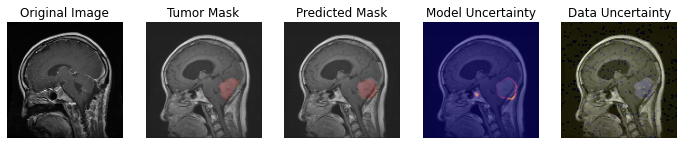

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
temp = torch.ones_like(true[7] )

plt.subplot(1,5,1)
plt.imshow(torch.squeeze(img[26],axis=0), cmap='gray' )
plt.title("Original Image");plt.axis('off')

plt.subplot(1,5,2)
plt.imshow(torch.squeeze(img[22],axis=0), cmap='gray' )
plt.imshow(torch.squeeze(temp - true[22],axis=0), alpha=0.2, cmap='Set1' )
plt.title("Tumor Mask");plt.axis('off')

plt.subplot(1,5,3)
plt.imshow( torch.squeeze(img[22],axis=0), cmap='gray' )
plt.imshow( temp.squeeze(0) - pred[22].argmax(0),  alpha=0.2, cmap='Set1' )
plt.title("Predicted Mask");plt.axis('off')

plt.subplot(1,5,4)
plt.imshow( torch.squeeze(img[22],axis=0), cmap='gray' )
plt.imshow((model_var[22]).squeeze(0), alpha=0.5, cmap=cmap, norm=norm )
plt.title("Model Uncertainty");plt.axis('off')

plt.subplot(1,5,5)
plt.imshow( torch.squeeze(img[22],axis=0), cmap='gray' )
plt.imshow((data_var[22]).squeeze(0), alpha=0.1, cmap=cmap, norm=norm )
plt.title("Data Uncertainty");plt.axis('off')

In [8]:
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl

# cmap = mpl.cm.plasma
# norm = mpl.colors.Normalize(vmin=model_var[0].min(), vmax=model_var[0].max())
norm_data = mpl.colors.Normalize(vmin=data_var[0].min(), vmax=data_var[0].max())

In [57]:
var_d[0].min()

tensor(8.0539e-11, device='cuda:0')

In [59]:
data_var = var_d[0].cpu().detach().numpy()

In [14]:
data_var[0].max()

tensor(0.1219)

In [15]:
data_var[0].min()

tensor(2.5891e-09)

(-0.5, 127.5, 127.5, -0.5)

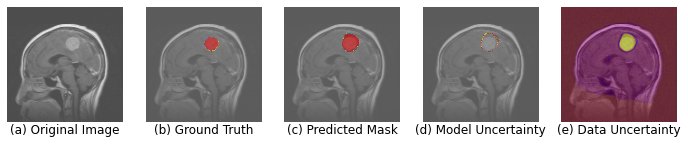

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
# plt.rcParams["figure.autolayout"] = True
temp = torch.ones_like(true[7] )

plt.subplot(1,5,1)
plt.imshow(torch.squeeze(img[0],axis=0), alpha=0.7, cmap='gray' )
plt.title("(a) Original Image", y=-0.15);plt.axis('off')

plt.subplot(1,5,2)
plt.imshow(torch.squeeze(img[0],axis=0), cmap='gray' )
plt.imshow(torch.squeeze(temp - true[0],axis=0), alpha=0.6, cmap='Set1' )
plt.title("(b) Ground Truth", y=-0.15);plt.axis('off')

plt.subplot(1,5,3)
plt.imshow( torch.squeeze(img[0],axis=0), cmap='gray' )
plt.imshow( temp.squeeze(0) - pred[0].argmax(0),  alpha=0.6, cmap='Set1' )
plt.title("(c) Predicted Mask", y=-0.15);plt.axis('off')

plt.subplot(1,5,4)
plt.imshow( torch.squeeze(img[0],axis=0), cmap='gray' )
plt.imshow((temp-model_var[0]).squeeze(0), alpha = 0.6, cmap='Set1')
plt.title("(d) Model Uncertainty", y=-0.15);plt.axis('off')

plt.subplot(1,5,5)
plt.imshow( torch.squeeze(img[0],axis=0), cmap='gray' )
plt.imshow((temp - data_var[0]).squeeze(0), alpha=0.5, cmap=mpl.cm.plasma)
plt.title("(e) Data Uncertainty", y=-0.15);plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

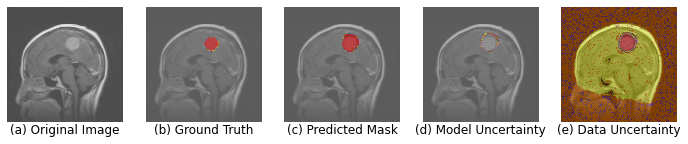

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
# plt.rcParams["figure.autolayout"] = True
temp = torch.ones_like(true[7] )

plt.subplot(1,5,1)
plt.imshow(torch.squeeze(img[0],axis=0), alpha=0.7, cmap='gray' )
plt.title("(a) Original Image", y=-0.15);plt.axis('off')

plt.subplot(1,5,2)
plt.imshow(torch.squeeze(img[0],axis=0), cmap='gray' )
plt.imshow(torch.squeeze(temp - true[0],axis=0), alpha=0.6, cmap='Set1' )
plt.title("(b) Ground Truth", y=-0.15);plt.axis('off')

plt.subplot(1,5,3)
plt.imshow( torch.squeeze(img[0],axis=0), cmap='gray' )
plt.imshow( temp.squeeze(0) - pred[0].argmax(0),  alpha=0.6, cmap='Set1' )
plt.title("(c) Predicted Mask", y=-0.15);plt.axis('off')

plt.subplot(1,5,4)
plt.imshow( torch.squeeze(img[0],axis=0), cmap='gray' )
plt.imshow((temp-model_var[0]).squeeze(0), alpha = 0.6, cmap='Set1')
plt.title("(d) Model Uncertainty", y=-0.15);plt.axis('off')

plt.subplot(1,5,5)
plt.imshow( torch.squeeze(img[0],axis=0), cmap='gray' )
plt.imshow((data_var[0]).squeeze(0), alpha=0.5, cmap='Set1')
plt.title("(e) Data Uncertainty", y=-0.15);plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

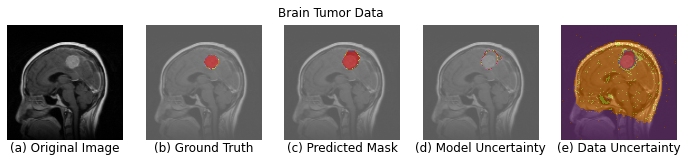

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
# plt.rcParams["figure.autolayout"] = True
plt.suptitle("Brain Tumor Data", y=0.59)
plt.subplots_adjust()
temp = torch.ones_like(true[7] )

plt.subplot(1,5,1)
plt.imshow(torch.squeeze(img[0],axis=0), cmap='gray' )
plt.title("(a) Original Image", y=-0.15);plt.axis('off')

plt.subplot(1,5,2)
plt.imshow(torch.squeeze(img[0],axis=0), cmap='gray' )
plt.imshow(torch.squeeze(temp - true[0],axis=0), alpha=0.6, cmap='Set1' )
plt.title("(b) Ground Truth", y=-0.15);plt.axis('off')

plt.subplot(1,5,3)
plt.imshow( torch.squeeze(img[0],axis=0), cmap='gray' )
plt.imshow( temp.squeeze(0) - pred[0].argmax(0),  alpha=0.6, cmap='Set1' )
plt.title("(c) Predicted Mask", y=-0.15);plt.axis('off')

plt.subplot(1,5,4)
plt.imshow( torch.squeeze(img[0],axis=0), cmap='gray' )
plt.imshow((temp-model_var[0]).squeeze(0), alpha = 0.6, cmap='Set1')
plt.title("(d) Model Uncertainty", y=-0.15);plt.axis('off')

plt.subplot(1,5,5)
plt.imshow( torch.squeeze(img[0],axis=0), cmap='gray' )
plt.imshow((data_var[0]).squeeze(0), alpha=0.5, cmap='Set1')
plt.title("(e) Data Uncertainty", y=-0.15);plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

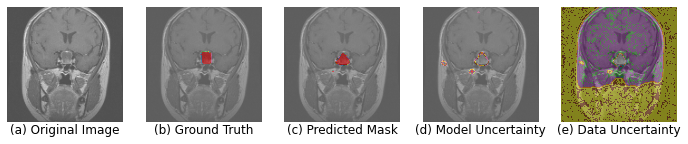

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
# plt.rcParams["figure.autolayout"] = True
temp = torch.ones_like(true[7] )

plt.subplot(1,5,1)
plt.imshow(torch.squeeze(img[50],axis=0), alpha=0.7, cmap='gray' )
plt.title("(a) Original Image", y=-0.15);plt.axis('off')

plt.subplot(1,5,2)
plt.imshow(torch.squeeze(img[50],axis=0), cmap='gray' )
plt.imshow(torch.squeeze(temp - true[50],axis=0), alpha=0.6, cmap='Set1' )
plt.title("(b) Ground Truth", y=-0.15);plt.axis('off')

plt.subplot(1,5,3)
plt.imshow( torch.squeeze(img[50],axis=0), cmap='gray' )
plt.imshow( temp.squeeze(0) - pred[50].argmax(0),  alpha=0.6, cmap='Set1' )
plt.title("(c) Predicted Mask", y=-0.15);plt.axis('off')

plt.subplot(1,5,4)
plt.imshow( torch.squeeze(img[50],axis=0), cmap='gray' )
plt.imshow((temp-model_var[50]).squeeze(0), alpha = 0.6, cmap='Set1')
plt.title("(d) Model Uncertainty", y=-0.15);plt.axis('off')

plt.subplot(1,5,5)
plt.imshow( torch.squeeze(img[50],axis=0), cmap='gray' )
plt.imshow((temp-data_var[50]).squeeze(0), alpha=0.5, cmap='Set1')
plt.title("(e) Data Uncertainty", y=-0.15);plt.axis('off')

In [112]:
model_var.min()
# model_var.max()

tensor(4.1288e-39)

In [135]:
data_var

tensor([[[[0.0500, 0.0482, 0.0487,  ..., 0.0462, 0.0502, 0.0536],
          [0.0439, 0.0444, 0.0492,  ..., 0.0468, 0.0541, 0.0494],
          [0.0532, 0.0479, 0.0510,  ..., 0.0491, 0.0519, 0.0507],
          ...,
          [0.0486, 0.0482, 0.0549,  ..., 0.0464, 0.0494, 0.0492],
          [0.0512, 0.0462, 0.0516,  ..., 0.0498, 0.0505, 0.0491],
          [0.0457, 0.0505, 0.0494,  ..., 0.0479, 0.0481, 0.0510]]],


        [[[0.0487, 0.0500, 0.0473,  ..., 0.0478, 0.0504, 0.0474],
          [0.0481, 0.0473, 0.0472,  ..., 0.0458, 0.0530, 0.0513],
          [0.0474, 0.0453, 0.0522,  ..., 0.0464, 0.0501, 0.0471],
          ...,
          [0.0448, 0.0470, 0.0535,  ..., 0.0473, 0.0466, 0.0488],
          [0.0460, 0.0472, 0.0460,  ..., 0.0543, 0.0463, 0.0487],
          [0.0512, 0.0503, 0.0452,  ..., 0.0470, 0.0474, 0.0469]]],


        [[[0.0518, 0.0510, 0.0468,  ..., 0.0520, 0.0476, 0.0475],
          [0.0481, 0.0503, 0.0481,  ..., 0.0532, 0.0514, 0.0467],
          [0.0504, 0.0499, 0.0452,  ..

In [103]:
model_var

tensor([[[[8.1573e-05, 5.1892e-05, 2.4982e-04,  ..., 4.5835e-05,
           4.1078e-05, 5.6346e-05],
          [1.3113e-04, 1.0182e-04, 7.6934e-05,  ..., 5.0870e-05,
           8.3546e-05, 7.5924e-05],
          [9.8140e-05, 8.2170e-05, 6.7567e-05,  ..., 1.0461e-04,
           6.4745e-05, 9.1184e-05],
          ...,
          [6.5173e-05, 2.6997e-05, 9.2459e-05,  ..., 8.4910e-05,
           5.3628e-05, 8.6222e-05],
          [1.3819e-04, 5.1629e-05, 6.1148e-05,  ..., 5.7267e-05,
           7.2757e-05, 5.0750e-05],
          [8.4121e-05, 9.5896e-05, 4.1302e-05,  ..., 1.6103e-04,
           8.1757e-05, 7.2813e-05]]],


        [[[5.7763e-05, 3.3940e-05, 4.8050e-05,  ..., 4.0291e-05,
           2.0458e-04, 6.3088e-05],
          [1.0577e-04, 6.1476e-05, 1.7338e-04,  ..., 5.7540e-05,
           8.9290e-05, 1.4404e-04],
          [6.5701e-05, 7.7043e-05, 8.6811e-05,  ..., 5.8503e-05,
           1.1429e-04, 4.3063e-05],
          ...,
          [6.7267e-05, 4.0909e-05, 7.3434e-05,  ..., 1.70

In [92]:
true.shape

torch.Size([241, 1, 128, 128])

In [98]:
pred

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...,

In [93]:
pr = pred.cpu().detach().numpy()


In [95]:
pr.shape

(241, 2, 128, 128)

In [89]:
model_var.shape

torch.Size([241, 1, 128, 128])

In [33]:
data_var = var_d.cpu().detach().numpy()

In [48]:
data_var.min()

tensor(-8.8727e+32)

In [37]:
data_var[0].shape

(1, 128, 128)

<ipython-input-30-986c1cf55051>:15: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=map_object)


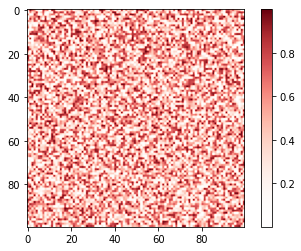

In [30]:
# change alpha values
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# get colormap
ncolors = 256
color_array = plt.get_cmap('Reds')(range(ncolors))
color_array[:,-1] = np.linspace(0,1,ncolors)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='red_alpha',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

# show some example data
f,ax = plt.subplots()
h = ax.imshow(np.random.rand(100,100),cmap='red_alpha')
plt.colorbar(mappable=h)

In [53]:
data_var

tensor([[[[ 4.9972e-02,  4.8183e-02,  4.8655e-02,  ...,  9.5260e+09,
            5.0158e-02,  1.3429e+13],
          [ 4.1350e+19,  1.5864e+31,  4.9249e-02,  ...,  3.1120e+06,
            7.3075e+29,  3.6578e+27],
          [ 2.0915e+08,  4.4932e+28,  6.6593e+08,  ...,  4.9080e-02,
            2.2760e+26,  5.5804e+28],
          ...,
          [ 4.8628e-02,  4.8248e-02,  5.5220e-02,  ...,  4.6405e-02,
            4.9378e-02,  4.9212e-02],
          [ 5.1221e-02,  1.3292e+35, -4.5467e-01,  ...,  4.9774e-02,
            5.0510e-02,  4.9114e-02],
          [ 1.9929e+12,  5.0511e-02, -1.2677e+29,  ...,  4.7905e-02,
           -2.1256e+33,  5.1025e-02]]],


        [[[ 4.8715e-02,  4.9959e-02,  4.7326e-02,  ...,  9.5260e+09,
            5.0441e-02,  1.3429e+13],
          [ 4.1350e+19,  1.5864e+31,  4.7231e-02,  ...,  3.1120e+06,
            7.3075e+29,  3.6578e+27],
          [ 2.0915e+08,  4.4932e+28,  6.6593e+08,  ...,  4.6357e-02,
            2.2760e+26,  5.5804e+28],
          ...,
   

In [51]:
data_var.min()

tensor(nan)

In [52]:
data_var.max()

tensor(nan)

In [15]:
var_model.max()

tensor(0.1890, device='cuda:0')

In [32]:
data_var.min()

tensor(nan)

In [33]:
data_var.max()

tensor(nan)

In [34]:
model_var.min()

tensor(8.0424e-29)

In [35]:
model_var.max()

tensor(0.2231)

In [37]:
model_var

tensor([[[[2.1459e-04, 1.3938e-04, 5.2208e-04,  ..., 1.4008e-04,
           1.1605e-04, 1.5489e-04],
          [3.2681e-04, 2.7509e-04, 2.1722e-04,  ..., 1.5427e-04,
           2.1384e-04, 2.1425e-04],
          [2.6544e-04, 2.3247e-04, 1.9976e-04,  ..., 2.8629e-04,
           1.8020e-04, 2.6371e-04],
          ...,
          [1.8309e-04, 8.8524e-05, 2.6793e-04,  ..., 2.5610e-04,
           1.6113e-04, 2.4894e-04],
          [3.8756e-04, 1.4015e-04, 1.7441e-04,  ..., 1.6379e-04,
           1.8588e-04, 1.4813e-04],
          [2.2094e-04, 2.5615e-04, 1.2234e-04,  ..., 4.2522e-04,
           2.6015e-04, 1.9792e-04]]],


        [[[1.6827e-04, 1.0041e-04, 1.2097e-04,  ..., 1.1896e-04,
           4.6923e-04, 2.0141e-04],
          [2.6214e-04, 1.7423e-04, 4.3944e-04,  ..., 1.6968e-04,
           2.5112e-04, 3.7727e-04],
          [1.8615e-04, 2.2750e-04, 2.5003e-04,  ..., 1.4313e-04,
           3.3138e-04, 1.1951e-04],
          ...,
          [1.6674e-04, 1.2790e-04, 1.8475e-04,  ..., 4.44

In [12]:
counts

488

In [11]:
##samp1
print(prec_score)
print(rec_score)
print(spec_score)
print(f1/counts)
print(dice_score)
print(iou_score)

tensor(0.8669, device='cuda:0')
tensor(0.8172, device='cuda:0')
tensor(0.8172, device='cuda:0')
tensor(0.8183, device='cuda:0')
tensor(0.9909, device='cuda:0')
tensor(0.7656, device='cuda:0')


In [13]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pred = torch.empty(613,2,128,128)
var = torch.empty(613,1,128,128)
prec = 0
rec = 0
spec = 0
f1 = 0
dice_sc = 0
iou_sc = 0
counts = 0
with torch.autocast(device.type if device.type != 'cuda' else 'cpu'):
    for batch in tqdm(dataset_val, total=len(dataset_val)):
        # print(batch)
        image, mask_true = batch[0], batch[1]
        image = torch.unsqueeze(image, dim=0)
        mask_true = torch.unsqueeze(mask_true, dim=0)
            # move images and labels to correct device and type
        image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
        mask_true = mask_true.to(device=device, dtype=torch.long)
        with torch.no_grad():
            mask_pred = model(image)
            # mask_pred2 = model(image)
            # mask_pred3 = model(image)
            # mask_pred4= model(image)
            # mask_pred5= model(image)
            # mask_pred6= tumor(image)
            # mask_pred7= tumor(image)
            # mask_pred8, mask_var8 = tumor(image)
            # # mask_pred9, mask_var9 = tumor(image)
            # mask_var = (mask_var1 + mask_var2 + mask_var3 + mask_var4 + mask_var5 + mask_var6 + mask_var7 + mask_var8 + mask_var9 )/9
            # mask_pred = (mask_pred1 + mask_pred2 + mask_pred3 + mask_pred4 + mask_pred5 + mask_pred6 + mask_pred7 + mask_pred8 + mask_pred9 )/9
            # mask_var = (mask_var1 + mask_var2 + mask_var3 )/3
            # mask_pred = (mask_pred1 + mask_pred2 + mask_pred3 + mask_pred4 + mask_pred5)/5
            pred[counts] = mask_pred
          #  var_pred = torch.add(torch.add(torch.add(torch.add(torch.add(torch.add(torch.add(torch.add(torch.square(torch.sub(mask_pred1,mask_pred)), torch.square(torch.sub(mask_pred2,mask_pred))), torch.square(torch.sub(mask_pred3,mask_pred))),torch.square(torch.sub(mask_pred4,mask_pred))),torch.square(torch.sub(mask_pred5,mask_pred))),torch.square(torch.sub(mask_pred6,mask_pred))), torch.square(torch.sub(mask_pred7,mask_pred))),torch.square(torch.sub(mask_pred8,mask_pred))),torch.square(torch.sub(mask_pred9,mask_pred)))/5
         #   var_m, var_ind = torch.max(var_pred, axis = 1)
            # print(mask_var.shape)
           # var[counts] = mask_var + var_m
            # var[counts] = torch.var(pred[counts])
            prec += precision(mask_pred, mask_true.squeeze(1).long())
            rec += recall(mask_pred, mask_true.squeeze(1).long())
            spec += specificity(mask_pred, mask_true.squeeze(1).long())
            f1 += f1_score(mask_pred.argmax(1), mask_true.squeeze(1).long())
            dice_sc += dice(mask_pred.argmax(1), mask_true.squeeze(1).long())
            iou_sc += Iou(mask_pred, mask_true.squeeze(1).long())
            counts +=1

prec_score = prec/counts
rec_score = rec/counts
spec_score = spec/counts
f1_sc = f1/counts
dice_score = dice_sc/counts
iou_score = iou_sc/counts

100%|██████████| 488/488 [01:26<00:00,  5.66it/s]


In [14]:
##samp1
print(prec_score)
print(rec_score)
print(spec_score)
print(f1_sc)
print(dice_score)
print(iou_score)

tensor(0.8669, device='cuda:0')
tensor(0.8172, device='cuda:0')
tensor(0.8172, device='cuda:0')
tensor(0.8183, device='cuda:0')
tensor(0.9909, device='cuda:0')
tensor(0.7656, device='cuda:0')


In [ ]:
0.01_20_upd

In [9]:
##samp1
print(prec_score)
print(rec_score)
print(spec_score)
print(dice_score)
print(iou_score)

tensor(0.8669, device='cuda:0')
tensor(0.8172, device='cuda:0')
tensor(0.8172, device='cuda:0')
tensor(0.9909, device='cuda:0')
tensor(0.7656, device='cuda:0')


In [7]:
## samp1 with reverse preds
print(prec_score)
print(rec_score)
print(spec_score)
print(dice_score)
print(iou_score)

tensor(0.8669, device='cuda:0')
tensor(0.8172, device='cuda:0')
tensor(0.8172, device='cuda:0')
tensor(0.9909, device='cuda:0')
tensor(0.7656, device='cuda:0')


In [9]:
##samp4
print(prec_score)
print(rec_score)
print(spec_score)
print(dice_score)
print(iou_score)

tensor(0.8405, device='cuda:0')
tensor(0.8505, device='cuda:0')
tensor(0.8505, device='cuda:0')
tensor(0.9905, device='cuda:0')
tensor(0.7728, device='cuda:0')


In [19]:
true.shape

torch.Size([488, 1, 128, 128])

In [26]:
ma.shape

torch.Size([488, 128, 128])

In [27]:
ma_p.shape

torch.Size([488, 128, 128])

In [37]:
ma.shape[0]

488

In [9]:
# im = np.squeeze(X_test[2],axis=-1)
ma = np.squeeze(true,axis=1)
ma_p = pred.argmax(1)
tp = []
tn = []
fp = []
fn = []
for i in range(ma.shape[0]):
    for j in range(ma.shape[1]):
        for k in range(ma.shape[2]):
            if ma[i][j][k] == 1 and ma_p[i][j][k] == 1:
                tp.append(ma[i][j])
            elif ma[i][j][k] == 0 and ma_p[i][j][k] == 0:
                tn.append(ma[i][j])
            elif ma[i][j][k] == 0 and ma_p[i][j][k] == 1:
                fp.append(ma[i][j])
            elif ma[i][j][k] == 1 and ma_p[i][j][k] == 0:
                fn.append(ma[i][j])

In [10]:
print(len(tp))
print(len(fp))
print(len(tn))
print(len(fn))

32409
16186
7938052
8745


In [11]:
dice = 2*len(tp)/(2*len(tp) + len(fp) + len(fn))
print(dice)

0.7222141750883018


In [12]:
iou = len(tp)/(len(tp) + len(fp) + len(fn))
print(iou)

0.5652075340076735


In [ ]:
f1_score = 

In [41]:
print(len(tp))
print(len(fp))
print(len(tn))
print(len(fn))

74335
16969
7848204
55884


In [43]:
dice = 2*len(tp)/(2*len(tp) + len(fp) + len(fn))
print(dice)

0.6711267001620599


In [44]:
print("Precision", len(tp)/(len(tp)+len(fp)))

Precision 0.8141483396127224


In [7]:
model = torch.load("/DATA/shraddha/BS_Thesis/paper_experiments/results/unet_model_unc_samp4.pt")

In [12]:
def dice_coeff(y_true, y_pred):
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * torch.sum(intersection)) / (torch.sum(y_true_f) + torch.sum(y_pred_f))
    return score

In [115]:
import pandas as pd
val_dice = pd.read_csv("results/val_dice_model_unc_samp12.csv", header=None)
val_iou = pd.read_csv("results/val_iou_model_unc_samp12.csv", header=None)

In [116]:
## samp12
print(max(val_iou[0]))
print(val_dice[0][val_iou.idxmax()])

0.742283
65    0.991016
Name: 0, dtype: float64


In [112]:
## samp15
print(max(val_iou[0]))
print(val_dice[0][val_iou.idxmax()])

0.742457
55    0.990734
Name: 0, dtype: float64


In [114]:
## samp18
print(max(val_iou[0]))
print(val_dice[0][val_iou.idxmax()])

0.728363
40    0.990268
Name: 0, dtype: float64


In [1]:
import pandas as pd
val_dice = pd.read_csv("results/val_dice_model_unc_samp4.csv", header=None)
val_iou = pd.read_csv("results/val_iou_model_unc_samp4.csv", header=None)

In [2]:
print(max(val_iou[0]))
print(val_dice[0][val_iou.idxmax()])

0.730903
53    0.990443
Name: 0, dtype: float64


### Data Uncertainty

In [34]:
data = torch.load("/DATA/shraddha/BS_Thesis/paper_experiments/data_unc_results/unet_data_unc_0.5.pt")
data.eval()

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_drop1): Dropout(p=0.1, inplace=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNor

In [35]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pred = torch.empty(613,2,128,128)
var = torch.empty(613,1,128,128)
prec = 0
rec = 0
spec = 0
dice_sc = 0
iou_sc = 0
counts = 0
with torch.autocast(device.type if device.type != 'cuda' else 'cpu'):
    for batch in tqdm(dataset_test, total=len(dataset_test)):
        # print(batch)
        image, mask_true = batch[0], batch[1]
        image = torch.unsqueeze(image, dim=0)
        mask_true = torch.unsqueeze(mask_true, dim=0)
            # move images and labels to correct device and type
        image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
        mask_true = mask_true.to(device=device, dtype=torch.long)
        with torch.no_grad():
            mask_pred, var_pred = data(image)
            # mask_pred2 = model(image)
            # mask_pred3 = model(image)
            # mask_pred4= model(image)
            # mask_pred5= model(image)
            # mask_pred6= tumor(image)
            # mask_pred7= tumor(image)
            # mask_pred8, mask_var8 = tumor(image)
            # # mask_pred9, mask_var9 = tumor(image)
            # mask_var = (mask_var1 + mask_var2 + mask_var3 + mask_var4 + mask_var5 + mask_var6 + mask_var7 + mask_var8 + mask_var9 )/9
            # mask_pred = (mask_pred1 + mask_pred2 + mask_pred3 + mask_pred4 + mask_pred5 + mask_pred6 + mask_pred7 + mask_pred8 + mask_pred9 )/9
            # mask_var = (mask_var1 + mask_var2 + mask_var3 )/3
            # mask_pred = (mask_pred1 + mask_pred2 + mask_pred3 + mask_pred4 + mask_pred5)/5
            pred[counts] = mask_pred

            prec += precision(mask_pred, mask_true.squeeze(1).long())
            rec += recall(mask_pred, mask_true.squeeze(1).long())
            spec += specificity(mask_pred, mask_true.squeeze(1).long())
            dice_sc += dice(mask_pred, mask_true.squeeze(1).long())
            iou_sc += Iou(mask_pred, mask_true.squeeze(1).long())
            counts +=1

prec_score = prec/counts
rec_score = rec/counts
spec_score = spec/counts
dice_score = dice_sc/counts
iou_score = iou_sc/counts

100%|██████████| 241/241 [00:26<00:00,  9.13it/s]


In [12]:
##0.01
print(prec_score)
print(rec_score)
print(spec_score)
print(dice_score)
print(iou_score)

tensor(0.6924, device='cuda:0')
tensor(0.6443, device='cuda:0')
tensor(0.6443, device='cuda:0')
tensor(0.9910, device='cuda:0')
tensor(0.6105, device='cuda:0')


In [13]:
iou_data = []

In [36]:
iou_data.append(np.mean(np.array(iou_score.cpu().detach().numpy())))

In [7]:
iou_data = [0.6322333, 0.61004204, 0.6262292, 0.631707]
iou_data

[0.6322333, 0.61004204, 0.6262292, 0.631707]

In [37]:
iou_data

[0.6104747, 0.6322333, 0.61004204, 0.6262292, 0.631707]

In [8]:
key = [0.02, 0.05, 0.1, 0.5]

In [9]:
dic = {}
for i in range(len(key)):
    dic[key[i]] = iou_data[i]

In [10]:
dic

{0.02: 0.6322333, 0.05: 0.61004204, 0.1: 0.6262292, 0.5: 0.631707}

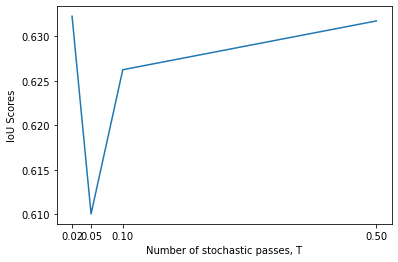

In [12]:
## test set
import matplotlib.pyplot as plt

lists = sorted(dic.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.xticks([0.02, 0.05, 0.1, 0.5])
plt.xlabel("Number of stochastic passes, T")
plt.ylabel("IoU Scores")
plt.show()

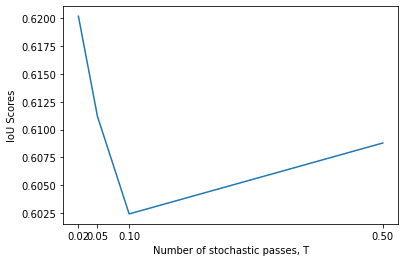

In [17]:
## val set
import matplotlib.pyplot as plt

lists = sorted(dic.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.xticks([0.02, 0.05, 0.1, 0.5])
plt.xlabel("Number of stochastic passes, T")
plt.ylabel("IoU Scores")
plt.show()

In [45]:
import pandas as pd
val_dice = pd.read_csv("data_unc_results/val_dice_data_unc_0.1.csv", header=None)
val_iou = pd.read_csv("data_unc_results/val_iou_data_unc_0.1.csv", header=None)

In [124]:
## 0.01
print(max(val_iou[0]))
print(val_dice[0][val_iou.idxmax()])

0.610304
162    0.987142
Name: 0, dtype: float64


In [118]:
## 0.02
print(max(val_iou[0]))
print(val_dice[0][val_iou.idxmax()])

0.620188
191    0.987461
Name: 0, dtype: float64


In [120]:
## 0.05
print(max(val_iou[0]))
print(val_dice[0][val_iou.idxmax()])

0.611193
186    0.987373
Name: 0, dtype: float64


In [46]:
## 0.1
print(max(val_iou[0]))
print(val_dice[0][val_iou.idxmax()])

0.602417
94    0.987019
Name: 0, dtype: float64


In [33]:
## 0.5
print(max(val_iou[0]))
print(val_dice[0][val_iou.idxmax()])

0.608792
157    0.987249
Name: 0, dtype: float64


In [14]:
## 0.01 = 0.610304

In [15]:
y = [0.620188, 0.611193, 0.602417, 0.608792]

In [16]:
dic = {}
for i in range(len(key)):
    dic[key[i]] = y[i]

In [1]:
pred_new = 1-pred.argmax(1)

NameError: name 'pred' is not defined

In [3]:
from dataset import BrainMRIDATASET
from torch.utils.data import DataLoader
data_ob = BrainMRIDATASET()
dataset_tr, dataset_val, dataset_test  = data_ob.get_BrainMRIDataset('/DATA/shraddha/brain-tumor-segmentation-unet/brain_tumor_dataset/')
data_loader_tr = DataLoader(dataset_tr, batch_size=2)
data_loader_val = DataLoader(dataset_val, batch_size=2)

Number of patients in train set: 143, validation_set: 45 and test set: 45
(torch.Size([2335, 1, 128, 128]), torch.Size([2335, 1, 128, 128]))
(torch.Size([488, 1, 128, 128]), torch.Size([488, 1, 128, 128]))
(torch.Size([241, 1, 128, 128]), torch.Size([241, 1, 128, 128]))
torch.Size([4670, 1, 128, 128]) torch.Size([4670, 1, 128, 128])
